# Module 4 Project: Supplemental Work - Gina Durante

## Overview

The Module 4 Project in the Flatiron School Data Science Version 2 Curriculum is meant to provide students with experience in working with time series data--in this case, monthly housing values from 04/01/1996 to 03/01/2018 for over 14,000 ZIP Codes in the U.S. The project asks the student to identify the 5 "best" ZIP codes for investment, as defined by the student, and develop support for these recommendations to a hypothetical client (e.g., a real estate investment trust). The student must develop a methodology for evaluating ZIP codes as potential investment targets and support these findings through a technical Jupyter notebook, a non-technical PowerPoint presentation, and a blog post. 

## Supplemental work

This notebook explores average home values rolled up to the US Metro area.  My analysis first creates visualizations of the top 30 metro areas (ranked by number of ZIP codes in the metro area--a rough, though not perfect, proxy for total population--a value not available in this data set).  

Having looked at many visualizations at the metro, city, and ZIP code level, I began noticing certain characteristics in the housing value curves that I thought might correlate to investment quality.  

While my Module 4 project officially forcuses on ZIP codes in the Sacramento metro area, this supplemental notebook evaluates average values for 10 selected metro areas and uses ARIMA modeling and forecasting tools to predict the values 24 months into the future. 


## From my Mod4 project jupyter notebook:  Methodology, in brief

### Visualization of values by city and/or ZIP code, as well as of predictions of model

While most of my project efforts went towards analyzing ZIP codes in the Sacramento metro region, I did spend quite a bit of time early on developing methods to allow more data exploration--especially visualization.  
* I developed iterative functions to visualize values by city within a metro area and across zip codes within cities in a metro area, using lists and dictionaries to iterate through the geographic areas of interest.  
* Not only did this process improve my dataframe manipulation and visualization skills, it allowed me to see a broader range of geographies and identify interesting patterns in the plots of home values in various geographies.  
* These observations, in turn, suggest some interesting opportunities in other geographies. 

### Consideration of predicted values, worst- and best-case scenarios, and other factors in the selection process

While the predicted returns over the forecast time horizon were of greatest interest, I also took into account the worst-case scenario returns, the best-case scenario returns, the population in the ZIP code, the geographic location of the ZIP code, and personal knowledge of the area to inform my decision-making process.  

## Possible future directions

Several other possible future directions for this work are intriguing:
- While time limitations prevented a broader evaluation of investment opportunities across the country, the functions I developed allow visualizations of broader swaths of the data (e.g., values by metro area, values by city within a metro area, values by zip codes and cities within a metro area).  
  - Creating visualizations at various geographic levels was very useful for identifying patterns that could signify promising investment opportunities.  
  - From this effort, I identified some geographic areas, such as the Dallas-Fort Worth and the Pittsburg metro areas, that could be worthwhile to explore in future efforts.  
- It could be interesting and potentially valuable to do some backtesting on the model to see how well it predicts the last 24 months for which we have data (May 2016 through April 2018).
- Analyzing shorter time frames (e.g., 2013-2018)
- Scaling investment by population size 
- Construct a basket of investments (e.g., $10M, weighted by ZIP population?)


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [241]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sn

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from collections import defaultdict
from collections import OrderedDict

In [2]:
pd.set_option("display.max_rows", 300)

In [3]:
pd.get_option("display.max_rows")

300

In [4]:
df = pd.read_csv('zillow_data.csv')

In [5]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

# Step 2: Data Preprocessing

## Convert time data type to datetime format

In [6]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m', errors = 'raise')

In [7]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## Fix problem with ZIP codes beginning with '0'

I have surmised that RegionName is the ZIP code for each entry.  RegionName values with only 4 digits represent ZIP codes that actually begin with '0'.  So that I can work with ZIP codes in the data set, I will need to add that zero onto every 4-digit RegionName value.  Once that's completed, I'll rename this column "ZipCode".  

In [8]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [9]:
df.sort_values(by="RegionName").head()

RegionID  RegionName         City State        Metro CountyName  \
5850      58196        1001       Agawam    MA  Springfield    Hampden   
4199      58197        1002      Amherst    MA  Springfield  Hampshire   
11213     58200        1005        Barre    MA    Worcester  Worcester   
6850      58201        1007  Belchertown    MA  Springfield  Hampshire   
14547     58202        1008    Blandford    MA  Springfield    Hampden   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
5850       5851  113100.0  112800.0  112600.0  ...   213900   215700   218200   
4199       4200  161000.0  160100.0  159300.0  ...   333700   334800   336700   
11213     11214  103100.0  103400.0  103600.0  ...   205600   206800   208800   
6850       6851  133400.0  132700.0  132000.0  ...   266100   266300   267000   
14547     14548  117500.0  117300.0  117100.0  ...   202400   202900   205900   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
5850    220100   221100   221700   221700   221700   222700   223600  
4199    338900   340400   342000   344500   347400   350600   353300  
11213   210400   211300   213300   215600   217900   219500   220700  
6850    267500   268000   268100   268100   268800   270000   270600  
14547   208500   207500   205400   204500   206800   210900   214200  

[5 rows x 272 columns]

In [10]:
df['RegionName'] = df.RegionName.astype(str)
df['RegionName'].dtype


dtype('O')

In [11]:
df.rename(columns={'RegionName': 'Zip'}, inplace=True)
df.columns
df.head()

RegionID    Zip      City State              Metro CountyName  SizeRank  \
0     84654  60657   Chicago    IL            Chicago       Cook         1   
1     90668  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982  77494      Katy    TX            Houston     Harris         3   
3     84616  60614   Chicago    IL            Chicago       Cook         4   
4     93144  79936   El Paso    TX            El Paso    El Paso         5   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
1  235700.0  236900.0  236700.0  ...   308000   310000   312500   314100   
2  210400.0  212200.0  212200.0  ...   321000   320600   320200   320400   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
4   77300.0   77300.0   77300.0  ...   119100   119400   120000   120300   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  
2   320800   321200   321200   323000   326900   329900  
3  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [12]:
zips = []

for i in df['Zip']:
    if len(i) < 5:
        i = '0' + i
        zips.append(i)
    else:
        zips.append(i)

zips
df['Zip'] = pd.Series(zips)
df.sort_values(by='Zip').head()
# df.head()

RegionID    Zip         City State        Metro CountyName  SizeRank  \
5850      58196  01001       Agawam    MA  Springfield    Hampden      5851   
4199      58197  01002      Amherst    MA  Springfield  Hampshire      4200   
11213     58200  01005        Barre    MA    Worcester  Worcester     11214   
6850      58201  01007  Belchertown    MA  Springfield  Hampshire      6851   
14547     58202  01008    Blandford    MA  Springfield    Hampden     14548   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
5850   113100.0  112800.0  112600.0  ...   213900   215700   218200   220100   
4199   161000.0  160100.0  159300.0  ...   333700   334800   336700   338900   
11213  103100.0  103400.0  103600.0  ...   205600   206800   208800   210400   
6850   133400.0  132700.0  132000.0  ...   266100   266300   267000   267500   
14547  117500.0  117300.0  117100.0  ...   202400   202900   205900   208500   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
5850    221100   221700   221700   221700   222700   223600  
4199    340400   342000   344500   347400   350600   353300  
11213   211300   213300   215600   217900   219500   220700  
6850    268000   268100   268100   268800   270000   270600  
14547   207500   205400   204500   206800   210900   214200  

[5 rows x 272 columns]

## Creating dataframes by various groupings and geographies

### Creating US dataframe (df_melt) using melt function

In [13]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=False)
    melted = melted.dropna(subset=['value'])
    return melted   

In [14]:
df_melt = melt_data(df)


In [15]:
df_melt.head()

RegionID    Zip      City State              Metro CountyName  SizeRank  \
0     84654  60657   Chicago    IL            Chicago       Cook         1   
1     90668  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982  77494      Katy    TX            Houston     Harris         3   
3     84616  60614   Chicago    IL            Chicago       Cook         4   
4     93144  79936   El Paso    TX            El Paso    El Paso         5   

        time     value  
0 1996-04-01  334200.0  
1 1996-04-01  235700.0  
2 1996-04-01  210400.0  
3 1996-04-01  498100.0  
4 1996-04-01   77300.0

In [16]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
Zip           object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
time          datetime64[ns]
value         float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 285.7+ MB


In [17]:
df_melt.set_index('time')

RegionID    Zip                 City State              Metro  \
time                                                                        
1996-04-01     84654  60657              Chicago    IL            Chicago   
1996-04-01     90668  75070             McKinney    TX  Dallas-Fort Worth   
1996-04-01     91982  77494                 Katy    TX            Houston   
1996-04-01     84616  60614              Chicago    IL            Chicago   
1996-04-01     93144  79936              El Paso    TX            El Paso   
...              ...    ...                  ...   ...                ...   
2018-04-01     58333  01338             Ashfield    MA    Greenfield Town   
2018-04-01     59107  03293            Woodstock    NH          Claremont   
2018-04-01     75672  40404                Berea    KY           Richmond   
2018-04-01     93733  81225  Mount Crested Butte    CO                NaN   
2018-04-01     95851  89155             Mesquite    NV          Las Vegas   

           CountyName  SizeRank     value  
time                                       
1996-04-01       Cook         1  334200.0  
1996-04-01     Collin         2  235700.0  
1996-04-01     Harris         3  210400.0  
1996-04-01       Cook         4  498100.0  
1996-04-01    El Paso         5   77300.0  
...               ...       ...       ...  
2018-04-01   Franklin     14719  209300.0  
2018-04-01    Grafton     14720  225800.0  
2018-04-01    Madison     14721  133400.0  
2018-04-01   Gunnison     14722  664400.0  
2018-04-01      Clark     14723  357200.0  

[3744704 rows x 8 columns]

In [18]:
## Dropping RegionID:
df_melt.drop('RegionID', axis=1, inplace=True)

In [19]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank       time  \
0  60657   Chicago    IL            Chicago       Cook         1 1996-04-01   
1  75070  McKinney    TX  Dallas-Fort Worth     Collin         2 1996-04-01   
2  77494      Katy    TX            Houston     Harris         3 1996-04-01   
3  60614   Chicago    IL            Chicago       Cook         4 1996-04-01   
4  79936   El Paso    TX            El Paso    El Paso         5 1996-04-01   

      value  
0  334200.0  
1  235700.0  
2  210400.0  
3  498100.0  
4   77300.0

Dataframe is sorted by SizeRank by default.

In [20]:
df_melt.isna().sum()

Zip                0
City               0
State              0
Metro         236023
CountyName         0
SizeRank           0
time               0
value              0
dtype: int64

In [21]:
df_melt['Metro'].fillna('Missing', inplace=True)
df_melt.isna().sum()

Zip           0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [22]:
# Sorting by zip code, then time

df_melt.sort_values(by=['Zip', 'time'])

Zip       City State        Metro         CountyName  SizeRank  \
5850     01001     Agawam    MA  Springfield            Hampden      5851   
20573    01001     Agawam    MA  Springfield            Hampden      5851   
35296    01001     Agawam    MA  Springfield            Hampden      5851   
50019    01001     Agawam    MA  Springfield            Hampden      5851   
64742    01001     Agawam    MA  Springfield            Hampden      5851   
...        ...        ...   ...          ...                ...       ...   
3835273  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3849996  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3864719  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3879442  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3894165  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   

              time     value  
5850    1996-04-01  113100.0  
20573   1996-05-01  112800.0  
35296   1996-06-01  112600.0  
50019   1996-07-01  112300.0  
64742   1996-08-01  112100.0  
...            ...       ...  
3835273 2017-12-01  291900.0  
3849996 2018-01-01  294200.0  
3864719 2018-02-01  297500.0  
3879442 2018-03-01  302100.0  
3894165 2018-04-01  305100.0  

[3744704 rows x 8 columns]

Note that a few zip codes are missing; these rows were eliminated when Zip codes with NaN values in the 'value' column were dropped.

In [23]:
df_melt.nunique()

Zip           14723
City           7554
State            51
Metro           702
CountyName     1212
SizeRank      14723
time            265
value         24372
dtype: int64

### Creating new column, MetroState, to address duplicate metro names in different states (e.g., Aberdeen in multiple states)

Wanted to make sure that the values from totally unrelated metro areas in different states weren't inadvertently merged together.

In [24]:
df_melt['MetroState'] = df_melt['Metro'] + ' ' + df_melt['State']

In [25]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank       time  \
0  60657   Chicago    IL            Chicago       Cook         1 1996-04-01   
1  75070  McKinney    TX  Dallas-Fort Worth     Collin         2 1996-04-01   
2  77494      Katy    TX            Houston     Harris         3 1996-04-01   
3  60614   Chicago    IL            Chicago       Cook         4 1996-04-01   
4  79936   El Paso    TX            El Paso    El Paso         5 1996-04-01   

      value            MetroState  
0  334200.0            Chicago IL  
1  235700.0  Dallas-Fort Worth TX  
2  210400.0            Houston TX  
3  498100.0            Chicago IL  
4   77300.0            El Paso TX

### Creating df_metro (US metro df) with monthly values by Zip

In [26]:
df_melt.set_index('time', inplace=True)

In [27]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank  \
time                                                                        
1996-04-01  60657   Chicago    IL            Chicago       Cook         1   
1996-04-01  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
1996-04-01  77494      Katy    TX            Houston     Harris         3   
1996-04-01  60614   Chicago    IL            Chicago       Cook         4   
1996-04-01  79936   El Paso    TX            El Paso    El Paso         5   

               value            MetroState  
time                                        
1996-04-01  334200.0            Chicago IL  
1996-04-01  235700.0  Dallas-Fort Worth TX  
1996-04-01  210400.0            Houston TX  
1996-04-01  498100.0            Chicago IL  
1996-04-01   77300.0            El Paso TX

Note:  the dataframe is sorted by zipcode SizeRank by default.  

In [28]:
df_metro = df_melt.groupby(['Metro', 'MetroState', 'CountyName', 'City', 'Zip', 'time']).mean().reset_index()


In [29]:
df_metro.head(10)

Metro   MetroState    CountyName      City    Zip       time  SizeRank  \
0  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-04-01      5029   
1  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-05-01      5029   
2  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-06-01      5029   
3  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-07-01      5029   
4  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-08-01      5029   
5  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-09-01      5029   
6  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-10-01      5029   
7  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-11-01      5029   
8  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-12-01      5029   
9  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1997-01-01      5029   

     value  
0  86600.0  
1  86300.0  
2  86100.0  
3  85900.0  
4  85700.0  
5  85600.0  
6  85600.0  
7  85700.0  
8  85800.0  
9  85900.0

In [30]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744704 entries, 0 to 3744703
Data columns (total 8 columns):
Metro         object
MetroState    object
CountyName    object
City          object
Zip           object
time          datetime64[ns]
SizeRank      int64
value         float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 228.6+ MB


In [31]:
df_metro.set_index('time', inplace=True)

In [32]:
df_metro.head()

Metro   MetroState    CountyName      City    Zip  SizeRank  \
time                                                                         
1996-04-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-05-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-06-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-07-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-08-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   

              value  
time                 
1996-04-01  86600.0  
1996-05-01  86300.0  
1996-06-01  86100.0  
1996-07-01  85900.0  
1996-08-01  85700.0

In [33]:
df_metro.nunique()

Metro           702
MetroState      865
CountyName     1212
City           7554
Zip           14723
SizeRank      14723
value         24372
dtype: int64

### Creating df_metro_values (US Metros df with *Metro* mean values)

In [39]:
df_metro_values = df_melt.groupby(['MetroState', 'State', 'time']).mean().reset_index()

In [40]:
df_metro_values.head()

MetroState State       time  SizeRank    value
0  Aberdeen WA    WA 1996-04-01   10259.5  95910.0
1  Aberdeen WA    WA 1996-05-01   10259.5  95840.0
2  Aberdeen WA    WA 1996-06-01   10259.5  95800.0
3  Aberdeen WA    WA 1996-07-01   10259.5  95760.0
4  Aberdeen WA    WA 1996-08-01   10259.5  95710.0

In [41]:
df_metro_values = df_metro_values.set_index('time')

In [42]:
df_metro_values.drop('SizeRank', axis=1, inplace=True)

In [43]:
df_metro_values.head()

MetroState State    value
time                                  
1996-04-01  Aberdeen WA    WA  95910.0
1996-05-01  Aberdeen WA    WA  95840.0
1996-06-01  Aberdeen WA    WA  95800.0
1996-07-01  Aberdeen WA    WA  95760.0
1996-08-01  Aberdeen WA    WA  95710.0

In [44]:
df_metro_values.MetroState.value_counts().head()

Rochester NY    265
Key West FL     265
Utica NY        265
Shelby NC       265
Duluth MN       265
Name: MetroState, dtype: int64

In [45]:
df_metro_values.nunique()

MetroState       865
State             51
value         101543
dtype: int64

In [46]:
df_metro_values.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218935 entries, 1996-04-01 to 2018-04-01
Data columns (total 3 columns):
MetroState    218935 non-null object
State         218935 non-null object
value         218935 non-null float64
dtypes: float64(1), object(2)
memory usage: 6.7+ MB


## df_geog:  Function for creating a sub-dataframe of a particular geographic unit (e.g., MetroState area, City, CountyName)

In [249]:
def df_geog(df, col, geog_area):
    
    '''Creates subset dataframe containing just the geographic unit 
    (e.g., 'MetroState' == 'Sacramento CA', 'City' == 'Davis', etc.) of interest.  
    It is necessary to set df equal to a dataframe with the appropriate geographic grouping: 
    e.g., to plot values by city in a metro aree, df = df_metro_cities, col = 'MetroState',
    geog = 'Sacramento CA' (or metro area of interest). 
    '''
    df_metro_geog = df.loc[df[col] == geog_area]
    return df_metro_geog


## Creating lists and dictionaries for plotting

### Create df with just the first date entry for each zip code
To create a dictionary, we just need one row with a given zip code; we don't need all of the data values for that zip code; we just need one row with all of the pertinent information related to zip code.

In [48]:
df_metro_zips_yr1 = df_metro.loc['1996-12-01']


In [49]:
df_metro_zips_yr1.head(10) 

Metro   MetroState    CountyName          City    Zip  \
time                                                                   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Aberdeen  98520   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor    Cosmopolis  98537   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor          Elma  98541   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Grayland  98547   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor       Hoquiam  98550   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      McCleary  98557   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor     Montesano  98563   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Oakville  98568   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor  Ocean Shores  98569   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Westport  98595   

            SizeRank     value  
time                            
1996-12-01      5029   85800.0  
1996-12-01     13252  101600.0  
1996-12-01      8258   98200.0  
1996-12-01     14118   90200.0  
1996-12-01      7801   81900.0  
1996-12-01     11942   92100.0  
1996-12-01      8883  100500.0  
1996-12-01     13128  111100.0  
1996-12-01      8563  103500.0  
1996-12-01     11621   93700.0

In [50]:
df_metro_zips_yr1.sort_values(by='SizeRank').head()

Metro            MetroState CountyName      City  \
time                                                                       
1996-12-01            Chicago            Chicago IL       Cook   Chicago   
1996-12-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  McKinney   
1996-12-01            Houston            Houston TX     Harris      Katy   
1996-12-01            Chicago            Chicago IL       Cook   Chicago   
1996-12-01            El Paso            El Paso TX    El Paso   El Paso   

              Zip  SizeRank     value  
time                                   
1996-12-01  60657         1  342600.0  
1996-12-01  75070         2  219600.0  
1996-12-01  77494         3  198300.0  
1996-12-01  60614         4  503600.0  
1996-12-01  79936         5   77700.0

### Creating list of unique metro areas (metro_state_list)

In [51]:
metro_state_list = list(set(df_melt['MetroState']))

In [52]:
len(metro_state_list)

865

In [53]:
print(metro_state_list[:10])

['Forest City NC', 'Harrisonburg VA', 'Brainerd MN', 'Palatka FL', 'Jacksonville NC', 'Manitowoc WI', 'Grand Junction CO', 'Huntington IN', 'Toledo OH', 'Vicksburg MS']


### Function to print first n number of items in a dictionary


In [82]:
# function to print first n number of items in a dictionary

def print_first_n(dictionary, n):
    return {k: dictionary[k] for k in list(dictionary)[:n]}

## Creating list of top 30 metro areas using number of ZIP codes per metro area

### Creating dict_metrostate_zips (dictionary with zips per unique metro area (MetroState))

In [90]:
from collections import defaultdict

dict_metrostate_zips = defaultdict(list)

for idx,row in df_metro_zips_yr1.iterrows():
    dict_metrostate_zips[row['MetroState']].append(row['Zip'])
    
print(type(dict_metrostate_zips))

<class 'collections.defaultdict'>


In [91]:
print(print_first_n(dict_metrostate_zips, n=10))

{'Aberdeen WA': ['98520', '98537', '98541', '98547', '98550', '98557', '98563', '98568', '98569', '98595'], 'Abilene TX': ['79504', '79510', '79501', '79553', '79601', '79602', '79603', '79605', '79606', '79536', '79562'], 'Ada OK': ['74820', '74825', '74871'], 'Adrian MI': ['49233', '49238', '49247', '49265', '49229'], 'Akron OH': ['44201', '44202', '44412', '44231', '44234', '44240', '44255', '44260', '44266', '44272', '44241', '44288', '44301', '44303', '44305', '44306', '44310', '44312', '44313', '44320', '44203', '44321', '44221', '44223', '44333', '44236', '44056', '44262', '44216', '44067', '44264', '44319', '44286', '44224', '44278', '44087'], 'Alamogordo NM': ['88352'], 'Albany GA': ['31701', '31705', '31707', '31721', '31763'], 'Albany NY': ['12203', '12206', '12208', '12209', '12023', '12059', '12054', '12077', '12158', '12143', '12047', '12110', '12205', '12211', '12009', '12084', '12204', '12067', '12186', '12159', '12189', '12193', '12018', '12061', '12052', '12062', '121

In [92]:
len(dict_metrostate_zips['New York NY'])

399

In [93]:
len(dict_metrostate_zips['New York NJ'])

361

In [94]:
len(dict_metrostate_zips['New York PA'])

5

### Creating ordict_num_metro_zip_counts_sorted (dictionary reverse-sorting of number of zip codes in a unique *metro area*)

In [621]:
dict_num_metro_zip_counts = {key: len(dict_metrostate_zips[key]) for key in dict_metrostate_zips.keys()}


In [622]:
print_first_n(dict_num_metro_zip_counts, n=10)


{'Aberdeen WA': 10,
 'Abilene TX': 11,
 'Ada OK': 3,
 'Adrian MI': 5,
 'Akron OH': 36,
 'Alamogordo NM': 1,
 'Albany GA': 5,
 'Albany NY': 78,
 'Albany OR': 8,
 'Albemarle NC': 4}

In [623]:
# Create Ordered dictionary
ordict_metro_zips_sizerank = OrderedDict(sorted(dict_num_metro_zip_counts.items(), key=lambda item: item[1], reverse=True))
type(ordict_metro_zips_sizerank)

collections.OrderedDict

In [624]:
# print(ordict_metro_zips_sizerank)  # prints dictionary of metro areas ranked by number of zip codes (largest # first)

{k: ordict_metro_zips_sizerank[k] for k in list(ordict_metro_zips_sizerank)[:10]}  # prints top 10 metro areas by number of zip codes

{'New York NY': 399,
 'New York NJ': 361,
 'Los Angeles-Long Beach-Anaheim CA': 344,
 'Chicago IL': 283,
 'Dallas-Fort Worth TX': 207,
 'Boston MA': 195,
 'Houston TX': 187,
 'Minneapolis-St Paul MN': 184,
 'Philadelphia PA': 175,
 'Pittsburgh PA': 173}

In [636]:
len(ordict_metro_zips_sizerank)

791

In [634]:
ordict_metro_zips_sizerank

OrderedDict([('New York NY', 399),
             ('New York NJ', 361),
             ('Los Angeles-Long Beach-Anaheim CA', 344),
             ('Chicago IL', 283),
             ('Dallas-Fort Worth TX', 207),
             ('Boston MA', 195),
             ('Houston TX', 187),
             ('Minneapolis-St Paul MN', 184),
             ('Philadelphia PA', 175),
             ('Pittsburgh PA', 173),
             ('Miami-Fort Lauderdale FL', 162),
             ('Detroit MI', 146),
             ('Seattle WA', 141),
             ('Atlanta GA', 130),
             ('San Francisco CA', 128),
             ('Phoenix AZ', 122),
             ('Baltimore MD', 120),
             ('Tampa FL', 117),
             ('Washington MD', 117),
             ('Riverside CA', 116),
             ('Denver CO', 105),
             ('Washington VA', 105),
             ('Missing TX', 100),
             ('Sacramento CA', 90),
             ('Indianapolis IN', 88),
             ('San Diego CA', 87),
             ('St. Louis MO'

In [637]:
list_metro_size = list(ordict_metro_zips_sizerank.keys())
list_metro_size

['New York NY',
 'New York NJ',
 'Los Angeles-Long Beach-Anaheim CA',
 'Chicago IL',
 'Dallas-Fort Worth TX',
 'Boston MA',
 'Houston TX',
 'Minneapolis-St Paul MN',
 'Philadelphia PA',
 'Pittsburgh PA',
 'Miami-Fort Lauderdale FL',
 'Detroit MI',
 'Seattle WA',
 'Atlanta GA',
 'San Francisco CA',
 'Phoenix AZ',
 'Baltimore MD',
 'Tampa FL',
 'Washington MD',
 'Riverside CA',
 'Denver CO',
 'Washington VA',
 'Missing TX',
 'Sacramento CA',
 'Indianapolis IN',
 'San Diego CA',
 'St. Louis MO',
 'Portland OR',
 'Nashville TN',
 'Orlando FL',
 'Rochester NY',
 'Cleveland OH',
 'Philadelphia NJ',
 'Albany NY',
 'San Antonio TX',
 'Cincinnati OH',
 'Kansas City MO',
 'Austin TX',
 'Milwaukee WI',
 'Worcester MA',
 'Charlotte NC',
 'Missing TN',
 'Oklahoma City OK',
 'Syracuse NY',
 'Columbus OH',
 'Virginia Beach VA',
 'Birmingham AL',
 'Las Vegas NV',
 'Providence RI',
 'Knoxville TN',
 'San Jose CA',
 'Grand Rapids MI',
 'Richmond VA',
 'Buffalo NY',
 'Missing IN',
 'Missing NY',
 'Tulsa 

#### Creating dictionary object of dict_metro_size

In [638]:
dict_obj = ordict_metro_zips_sizerank.items()

In [639]:
type(dict_obj)

odict_items

#### Creating list  (list of tuples) from dict_metro_size object

In [640]:
dict_obj_list = list(dict_obj)

### Creating dict_metro_size (dictionary of metro areas and number of data points (proxy for size of metro area))

In [641]:
dict_obj_list[:10]

[('New York NY', 399),
 ('New York NJ', 361),
 ('Los Angeles-Long Beach-Anaheim CA', 344),
 ('Chicago IL', 283),
 ('Dallas-Fort Worth TX', 207),
 ('Boston MA', 195),
 ('Houston TX', 187),
 ('Minneapolis-St Paul MN', 184),
 ('Philadelphia PA', 175),
 ('Pittsburgh PA', 173)]

#### Creating list of tuples of the thirty largest metro areas

In [643]:
list_tup_large_metros_30 = dict_obj_list[:30]
list_tup_large_metros_30

[('New York NY', 399),
 ('New York NJ', 361),
 ('Los Angeles-Long Beach-Anaheim CA', 344),
 ('Chicago IL', 283),
 ('Dallas-Fort Worth TX', 207),
 ('Boston MA', 195),
 ('Houston TX', 187),
 ('Minneapolis-St Paul MN', 184),
 ('Philadelphia PA', 175),
 ('Pittsburgh PA', 173),
 ('Miami-Fort Lauderdale FL', 162),
 ('Detroit MI', 146),
 ('Seattle WA', 141),
 ('Atlanta GA', 130),
 ('San Francisco CA', 128),
 ('Phoenix AZ', 122),
 ('Baltimore MD', 120),
 ('Tampa FL', 117),
 ('Washington MD', 117),
 ('Riverside CA', 116),
 ('Denver CO', 105),
 ('Washington VA', 105),
 ('Missing TX', 100),
 ('Sacramento CA', 90),
 ('Indianapolis IN', 88),
 ('San Diego CA', 87),
 ('St. Louis MO', 86),
 ('Portland OR', 85),
 ('Nashville TN', 83),
 ('Orlando FL', 83)]

In [644]:
len(list_tup_large_metros_30)

30

#### Creating list from [0] index in each tuple


In [645]:
list_tup_large_metros_30
b = map(lambda x: x[0], list_tup_large_metros_30)
large_metro_list_30 = list(b)
large_metro_list_30[:5]         # in order of size

['New York NY',
 'New York NJ',
 'Los Angeles-Long Beach-Anaheim CA',
 'Chicago IL',
 'Dallas-Fort Worth TX']

In [151]:
dict_nyny_cities = dict_cities_one_metro(dict_metro_cities, metarea='New York NY')
# print(dict_nyny_cities)

### Function to return slice of an ordered dictionary (for use in plotting)

In [153]:
def return_slice(dictionary, m, n):
    sub_dict = {k: dictionary[k] for k in list(dictionary)[m:n]}
    return sub_dict

# Step 3: EDA/Visualizations

## Plotting functions

### Plotting function:  plot_single_geog function (plots a single geographic unit)

In [912]:
# Be sure to use df with appropriate value grouping (e.g., metro, city, zip)

def plot_single_geog(df, geog_area, col1, col2, figsize=(12, 6), fontsize1=14, fontsize2=18):
    
    ''' Plots housing values for individual geographic unit, e.g., MetroState, City, County.  
    Be sure to use the appropriate dataframe for the selected grouping (df_metro_cities for 
    cities in a metro area, for example).  Specify nrows, ncols, and figsize to match size of list.
    '''
    
    ts = df[col1].loc[df[col2] == geog_area]
    ax = ts.plot(figsize=figsize, fontsize=fontsize1, label = 'Raw Price')
    plt.title(geog_area, fontsize=fontsize2)
    plt.xlabel('')

    max_ = ts.loc['2004':'2010'].idxmax()  
    crash = '01-2009'
    min_ = ts.loc[crash:].idxmin()
    val_2003 = ts.loc['2003-01-01']

    ax.axvline(max_, label='Max price during bubble', color = 'green', ls=':')
    ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
    ax.axvline(min_, label=f'Min price post-crash', color = 'black', ls=':')
    ax.axhline(val_2003, label='Value on 2003-01-01', color = 'blue', ls='-.', alpha=0.15)
    ax.tick_params(axis='both', labelsize=fontsize1)

    ax.legend(loc='upper left', fontsize=fontsize1)



### Plot function:  plot_ts_metros()

In [159]:
# Adapted from James Irving's study group:   
    
def plot_ts_metros(df, metros, col='value', figsize = (18, 80), nrows = 15, ncols = 2, 
                   legend=True, set_ylim = True, ylim = 1500000, fontsize1=14, fontsize2=18):
 
    ''' Plots housing values by METRO area. Use dataframe that groups housing values at the 
    METRO (MetroState) level.  Need a list containing *subset* of METRO areas of interest.  
    *DON'T* run this for all metro areas; select a *subset* and create the appropriate
    list (e.g., top 30 metro areas).  Specify nrows, ncols, and figsize to match size of list.
    '''

    fig = plt.figure(figsize=figsize)
    
    for i, met in enumerate(metros, start=1):
        ax = fig.add_subplot(15,2,i)
        
        ts = df[col].loc[df['MetroState'] == met]
        ts = ts.rename(met)
        ts.plot(ax = ax)
        plt.title(met, fontsize=fontsize2)
        plt.xlabel('')

        max_ = ts.loc['2004':'2011'].idxmax()  
        crash = '01-2009'
        min_ = ts.loc[crash:].idxmin()
        val_2003 = ts.loc['2003-01-01']
        
        ax.axvline(max_, label=f'Max price during bubble', color = 'green', ls=':')
        ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
        ax.axvline(min_, label=f'Min Price Post Crash', color = 'black', ls=':')
        ax.tick_params(axis='both', labelsize=fontsize1)

        try:
            ax.axhline(val_2003, label='2003-01-01 value', color = 'blue', ls='-.', alpha=0.15)
        except:
            continue

        if set_ylim:
            ax.set_ylim(top=1000000)
        if legend:
            ax.legend(loc='upper left', fontsize=fontsize1)
    
        fig.tight_layout()
    
    return fig, ax


### Creating ACF and PACF plots

In [165]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

In [166]:
# Adapted from James Irving's study group discussion

def plot_acf_pacf(ts, figsize=(10,6), lags=15):
    
    ''' Plots both ACF and PACF for given times series (ts).  Time series needs to be a Series 
    (not DataFrame) of values.  Can modify figsize and number of lags if desired.'''

    fig, ax = plt.subplots(nrows=2, figsize=figsize)
    plot_acf(ts, ax=ax[0], lags=lags)
    plot_pacf(ts, ax=ax[1], lags=lags)
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
#         a.xaxis_date()
    

### Seasonal Decomposition

In [167]:
# from James Irving's study group
# plot seasonal decomposition

def plot_seasonal_decomp(ts):
    decomp = seasonal_decompose(ts)
    ts_seasonal = decomp.seasonal

    ax = ts_seasonal.plot()
    fig = ax.get_figure()
    fig.set_size_inches(18,6)

    min_ = ts_seasonal.idxmin()
    max_ = ts_seasonal.idxmax()
    max_2 = ts_seasonal.loc[min_:].idxmax()
    min_2 = ts_seasonal.loc[max_2:].idxmin()


    ax.axvline(min_, label=min_, c='orange')
    ax.axvline(max_, c='orange', ls=':')
    ax.axvline(min_2, c='orange')
    ax.axvline(max_2, c='orange', ls=':')

    period = min_2 - min_ 
    ax.set_title(f'Season Length = {period}')
    
    return fig, ax


# Step 4:  Parameter tuning

## Setting up functions for running ARIMA models

In [179]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


## Creating p, d, q, and m values for running ARIMA model

In [180]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")


## Parameter fine-tuning function

In [181]:
# add each order tuple and mse to lists to create a table of the results

# order_tuples = []
# mse_results = []

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def eval_params_and_lists(dataset, p_values, d_values, q_values):
    order_tuples = []
    mse_results = []
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    order_tuples.append(order)
                    mse_results.append(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return order_tuples, mse_results, best_cfg, best_score   # adding to Jeff's function; output will be taken into forecast function that follows



In [182]:
# Original function from Jeff's Mod4 project starter notebook 

import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score   # adding to Jeff's function; output will be taken into forecast function that follows


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
# evaluate_models(df_kc_melt.values, p_values, d_values, q_values)

# Step 5: ARIMA modeling -- model fit, forecasting, and interpreting results

## Elements of ARIMA model fit, forecast, and summary


### Create ARIMA model and show summary results table

In [183]:
# Define function

def arima_zipcode(ts, order):
    ts_value = ts.value
    model = ARIMA(ts_value, order)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    return model_fit

# model_fit = arima_zipcode(ts_values, order = order)

### Create forecast model

In [184]:
# Define function

def forecast(model_fit, months=24, confint=2):
    forecast = model_fit.forecast(months)
    actual_forecast = forecast[0]
    std_error = forecast[1]
    forecast_confint = forecast[confint]
    return actual_forecast, std_error, forecast_confint   

# actual_forecast, std_error, forecast_confint = forecast(model_fit)

### Create dataframe to hold these values and join to existing dataframe

In [185]:
# Define function

def forecast_df(actual_forecast, forecast_confint, std_error, col = 'time', 
                daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS')):
    df_forecast = pd.DataFrame({col: daterange})
    df_forecast['forecast'] = actual_forecast
    df_forecast['forecast_lower'] = forecast_confint[:, 0]
    df_forecast['forecast_upper'] = forecast_confint[:, 1]
    df_forecast['standard error'] = std_error
    df_forecast.set_index('time', inplace=True)
    return df_forecast


### Create df_new with historical and forecasted values

In [186]:
def concat_values_forecast(ts, df_forecast):
    df_new = pd.concat([ts, df_forecast])
    df_new = df_new.rename(columns = {0: 'value'})
    return df_new

### Plot forecast results

In [312]:
def plot_forecast(df_new, geog_area, figsize=(12,6), fontsize1=14, fontsize2=18):
    fig = plt.figure(figsize=figsize)
    plt.plot(df_new['value'], label='Raw Data')
    plt.plot(df_new['forecast'], label='Forecast')
    plt.fill_between(df_new.index, df_new['forecast_lower'], df_new['forecast_upper'], color='k', alpha = 0.2, 
                 label='Confidence Interval')
    plt.legend(loc = 'upper left', fontsize=fontsize1)
#     plt.xlabel(xlabel='year', fontsize=fontsize1)
#     plt.ylabel(ylabel='value', fontsize=fontsize1)
    plt.tick_params(axis='both', labelsize=fontsize1)
    plt.title(f'Forecast for {geog_area}', fontsize=fontsize2)


### Figure out percent change in home values

In [188]:
def forecast_values(df_new, date = '2020-04-01'):
    forecasted_price = df_new.loc[date, 'forecast']
    forecasted_lower = df_new.loc[date, 'forecast_lower']
    forecasted_upper = df_new.loc[date, 'forecast_upper']    
    return forecasted_price, forecasted_lower, forecasted_upper


### Compute and print predicted, best, and worst case scenarios

In [375]:
def pred_best_worst(pred, low, high, last):
    
    '''Prints out predicted, best-case, and worst-case scencarios from forecast'''
    
    pred_pct_change = (((pred - last) / last) * 100)
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    lower_pct_change = (((low - last) / last) * 100)
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    upper_pct_change = (((high - last) / last) * 100)
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')
    return round(pred_pct_change, 3), round(lower_pct_change, 3), round(upper_pct_change, 3)
        

## Functions to perform ARIMA modeling and display forecast results

### ARIMA modeling and forecast function -- runs *metro area* parameter optimization, modeling, forecasting, and appends lists

In [330]:
# Function to run parameter tuning, ARIMA model, and forecasts for metro area-level values
# Appends lists set up to capture results for summary table.

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

def arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with parameter fine tuning and
    going all the way through the steps following (ARIMA model fit, forecast, computing percentage changes 
    for each of the forecast values, plotting of historical values and projected values, and printing out 
    the forecasted results.  
    It also appends the lists set up to capture each model's output for a summary dataframe table.'''

    # evaluate parameters
    print(f'For {geog_area}:')
    p_values = [0, 1, 2, 4, 6, 8, 10]
    d_values = range(0, 3)
    q_values = range(0, 3)
    warnings.filterwarnings("ignore")
    
    order_tuples, mse_results, best_cfg, best_score = eval_params_and_lists(ts.value, p_values, d_values, q_values)     
    order = best_cfg
    
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    met_geog_areas.append(geog_area)
    met_orders.append(order)
    met_predicted_prices.append(round(forecasted_price, 2))
    met_lower_bound_prices.append(round(forecasted_lower, 2))
    met_upper_bound_prices.append(round(forecasted_upper, 2))
    met_last_values.append(last)
    met_pred_pct_changes.append(round(pred_pct_change, 2))
    met_lower_pct_changes.append(round(lower_pct_change, 2))
    met_upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return order_tuples, mse_results, best_cfg, best_score, met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, met_last_values, met_pred_pct_changes, met_lower_pct_changes, upper_pct_changes


### ARIMA forecast function for metro area -- don't run parameter optimization; append results lists

In [313]:
# Function that takes in pdq values and runs ARIMA model and forecasts for metro areas
# Appends lists set up to capture results for summary table.

def arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with ARIMA model fit, forecast 
    (predicted values, upper-bound values,and lower-bound values, determined by confidence intervals), 
    percentage changes for each of the forecast values over time, final values at the end of the 
    forecast period, plotting of historical values and projected values, and a printout of the forecasted 
    results.  It also appends the lists set up to capture each model's output for a summary dataframe table.'''
    
    # evaluate parameters
    print(f'For {geog_area}:')

    warnings.filterwarnings("ignore")
    order = best_cfg
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    met_geog_areas.append(geog_area)
    met_orders.append(order)
    met_predicted_prices.append(round(forecasted_price, 2))
    met_lower_bound_prices.append(round(forecasted_lower, 2))
    met_upper_bound_prices.append(round(forecasted_upper, 2))
    met_last_values.append(last)
    met_pred_pct_changes.append(round(pred_pct_change, 2))
    met_lower_pct_changes.append(round(lower_pct_change, 2))
    met_upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes


### ARIMA modeling and forecast function for *metro* area -- don't append lists, don't run parameter optimization

In [870]:
# Function that takes in pdq values and runs ARIMA model and forecasts for metro area-level values
# Does NOT append lists set up to capture results for summary table.

def arima_forecast_enter_pdq_no_listappend(ts, geog_area, best_cfg, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with ARIMA model fit, forecast 
    (predicted values, upper-bound values,and lower-bound values, determined by confidence intervals), 
    percentage changes for each of the forecast values over time, final values at the end of the 
    forecast period, plotting of historical values and projected values, and a printout of the forecasted 
    results.  
    It does NOT append the lists set up to capture each model's output for a summary dataframe table.  It 
    provides a way to produce ARIMA model output again to check on the model when troubleshooting without
    appending results to the existing lists.'''

    
    # evaluate parameters
    print(f'For {geog_area}:')

    warnings.filterwarnings("ignore")
    order = best_cfg
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
           
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')



## Functions to store and show results


In [408]:
#  Create empty lists to hold metro-level results (called by next function)

# met_geog_areas = []
# met_orders = []
# met_predicted_prices = []
# met_lower_bound_prices = [] 
# met_upper_bound_prices = []
# met_last_values = []
# met_pred_pct_changes = []
# met_lower_pct_changes = []
# met_upper_pct_changes = []


### Function to print results lists

In [299]:
#  prints all metro results lists as they currently stand

def print_metro_results_lists():
    return met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes


In [409]:
print_metro_results_lists()

([], [], [], [], [], [], [], [], [])

### Function to pop last item off of each list (to remove last item if an analysis was done in error)

In [308]:
def pop_metro_results_lists():
    met_geog_areas.pop()
    met_orders.pop()
    met_predicted_prices.pop()
    met_lower_bound_prices.pop() 
    met_upper_bound_prices.pop()
    met_last_values.pop()
    met_pred_pct_changes.pop()
    met_lower_pct_changes.pop()
    met_upper_pct_changes.pop()
    return met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes


In [314]:
# pop_metro_results_lists()

([], [], [], [], [], [], [], [], [])

### Function to print length of each list (to make sure they're all the same length)

In [306]:
def print_met_lengths():
    print('met_geog_areas: ', len(met_geog_areas))
    print('met_orders: ', len(met_orders))
    print('met_predicted_prices: ', len(met_predicted_prices))
    print('met_lower_bound_prices: ', len(met_lower_bound_prices))
    print('met_upper_bound_prices: ', len(met_upper_bound_prices))
    print('met_last_values: ', len(met_last_values))
    print('met_pred_pct_changes: ', len(met_pred_pct_changes))
    print('met_lower_pct_changes: ', len(met_lower_pct_changes))
    print('met_upper_pct_changes: ', len(met_upper_pct_changes))
    

In [410]:
print_met_lengths()

met_geog_areas:  0
met_orders:  0
met_predicted_prices:  0
met_lower_bound_prices:  0
met_upper_bound_prices:  0
met_last_values:  0
met_pred_pct_changes:  0
met_lower_pct_changes:  0
met_upper_pct_changes:  0


# Quick EDA of top US metro areas 

## Plotting top 30 metro areas

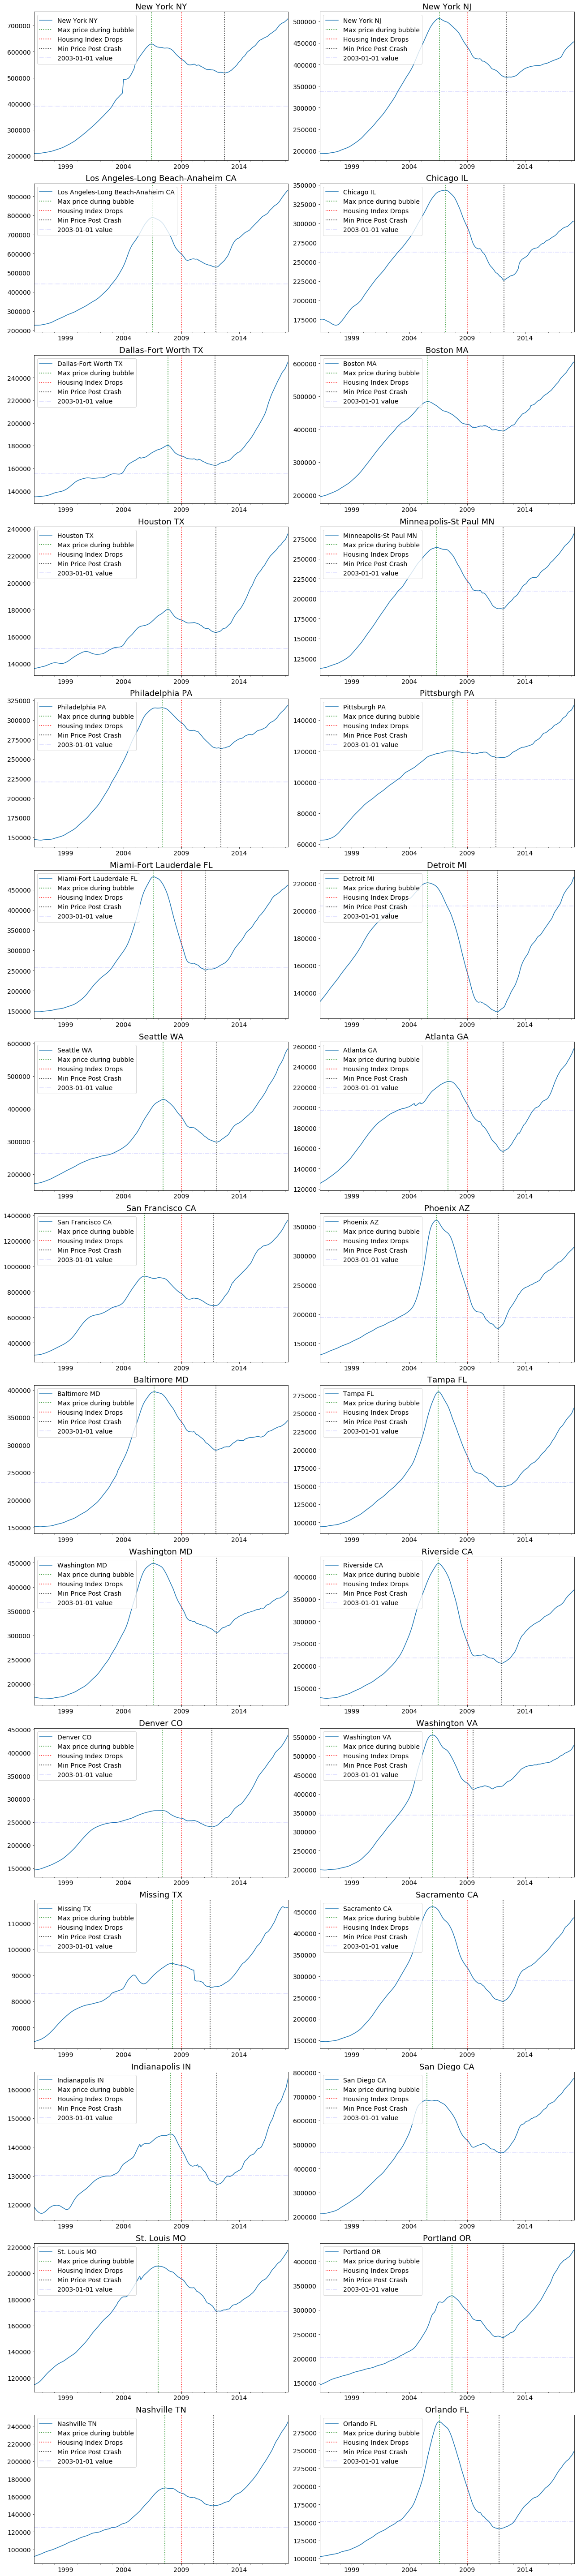

In [646]:
# Plotting top 30 metros; no standardized y-axis

fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30, figsize = (18, 80), nrows = 15, 
                         ncols = 2, set_ylim = False, fontsize1=14, fontsize2=18)

## Plotting top metro areas 6 at a time (for use in presentation)

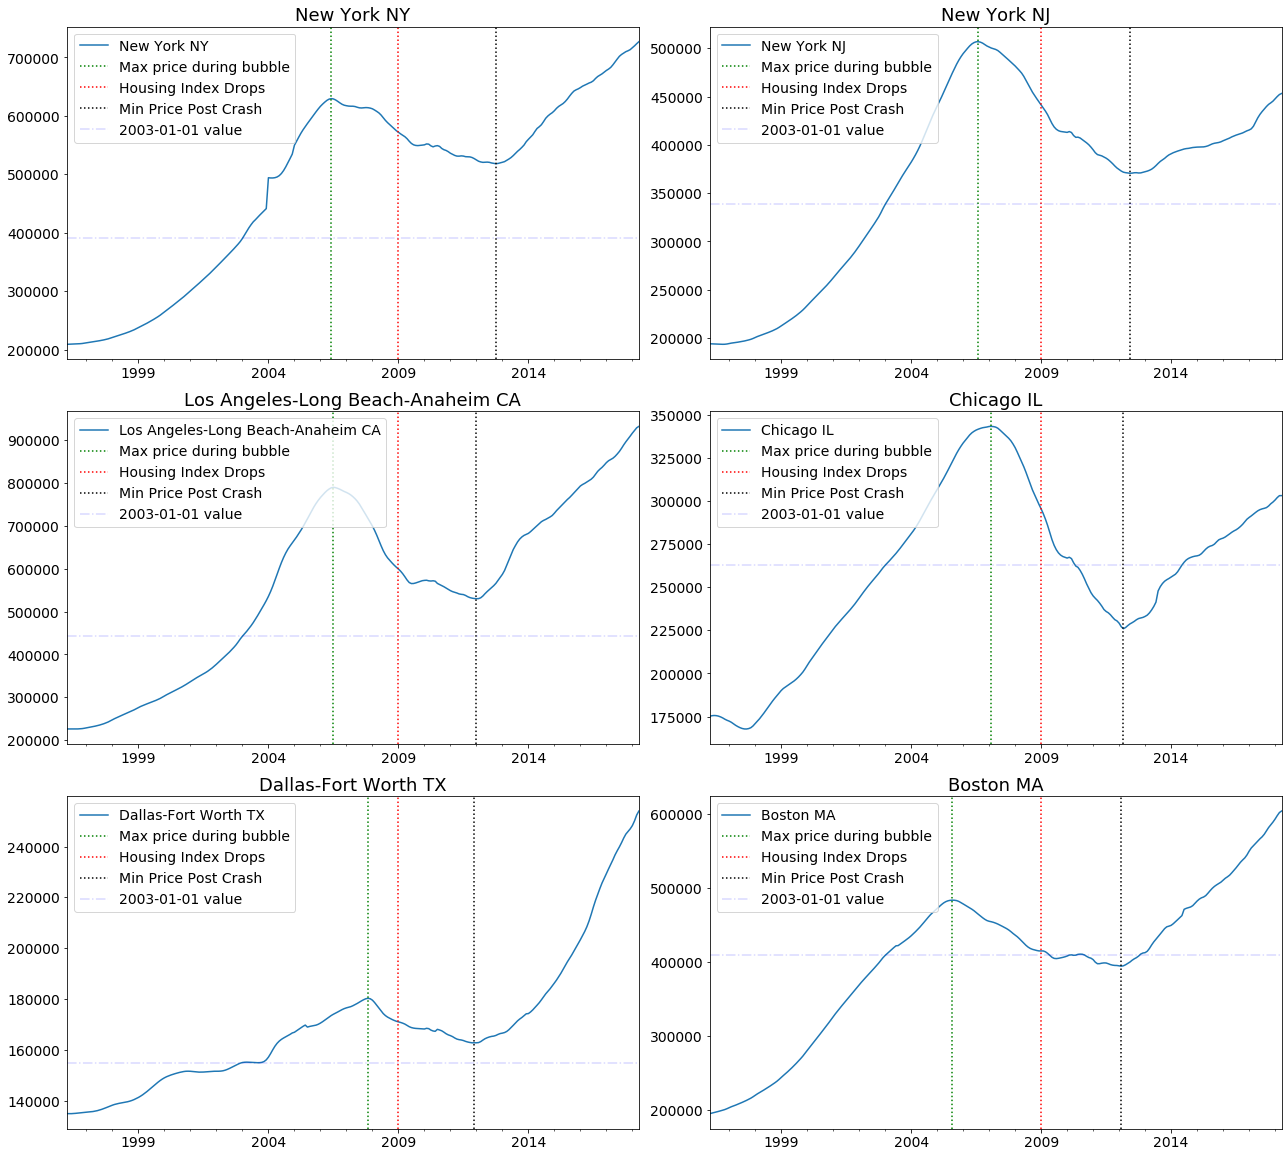

In [648]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[0:6], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


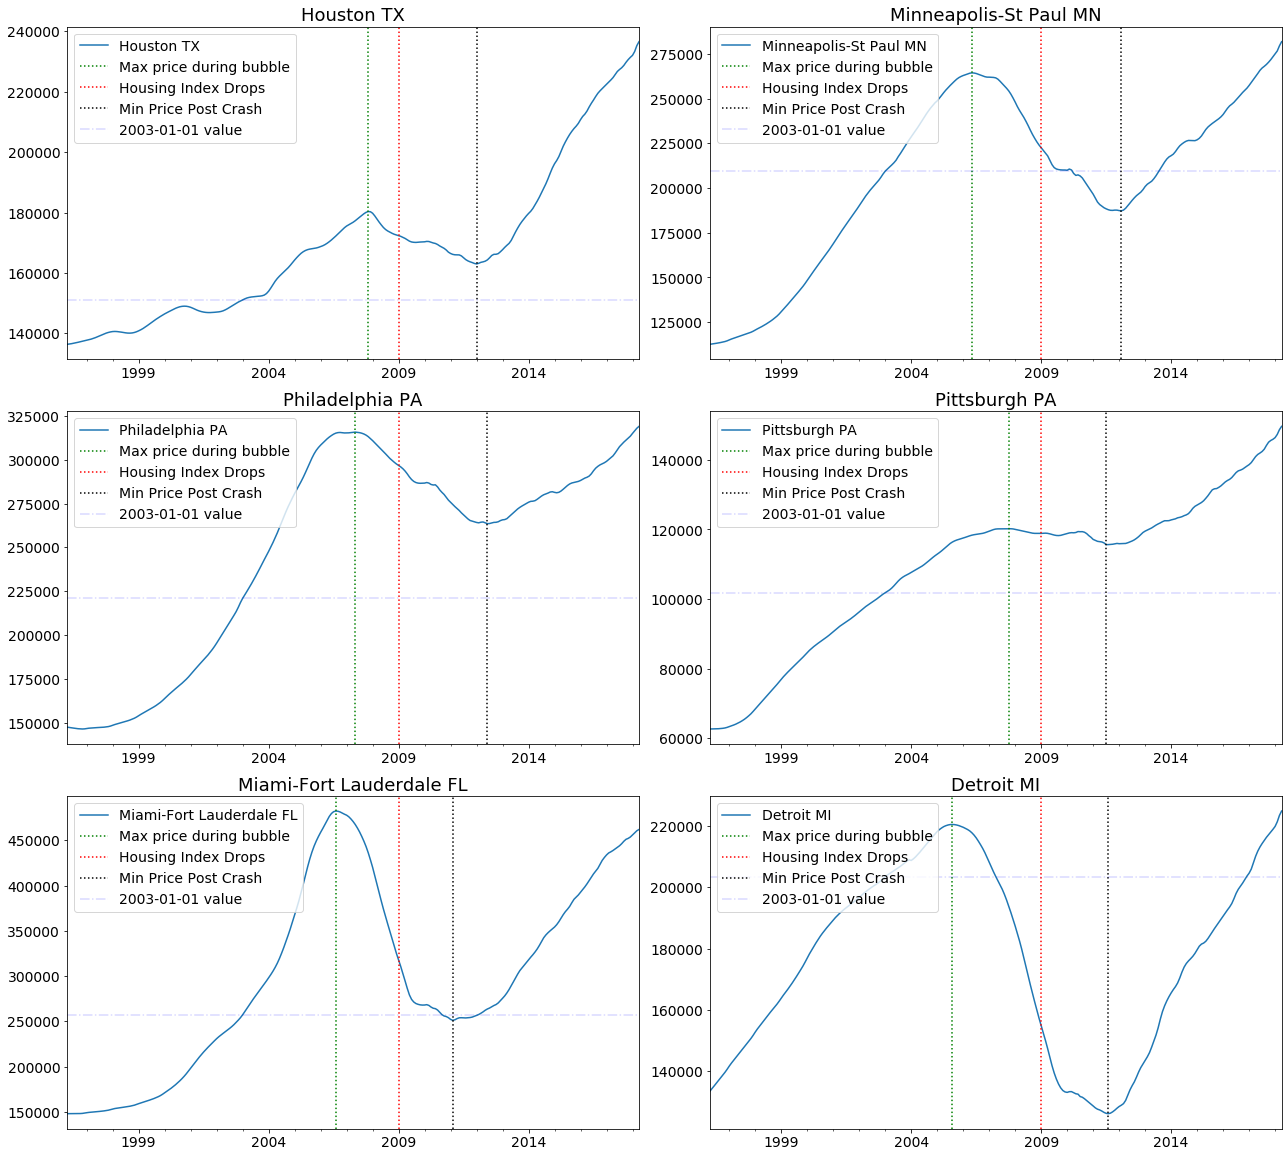

In [649]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[6:12], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


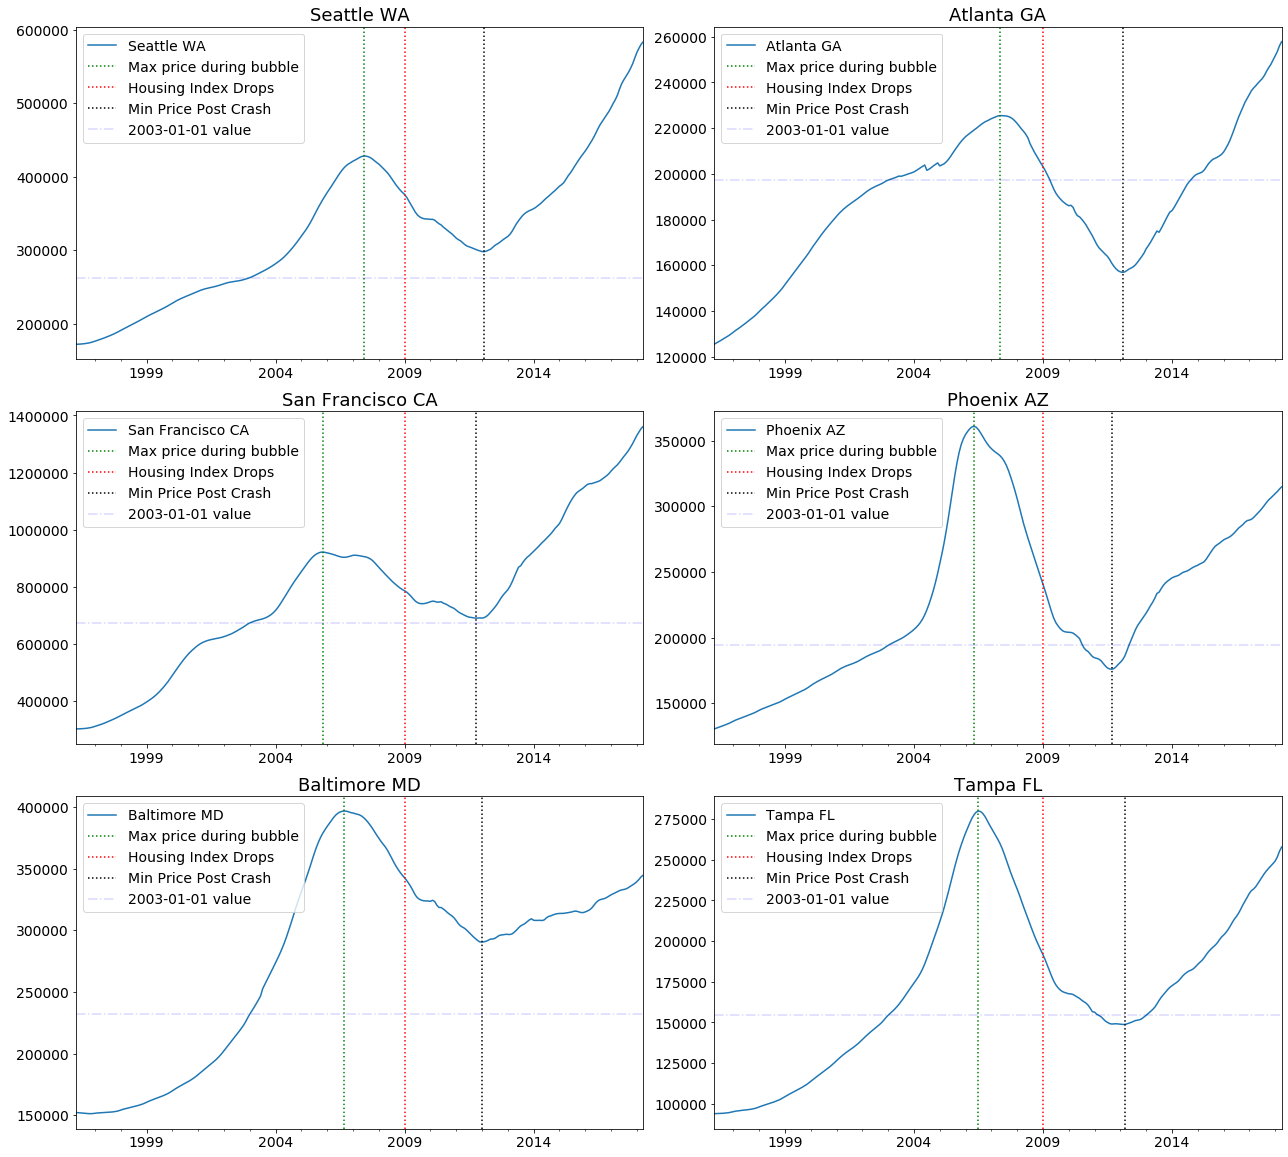

In [650]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[12:18], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


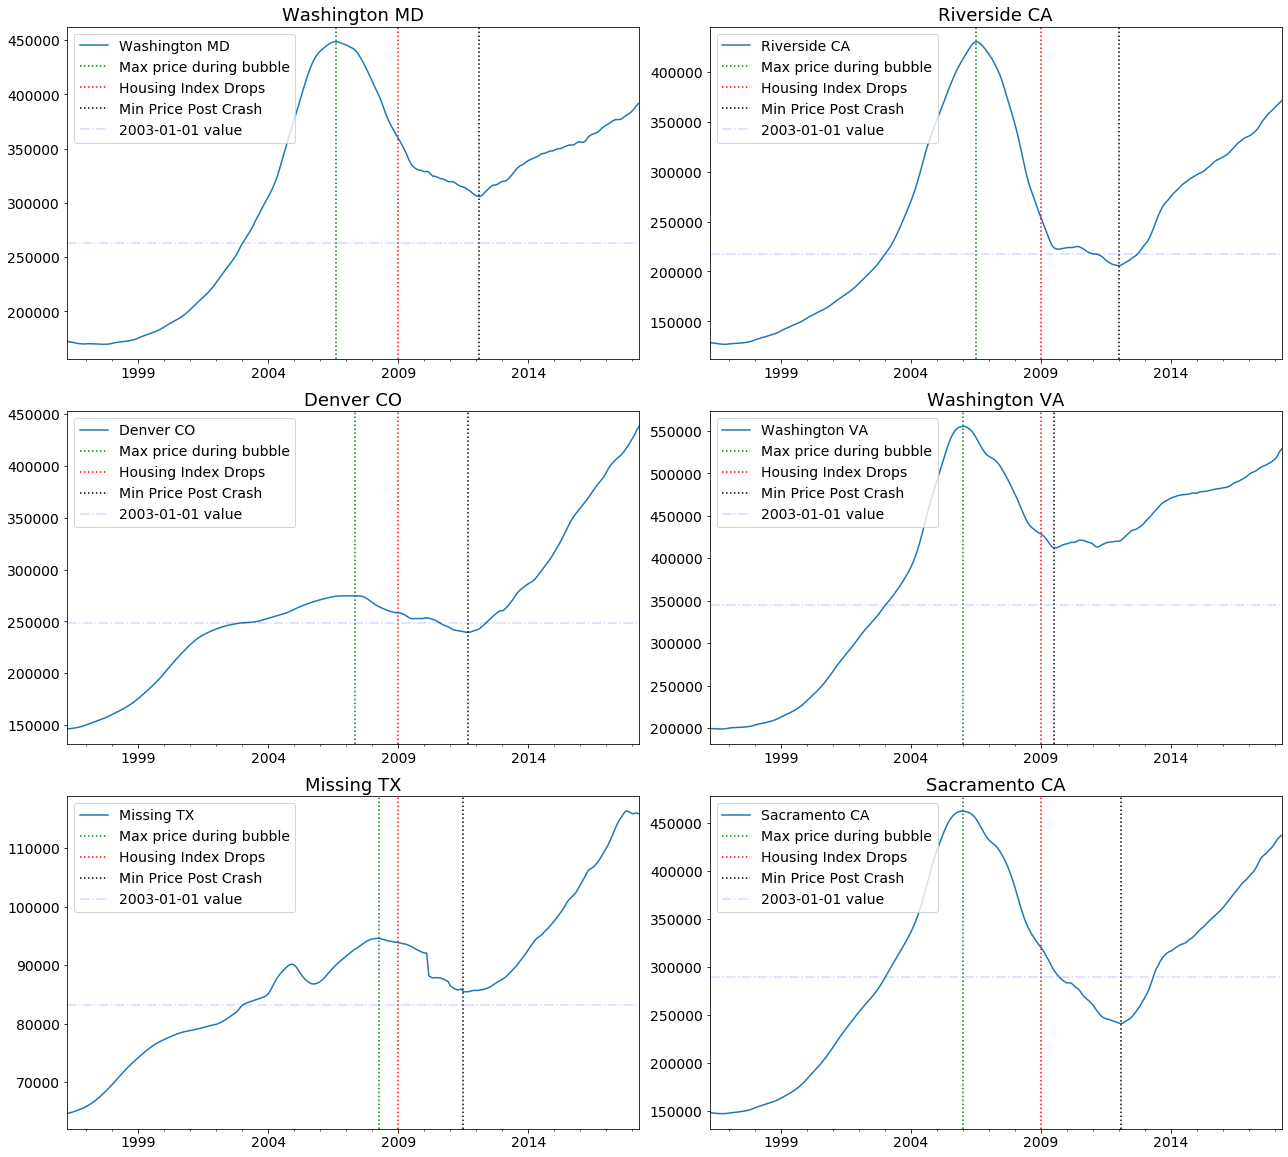

In [651]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[18:24], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


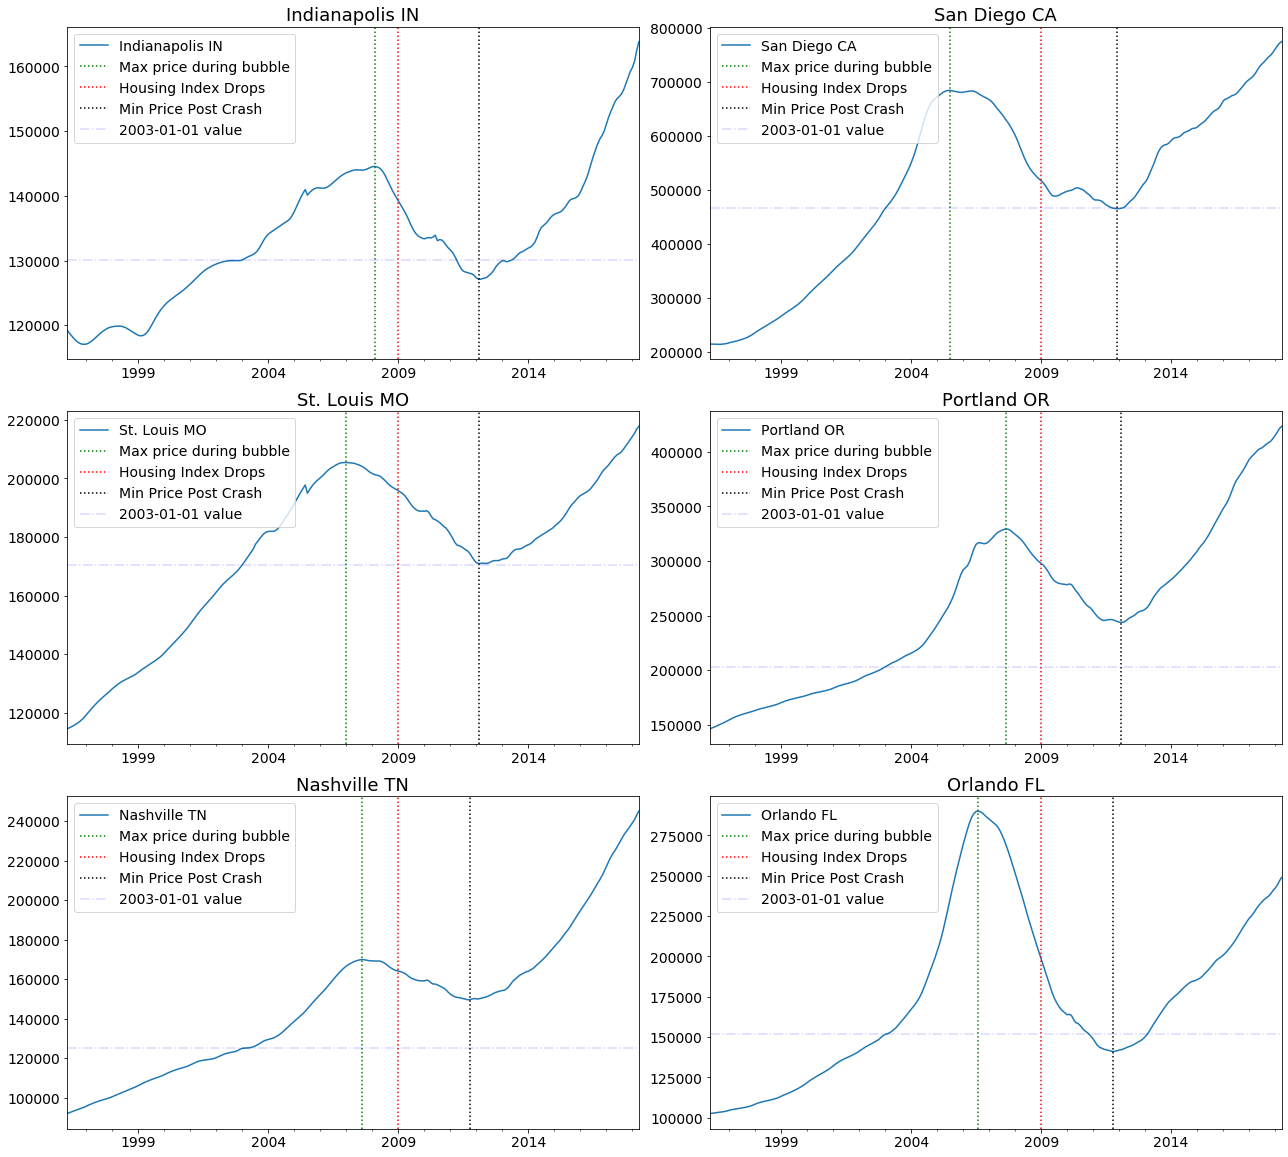

In [652]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[24:30], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


# Investment modeling by metro area (selected by curve shape and expected investment potential)

## Create empty metro lists to store results

In [615]:
#  Uncomment below to create empty lists to hold metro-level results (called by next function)

# met_geog_areas = []
# met_orders = []
# met_predicted_prices = []
# met_lower_bound_prices = [] 
# met_upper_bound_prices = []
# met_last_values = []
# met_pred_pct_changes = []
# met_lower_pct_changes = []
# met_upper_pct_changes = []


## Investment modeling:  Dallas-Fort Worth TX Metro Area 

### Create ts dataframe for *single* geographic area

In [379]:
geog_area = 'Dallas-Fort Worth TX'

In [380]:
ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [381]:
# ts_dallas = df_geog(df=df_metro_values, col = 'MetroState', geog = 'Dallas-Fort Worth TX')
ts.head()

MetroState State          value
time                                                 
1996-04-01  Dallas-Fort Worth TX    TX  134910.628019
1996-05-01  Dallas-Fort Worth TX    TX  134892.270531
1996-06-01  Dallas-Fort Worth TX    TX  134899.033816
1996-07-01  Dallas-Fort Worth TX    TX  134945.410628
1996-08-01  Dallas-Fort Worth TX    TX  135023.671498

In [382]:
ts.tail()

MetroState State          value
time                                                 
2017-12-01  Dallas-Fort Worth TX    TX  246936.405530
2018-01-01  Dallas-Fort Worth TX    TX  248237.327189
2018-02-01  Dallas-Fort Worth TX    TX  250096.774194
2018-03-01  Dallas-Fort Worth TX    TX  252404.608295
2018-04-01  Dallas-Fort Worth TX    TX  253947.465438

In [383]:
ts_values = ts['value']

In [384]:
ts_values.head()

time
1996-04-01    134910.628019
1996-05-01    134892.270531
1996-06-01    134899.033816
1996-07-01    134945.410628
1996-08-01    135023.671498
Name: value, dtype: float64

### Visualizations

#### Plot of Dallas-Fort Worth TX metro area

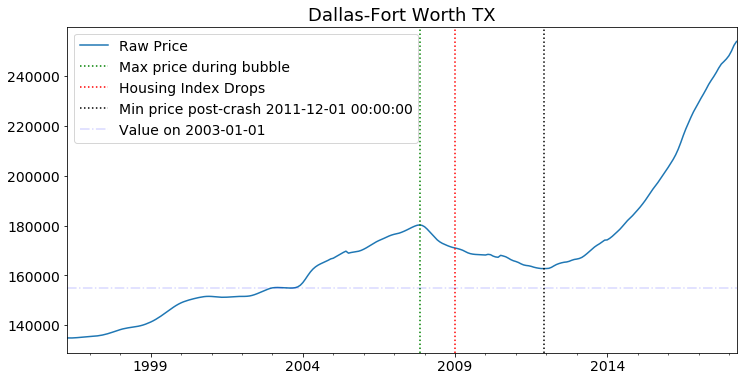

In [385]:
plot_single_geog(df_metro_values, 'Dallas-Fort Worth TX', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

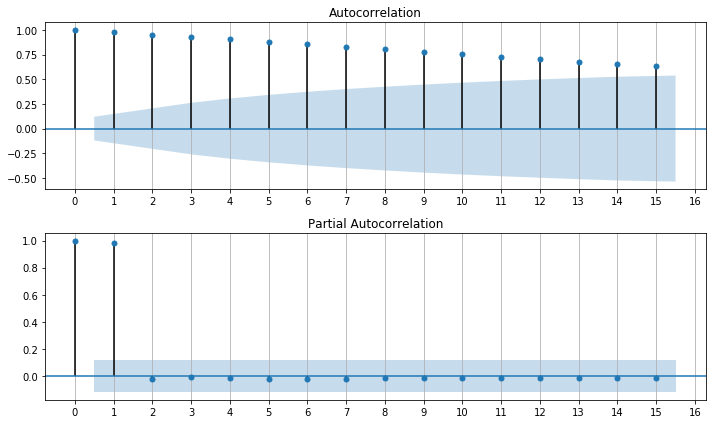

In [386]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

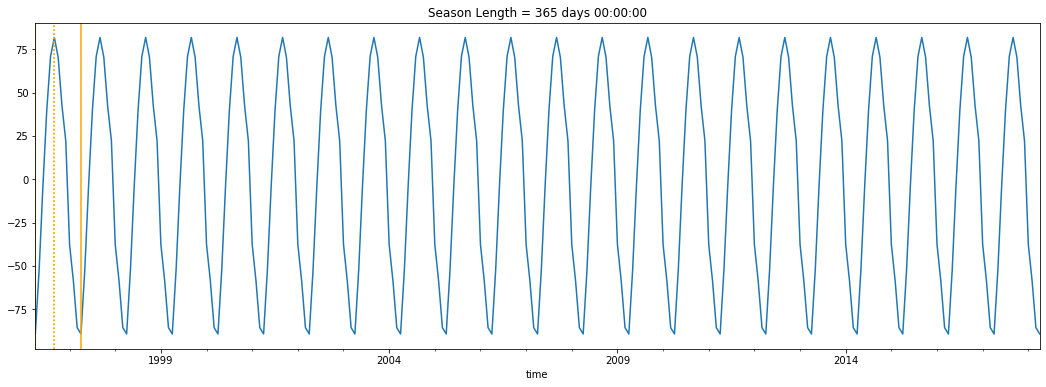

In [387]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [261]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [262]:
# eval_arima_models(ts, p_values, d_values, q_values)  # don't run this until you have some time, since it take time
# note that ts must only contain values and time as index

# eval_arima_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time


#### Generate model fit summary

In [388]:
# model_fit = arima_zipcode(ts, order = None)   # change order = tuple to correspond to the best MSE produced by previous function

model_fit = arima_zipcode(ts, order = (8,2,0))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(8, 2, 0)   Log Likelihood               -1766.841
Method:                       css-mle   S.D. of innovations            199.998
Date:                Wed, 01 Apr 2020   AIC                           3553.681
Time:                        16:20:20   BIC                           3589.403
Sample:                    06-01-1996   HQIC                          3568.037
                         - 04-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0269      8.260      0.730      0.466     -10.162      22.215
ar.L1.D2.value    -0.0313      0.062     -0.502      0.616      -0.154       0.091
ar.L2.D2.value    -0.0190      0.062

#### Produce forecasts from ARIMA model fit

In [389]:
def forecast(model_fit, months=24, confint=2):
    forecast = model_fit.forecast(months)
    actual_forecast = forecast[0]
    std_error = forecast[1]
    forecast_confint = forecast[confint]
    return actual_forecast, std_error, forecast_confint   

# actual_forecast, std_error, forecast_confint = forecast(model_fit, months=24, confint=2)


In [390]:
actual_forecast, std_error, forecast_confint = forecast(model_fit_dallas)

In [391]:
actual_forecast, std_error, forecast_confint

(array([255459.51738605, 257053.86403676, 258797.10361023, 260540.81158621,
        262155.35438135, 263602.40861049, 265108.07880797, 266763.96349418,
        268439.62597247, 270085.76722291, 271697.70456765, 273330.73239422,
        275022.60475627, 276744.28974742, 278439.73712736, 280110.28505618,
        281786.70217403, 283484.26834723, 285196.56731211, 286905.13514835,
        288605.93825565, 290312.88963415, 292036.71251424, 293773.14548958]),
 array([  199.99751345,   441.60909567,   732.0505511 ,  1050.29928213,
         1392.46580023,  1761.02641072,  2156.7902079 ,  2562.05387495,
         2964.30622594,  3369.23906752,  3782.49555034,  4208.78311702,
         4648.56331939,  5100.58015662,  5565.77305879,  6047.20786932,
         6545.78239805,  7059.97024985,  7587.84152529,  8128.16743243,
         8680.79808209,  9245.64055973,  9821.95853243, 10408.89859176]),
 array([[255067.52946268, 255851.50530942],
        [256188.326114  , 257919.40195952],
        [257362.3108

#### Create dataframe to hold forecast results

In [392]:
# df_forecast = forecast_df(col = 'time', daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'), 
#                 actual_forecast=actual_forecast, forecast_confint = forecast_confint)

df_forecast = forecast_df(col = 'time', daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'), 
                actual_forecast=actual_forecast, std_error = std_error, forecast_confint = forecast_confint)

#### Create new dataframe concatenating historic values and forecast results

In [393]:
# df_new = concat_values_forecast(ts, df_forecast)

df_new = concat_values_forecast(ts_dallas_values, df_forecast)

In [394]:
df_new

value       forecast  forecast_lower  forecast_upper  \
time                                                                       
1996-04-01  134910.628019            NaN             NaN             NaN   
1996-05-01  134892.270531            NaN             NaN             NaN   
1996-06-01  134899.033816            NaN             NaN             NaN   
1996-07-01  134945.410628            NaN             NaN             NaN   
1996-08-01  135023.671498            NaN             NaN             NaN   
1996-09-01  135120.289855            NaN             NaN             NaN   
1996-10-01  135233.333333            NaN             NaN             NaN   
1996-11-01  135334.299517            NaN             NaN             NaN   
1996-12-01  135422.705314            NaN             NaN             NaN   
1997-01-01  135492.753623            NaN             NaN             NaN   
1997-02-01  135564.734300            NaN             NaN             NaN   
1997-03-01  135635.265700            NaN             NaN             NaN   
1997-04-01  135733.816425            NaN             NaN             NaN   
1997-05-01  135882.608696            NaN             NaN             NaN   
1997-06-01  136071.980676            NaN             NaN             NaN   
1997-07-01  136308.695652            NaN             NaN             NaN   
1997-08-01  136579.710145            NaN             NaN             NaN   
1997-09-01  136887.922705            NaN             NaN             NaN   
1997-10-01  137222.222222            NaN             NaN             NaN   
1997-11-01  137567.149758            NaN             NaN             NaN   
1997-12-01  137914.009662            NaN             NaN             NaN   
1998-01-01  138238.164251            NaN             NaN             NaN   
1998-02-01  138525.120773            NaN             NaN             NaN   
1998-03-01  138755.072464            NaN             NaN             NaN   
1998-04-01  138941.545894            NaN             NaN             NaN   
1998-05-01  139097.101449            NaN             NaN             NaN   
1998-06-01  139246.859903            NaN             NaN             NaN   
1998-07-01  139401.932367            NaN             NaN             NaN   
1998-08-01  139585.024155            NaN             NaN             NaN   
1998-09-01  139814.009662            NaN             NaN             NaN   
1998-10-01  140093.719807            NaN             NaN             NaN   
1998-11-01  140441.062802            NaN             NaN             NaN   
1998-12-01  140839.613527            NaN             NaN             NaN   
1999-01-01  141285.024155            NaN             NaN             NaN   
1999-02-01  141789.855072            NaN             NaN             NaN   
1999-03-01  142353.623188            NaN             NaN             NaN   
1999-04-01  142973.429952            NaN             NaN             NaN   
1999-05-01  143644.927536            NaN             NaN             NaN   
1999-06-01  144366.183575            NaN             NaN             NaN   
1999-07-01  145100.000000            NaN             NaN             NaN   
1999-08-01  145841.062802            NaN             NaN             NaN   
1999-09-01  146560.869565            NaN             NaN             NaN   
1999-10-01  147254.589372            NaN             NaN             NaN   
1999-11-01  147910.144928            NaN             NaN             NaN   
1999-12-01  148498.067633            NaN             NaN             NaN   
2000-01-01  149005.314010            NaN             NaN             NaN   
2000-02-01  149431.400966            NaN             NaN             NaN   
2000-03-01  149789.371981            NaN             NaN             NaN   
2000-04-01  150108.212560            NaN             NaN             NaN   
2000-05-01  150391.304348            NaN             NaN             NaN   
2000-06-01  150657.004831            NaN             NaN            

#### Calculate predicted, lower bound, and upper bound forecasted prices

In [395]:
forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new)

In [396]:
forecasted_price, forecasted_lower, forecasted_upper  # predicted, best-case, and worst-case prices in 2020

(293773.14548958297, 273372.07913100213, 314174.2118481638)

In [397]:
last_value = df_new['value'].loc['2018-04-01']

In [398]:
last_value

253947.46543778802

#### Plot forecast with confidence intervals

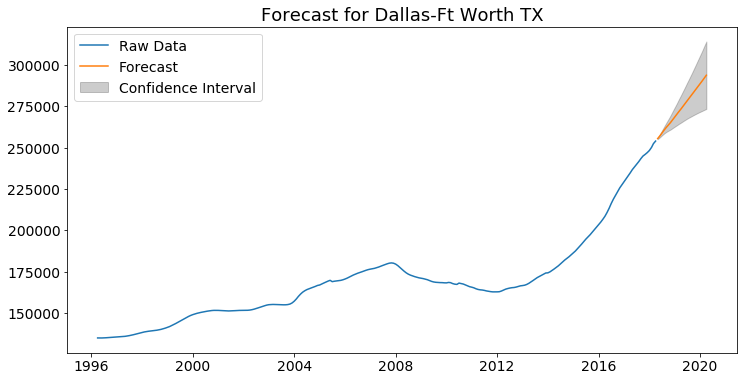

In [399]:
# plot_forecast(df_new, figsize=(12,6), geog=None)

plot_forecast(df_new, figsize=(12,6), geog_area='Dallas-Ft Worth TX')

#### Print summary of predicted, worst-case, and best-case scenarios

In [411]:
pred_best_worst(pred=forecasted_price, low=forecasted_lower, high=forecasted_upper, last=last_value)

By the model prediction, I would expect to see a 15.683% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 7.649% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.716% change in price by April 1, 2020.


(15.683, 7.649, 23.716)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function with parameter-tuning, model fit, and forecasting operations

In [401]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function model fit function only (no parameter tuning)

For Dallas-Fort Worth TX:
Best ARIMA order = (8, 2, 0)
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(8, 2, 0)   Log Likelihood               -1766.841
Method:                       css-mle   S.D. of innovations            199.998
Date:                Wed, 01 Apr 2020   AIC                           3553.681
Time:                        16:23:13   BIC                           3589.403
Sample:                    06-01-1996   HQIC                          3568.037
                         - 04-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0269      8.260      0.730      0.466     -10.162      22.215
ar.L1.D2.value    -0.0313      0.062     -0.502      0.616      

(['Dallas-Fort Worth TX'],
 [(8, 2, 0)],
 [293773.15],
 [273372.08],
 [314174.21],
 [253947.46543778802],
 [15.68],
 [7.65],
 [23.72])

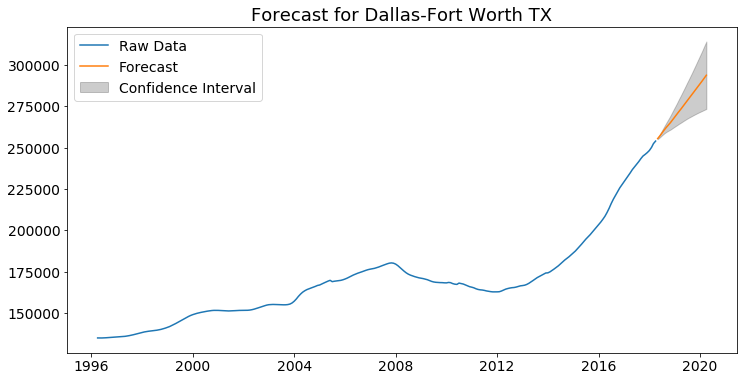

In [412]:
arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (8,2,0), confint=2)


### RESULTS--Dallas-Ft Worth TX:  Excellent investment opportunity, with even the worst-case scenario generating positive returns

By the model prediction, I would expect to see a 15.683% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 7.649% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.716% change in price by April 1, 2020.

In [ ]:
# print_metro_results_lists()

## Investment modeling:  Los Angeles-Long Beach-Anaheim CA 


### Create ts dataframe for *single* geographic area

In [955]:
geog_area = 'Los Angeles-Long Beach-Anaheim CA'

In [956]:
ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [957]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Los Angeles-Long Beach-Anaheim CA')
ts.head()

MetroState State          value
time                                                              
1996-04-01  Los Angeles-Long Beach-Anaheim CA    CA  226259.011628
1996-05-01  Los Angeles-Long Beach-Anaheim CA    CA  226251.744186
1996-06-01  Los Angeles-Long Beach-Anaheim CA    CA  226225.872093
1996-07-01  Los Angeles-Long Beach-Anaheim CA    CA  226197.674419
1996-08-01  Los Angeles-Long Beach-Anaheim CA    CA  226229.941860

In [958]:
ts.tail()

MetroState State          value
time                                                              
2017-12-01  Los Angeles-Long Beach-Anaheim CA    CA  908959.077810
2018-01-01  Los Angeles-Long Beach-Anaheim CA    CA  915871.181556
2018-02-01  Los Angeles-Long Beach-Anaheim CA    CA  922182.708934
2018-03-01  Los Angeles-Long Beach-Anaheim CA    CA  928302.593660
2018-04-01  Los Angeles-Long Beach-Anaheim CA    CA  931603.170029

In [959]:
ts_values = ts['value']

In [960]:
ts_values.head()

time
1996-04-01    226259.011628
1996-05-01    226251.744186
1996-06-01    226225.872093
1996-07-01    226197.674419
1996-08-01    226229.941860
Name: value, dtype: float64

### Visualizations

#### Plot of Los Angeles-Long Beach-Anaheim CA

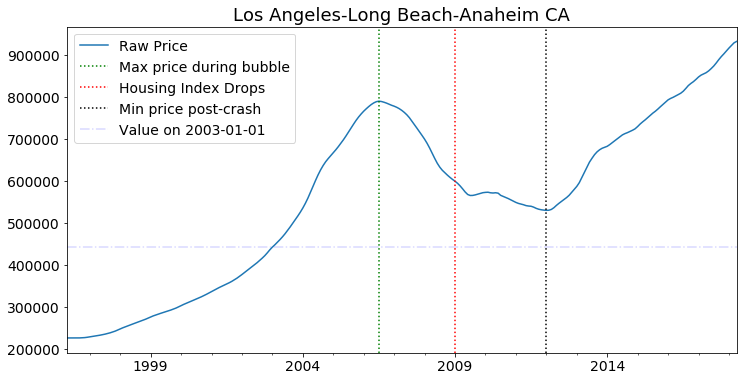

In [961]:
plot_single_geog(df_metro_values, 'Los Angeles-Long Beach-Anaheim CA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

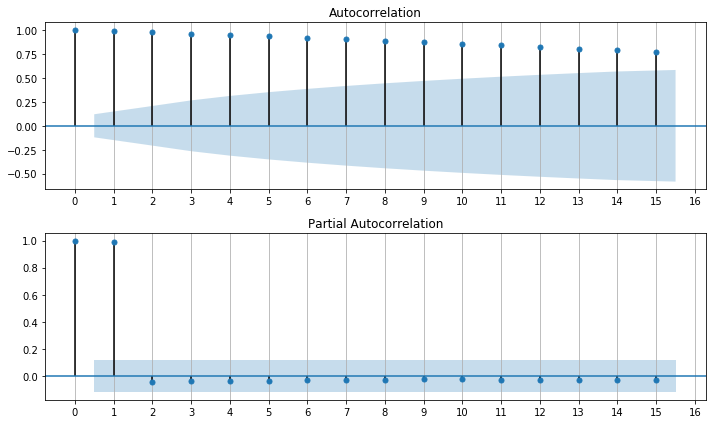

In [420]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

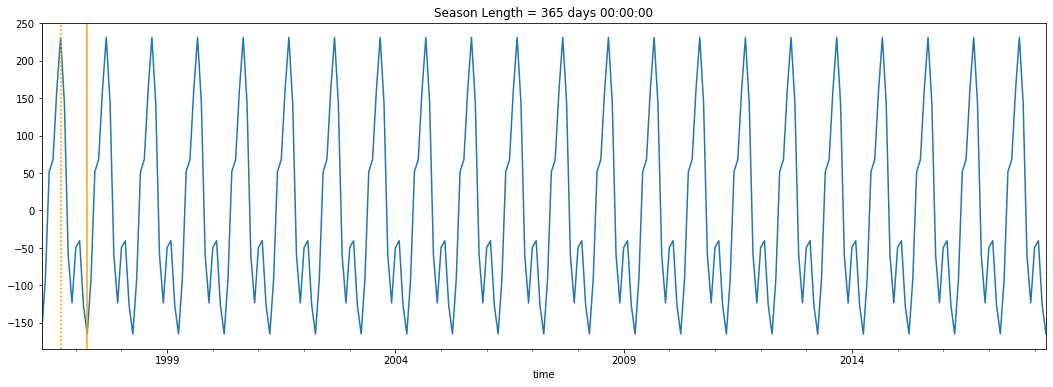

In [421]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [358]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [360]:
# evaluate_models(dataset, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Los Angeles-Long Beach-Anaheim CA:
# ARIMA(0, 0, 0) MSE=48139455154.043
# ARIMA(0, 0, 1) MSE=12352681660.520
# ARIMA(0, 1, 0) MSE=15349543.151
# ARIMA(0, 1, 1) MSE=5508298.196
# ARIMA(0, 2, 0) MSE=1121329.101
# ARIMA(0, 2, 1) MSE=835852.984
# ARIMA(0, 2, 2) MSE=831636.386
# ARIMA(1, 0, 0) MSE=29157899.445
# ARIMA(1, 1, 0) MSE=1105368.105
# ARIMA(1, 1, 1) MSE=816213.975
# ARIMA(1, 1, 2) MSE=806615.089
# ARIMA(1, 2, 0) MSE=902825.145
# ARIMA(1, 2, 1) MSE=842351.597
# ARIMA(2, 0, 1) MSE=846208.718
# ARIMA(2, 0, 2) MSE=833884.348
# ARIMA(2, 1, 0) MSE=872079.363
# ARIMA(2, 1, 1) MSE=820881.338
# ARIMA(2, 2, 0) MSE=856423.188
# ARIMA(2, 2, 1) MSE=847997.553
# ARIMA(4, 0, 1) MSE=868461.308
# ARIMA(4, 0, 2) MSE=1101980.440
# ARIMA(4, 1, 1) MSE=857636.680
# ARIMA(4, 2, 0) MSE=864570.074
# ARIMA(6, 0, 1) MSE=897784.434
# ARIMA(6, 0, 2) MSE=1229336.509
# Best ARIMA(1, 1, 2) MSE=806615.089
# Best ARIMA order = (1, 1, 2)

#### Plot forecast with confidence intervals

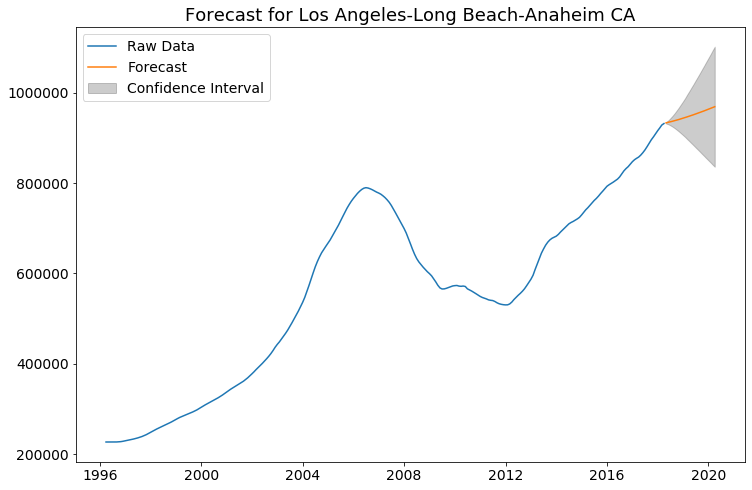

In [433]:
# plot_forecast(df_new, figsize=(12,8), geog=None)

plot_forecast(df_new, figsize=(12,8), geog_area='Los Angeles-Long Beach-Anaheim CA')

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function with parameter-tuning, model fit, and forecasting operations

In [435]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function WITHOUT parameter-tuning, but entering pdq to get model fit and forecasts

For Los Angeles-Long Beach-Anaheim CA:
Best ARIMA order = (1, 1, 2)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2131.575
Method:                       css-mle   S.D. of innovations            770.879
Date:                Wed, 01 Apr 2020   AIC                           4273.150
Time:                        18:22:23   BIC                           4291.030
Sample:                    05-01-1996   HQIC                          4280.335
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2376.6648   1886.501      1.260      0.209   -1320.808    6074.138
ar.L1.D.value     0.9581      0.017     55.828      0.

(['Dallas-Fort Worth TX', 'Los Angeles-Long Beach-Anaheim CA'],
 [(8, 2, 0), (1, 1, 2)],
 [293773.15, 968850.81],
 [273372.08, 835905.83],
 [314174.21, 1101795.8],
 [253947.46543778802, 931603.1700288184],
 [15.68, 4.0],
 [7.65, -10.27],
 [23.72, 18.27])

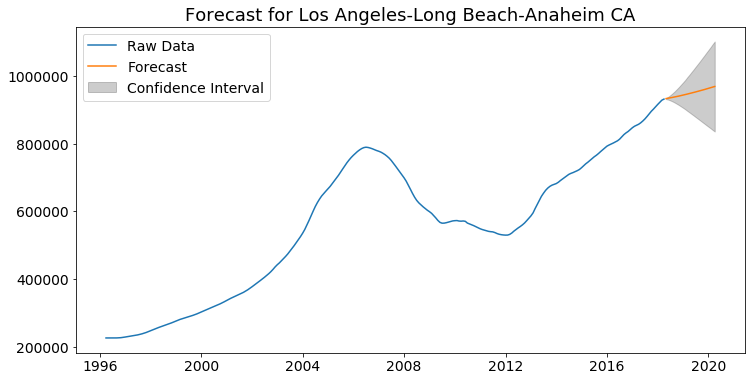

In [483]:
arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,2), confint=2)


### RESULTS--Los Angeles-Long Beach-Anaheim CA:  Mediocre opportunity, but with relatively limited downside and some good potential upside

By the model prediction, I would expect to see a 3.998% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -10.272% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 18.269% change in price by April 1, 2020.

In [484]:
print_metro_results_lists()

(['Dallas-Fort Worth TX', 'Los Angeles-Long Beach-Anaheim CA'],
 [(8, 2, 0), (1, 1, 2)],
 [293773.15, 968850.81],
 [273372.08, 835905.83],
 [314174.21, 1101795.8],
 [253947.46543778802, 931603.1700288184],
 [15.68, 4.0],
 [7.65, -10.27],
 [23.72, 18.27])

In [485]:
# pop_metro_results_lists()

## Investment modeling:   Boston, MA

### Create ts dataframe for *single* geographic area

In [962]:
geog_area = 'Boston MA'

In [963]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [964]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Boston MA')
ts.head()

MetroState State          value
time                                      
1996-04-01  Boston MA    MA  194741.025641
1996-05-01  Boston MA    MA  195468.717949
1996-06-01  Boston MA    MA  196216.410256
1996-07-01  Boston MA    MA  196976.410256
1996-08-01  Boston MA    MA  197749.230769

In [965]:
ts.tail()

MetroState State          value
time                                      
2017-12-01  Boston MA    MA  589422.222222
2018-01-01  Boston MA    MA  593584.848485
2018-02-01  Boston MA    MA  598262.626263
2018-03-01  Boston MA    MA  602428.787879
2018-04-01  Boston MA    MA  604409.595960

In [966]:
ts_values = ts['value']

In [967]:
ts_values.head()

time
1996-04-01    194741.025641
1996-05-01    195468.717949
1996-06-01    196216.410256
1996-07-01    196976.410256
1996-08-01    197749.230769
Name: value, dtype: float64

### Visualizations

#### Plot of Boston MA

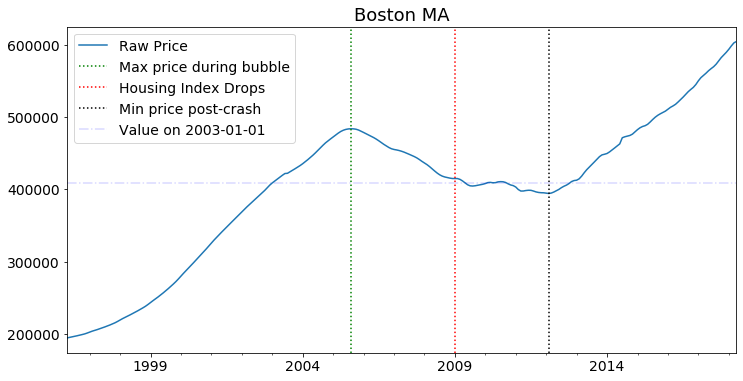

In [968]:
plot_single_geog(df_metro_values, 'Boston MA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

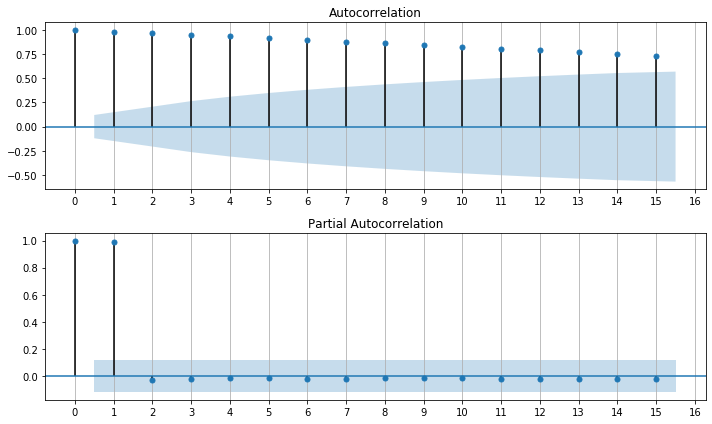

In [448]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

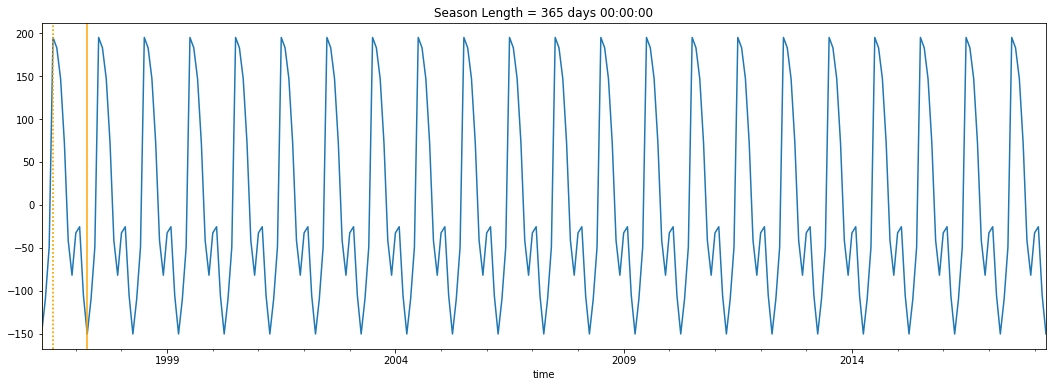

In [449]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [450]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [453]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# ARIMA(0, 0, 0) MSE=12013226317.318
# ARIMA(0, 0, 1) MSE=3079645920.375
# ARIMA(0, 1, 0) MSE=4138316.227
# ARIMA(0, 1, 1) MSE=2670990.042
# ARIMA(0, 2, 0) MSE=1538381.661
# ARIMA(0, 2, 1) MSE=2036028.981
# ARIMA(0, 2, 2) MSE=1885850.208
# ARIMA(1, 0, 0) MSE=8160308.639
# ARIMA(1, 1, 0) MSE=1495110.660
# ARIMA(1, 1, 1) MSE=1947708.067
# ARIMA(1, 1, 2) MSE=1864001.145
# ARIMA(1, 2, 0) MSE=1888447.564
# ARIMA(1, 2, 1) MSE=1927201.816
# ARIMA(2, 0, 1) MSE=1999977.140
# ARIMA(2, 0, 2) MSE=1862445.615
# ARIMA(2, 1, 0) MSE=1818956.663
# ARIMA(2, 1, 1) MSE=1882766.194
# ARIMA(2, 2, 0) MSE=1930276.664
# ARIMA(4, 0, 0) MSE=1920955.311
# ARIMA(4, 0, 1) MSE=1916776.584
# ARIMA(4, 1, 0) MSE=1864262.805
# ARIMA(4, 1, 1) MSE=1859584.966
# ARIMA(4, 2, 0) MSE=1908330.794
# ARIMA(6, 0, 0) MSE=1929110.597
# ARIMA(6, 0, 1) MSE=1924059.994
# ARIMA(6, 1, 0) MSE=1893518.085
# ARIMA(6, 1, 1) MSE=1905196.107
# ARIMA(6, 2, 0) MSE=1959953.659
# ARIMA(6, 2, 1) MSE=1980492.238
# ARIMA(8, 0, 0) MSE=1967632.517
# ARIMA(8, 0, 1) MSE=2015155.324
# ARIMA(8, 1, 0) MSE=1962695.689
# ARIMA(8, 1, 1) MSE=1984240.398
# ARIMA(8, 2, 0) MSE=2031962.376
# ARIMA(8, 2, 1) MSE=2030729.477
# Best ARIMA(1, 1, 0) MSE=1495110.660

# ((1, 1, 0), 1495110.6598385233)

ARIMA(0, 0, 0) MSE=12013226317.318
ARIMA(0, 0, 1) MSE=3079645920.375
ARIMA(0, 1, 0) MSE=4138316.227
ARIMA(0, 1, 1) MSE=2670990.042
ARIMA(0, 2, 0) MSE=1538381.661
ARIMA(0, 2, 1) MSE=2036028.981
ARIMA(0, 2, 2) MSE=1885850.208
ARIMA(1, 0, 0) MSE=8160308.639
ARIMA(1, 1, 0) MSE=1495110.660
ARIMA(1, 1, 1) MSE=1947708.067
ARIMA(1, 1, 2) MSE=1864001.145
ARIMA(1, 2, 0) MSE=1888447.564
ARIMA(1, 2, 1) MSE=1927201.816
ARIMA(2, 0, 1) MSE=1999977.140
ARIMA(2, 0, 2) MSE=1862445.615
ARIMA(2, 1, 0) MSE=1818956.663
ARIMA(2, 1, 1) MSE=1882766.194
ARIMA(2, 2, 0) MSE=1930276.664
ARIMA(4, 0, 0) MSE=1920955.311
ARIMA(4, 0, 1) MSE=1916776.584
ARIMA(4, 1, 0) MSE=1864262.805
ARIMA(4, 1, 1) MSE=1859584.966
ARIMA(4, 2, 0) MSE=1908330.794
ARIMA(6, 0, 0) MSE=1929110.597
ARIMA(6, 0, 1) MSE=1924059.994
ARIMA(6, 1, 0) MSE=1893518.085
ARIMA(6, 1, 1) MSE=1905196.107
ARIMA(6, 2, 0) MSE=1959953.659
ARIMA(6, 2, 1) MSE=1980492.238
ARIMA(8, 0, 0) MSE=1967632.517
ARIMA(8, 0, 1) MSE=2015155.324
ARIMA(8, 1, 0) MSE=1962695.689
A

((1, 1, 0), 1495110.6598385233)

In [492]:
# pop_metro_results_lists()

#### ARIMA modeling results:  predictions and visualization

-- Run one OR the other of the two functions below

##### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

In [463]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

##### Run ARIMA function WITHOUT parameter-tuning, model fit, and forecasting operations

For Boston MA:
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2132.457
Method:                       css-mle   S.D. of innovations            776.582
Date:                Wed, 01 Apr 2020   AIC                           4270.914
Time:                        18:22:54   BIC                           4281.642
Sample:                    05-01-1996   HQIC                          4275.225
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1536.0834    603.767      2.544      0.012     352.721    2719.446
ar.L1.D.value     0.9243      0.023     41.013      0.000       0.880       0.

(['Dallas-Fort Worth TX', 'Los Angeles-Long Beach-Anaheim CA', 'Boston MA'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0)],
 [293773.15, 968850.81, 645882.95],
 [273372.08, 835905.83, 585569.59],
 [314174.21, 1101795.8, 706196.32],
 [253947.46543778802, 931603.1700288184, 604409.595959596],
 [15.68, 4.0, 6.86],
 [7.65, -10.27, -3.12],
 [23.72, 18.27, 16.84])

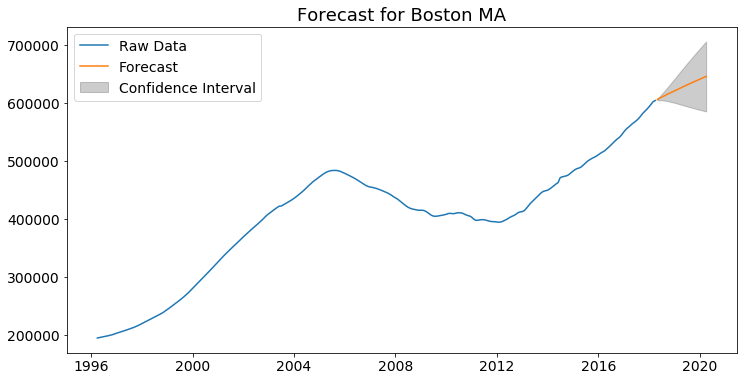

In [493]:
arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,0), confint=2)


### RESULTS--Boston, MA:  Good investment opportunity with significant upside and very limited downside

By the model prediction, I would expect to see a 6.862% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -3.117% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 16.841% change in price by April 1, 2020.


In [494]:
print_metro_results_lists()

(['Dallas-Fort Worth TX', 'Los Angeles-Long Beach-Anaheim CA', 'Boston MA'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0)],
 [293773.15, 968850.81, 645882.95],
 [273372.08, 835905.83, 585569.59],
 [314174.21, 1101795.8, 706196.32],
 [253947.46543778802, 931603.1700288184, 604409.595959596],
 [15.68, 4.0, 6.86],
 [7.65, -10.27, -3.12],
 [23.72, 18.27, 16.84])

## Investment modeling:   Pittsburgh, PA


### Create ts dataframe for *single* geographic area

In [1010]:
geog_area = 'Pittsburgh PA'

In [1011]:
ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [1012]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Pittsburgh PA')
ts.head()

MetroState State         value
time                                         
1996-04-01  Pittsburgh PA    PA  62613.872832
1996-05-01  Pittsburgh PA    PA  62631.791908
1996-06-01  Pittsburgh PA    PA  62646.242775
1996-07-01  Pittsburgh PA    PA  62658.959538
1996-08-01  Pittsburgh PA    PA  62689.595376

In [1013]:
ts.tail()

MetroState State          value
time                                          
2017-12-01  Pittsburgh PA    PA  145931.073446
2018-01-01  Pittsburgh PA    PA  146412.429379
2018-02-01  Pittsburgh PA    PA  147336.158192
2018-03-01  Pittsburgh PA    PA  148701.694915
2018-04-01  Pittsburgh PA    PA  149648.022599

In [1014]:
ts_values = ts['value']

In [1015]:
ts_values.head()

time
1996-04-01    62613.872832
1996-05-01    62631.791908
1996-06-01    62646.242775
1996-07-01    62658.959538
1996-08-01    62689.595376
Name: value, dtype: float64

### Visualizations

#### Plot of Pittsburgh PA

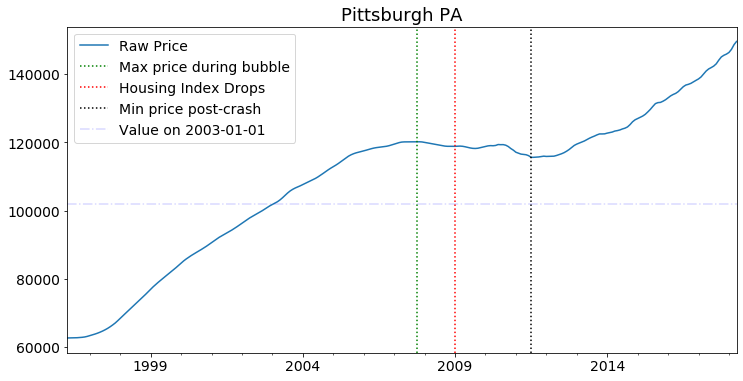

In [1016]:
plot_single_geog(df_metro_values, 'Pittsburgh PA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

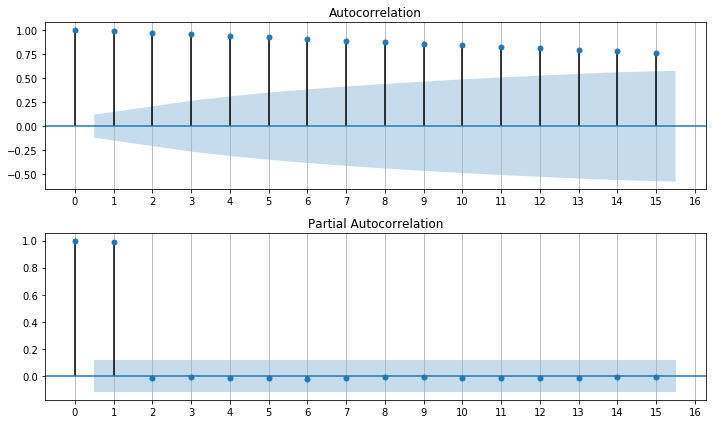

In [502]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

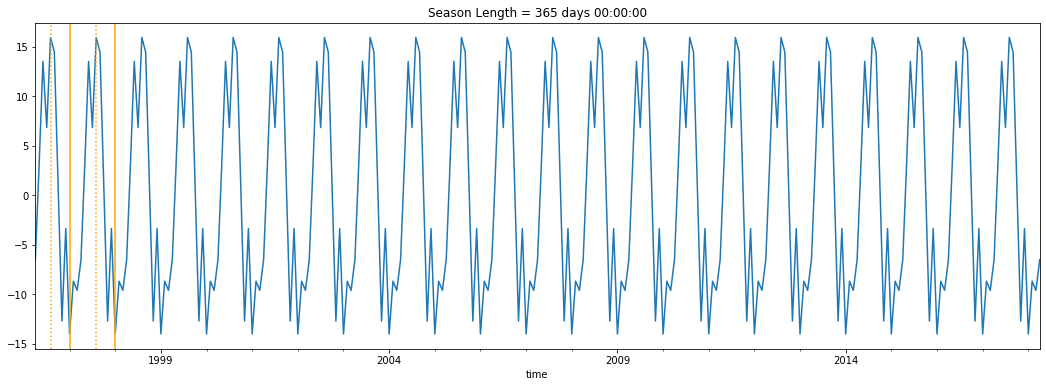

In [503]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [504]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [505]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time


# For Pittsburgh PA:
# ARIMA(0, 0, 0) MSE=618388785.597
# ARIMA(0, 0, 1) MSE=156957534.507
# ARIMA(0, 1, 0) MSE=132218.692
# ARIMA(0, 1, 1) MSE=63249.110
# ARIMA(0, 2, 0) MSE=36196.526
# ARIMA(0, 2, 1) MSE=34031.148
# ARIMA(0, 2, 2) MSE=34944.722
# ARIMA(1, 0, 0) MSE=243227.980
# ARIMA(1, 1, 0) MSE=35167.159
# ARIMA(1, 1, 1) MSE=31957.270
# ARIMA(1, 1, 2) MSE=33097.909
# ARIMA(1, 2, 0) MSE=35849.293
# ARIMA(1, 2, 1) MSE=34999.189
# ARIMA(1, 2, 2) MSE=33662.702
# ARIMA(2, 0, 0) MSE=35998.424
# ARIMA(2, 1, 0) MSE=33736.509
# ARIMA(2, 2, 0) MSE=31479.402
# ARIMA(2, 2, 1) MSE=29561.683
# ARIMA(4, 0, 0) MSE=39286.374
# ARIMA(4, 1, 0) MSE=29968.628
# ARIMA(4, 2, 0) MSE=30473.058
# ARIMA(4, 2, 1) MSE=32265.259
# ARIMA(4, 2, 2) MSE=28543.256
# ARIMA(6, 0, 0) MSE=30779.054
# ARIMA(6, 0, 1) MSE=32036.967
# ARIMA(6, 0, 2) MSE=29599.860
# ARIMA(6, 1, 0) MSE=30601.349
# ARIMA(6, 2, 0) MSE=28199.982
# ARIMA(8, 0, 0) MSE=29097.280
# ARIMA(8, 2, 0) MSE=24880.481
# ARIMA(10, 0, 0) MSE=25732.443
# ARIMA(10, 2, 0) MSE=26033.379
# Best ARIMA(8, 2, 0) MSE=24880.481
# Best ARIMA order = (8, 2, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function with parameter-tuning, model fit, and forecasting operations

For Pittsburgh PA:
ARIMA(0, 0, 0) MSE=618388785.597
ARIMA(0, 0, 1) MSE=156957534.507
ARIMA(0, 1, 0) MSE=132218.692
ARIMA(0, 1, 1) MSE=63249.110
ARIMA(0, 2, 0) MSE=36196.526
ARIMA(0, 2, 1) MSE=34031.148
ARIMA(0, 2, 2) MSE=34944.722
ARIMA(1, 0, 0) MSE=243227.980
ARIMA(1, 1, 0) MSE=35167.159
ARIMA(1, 1, 1) MSE=31957.270
ARIMA(1, 1, 2) MSE=33097.909
ARIMA(1, 2, 0) MSE=35849.293
ARIMA(1, 2, 1) MSE=34999.189
ARIMA(1, 2, 2) MSE=33662.702
ARIMA(2, 0, 0) MSE=35998.424
ARIMA(2, 1, 0) MSE=33736.509
ARIMA(2, 2, 0) MSE=31479.402
ARIMA(2, 2, 1) MSE=29561.683
ARIMA(4, 0, 0) MSE=39286.374
ARIMA(4, 1, 0) MSE=29968.628
ARIMA(4, 2, 0) MSE=30473.058
ARIMA(4, 2, 1) MSE=32265.259
ARIMA(4, 2, 2) MSE=28543.256
ARIMA(6, 0, 0) MSE=30779.054
ARIMA(6, 0, 1) MSE=32036.967
ARIMA(6, 0, 2) MSE=29599.860
ARIMA(6, 1, 0) MSE=30601.349
ARIMA(6, 2, 0) MSE=28199.982
ARIMA(8, 0, 0) MSE=29097.280
ARIMA(8, 2, 0) MSE=24880.481
ARIMA(10, 0, 0) MSE=25732.443
ARIMA(10, 2, 0) MSE=26033.379
Best ARIMA(8, 2, 0) MSE=24880.481
Best AR

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 0),
  (2, 1, 0),
  (2, 2, 0),
  (2, 2, 1),
  (4, 0, 0),
  (4, 1, 0),
  (4, 2, 0),
  (4, 2, 1),
  (4, 2, 2),
  (6, 0, 0),
  (6, 0, 1),
  (6, 0, 2),
  (6, 1, 0),
  (6, 2, 0),
  (8, 0, 0),
  (8, 2, 0),
  (10, 0, 0),
  (10, 2, 0)],
 [618388785.596511,
  156957534.5068155,
  132218.69203583128,
  63249.110411063004,
  36196.52611052032,
  34031.14802113152,
  34944.722101283165,
  243227.98030391373,
  35167.15938826089,
  31957.26995566141,
  33097.90862481334,
  35849.29342276952,
  34999.18871160692,
  33662.70237045889,
  35998.42376458525,
  33736.50895866956,
  31479.402374343732,
  29561.683203518896,
  39286.37353406608,
  29968.627733796206,
  30473.058385879936,
  32265.259232844615,
  28543.25624437071,
  30779.053983552272,
  32036.966791951956,
  29599.860268767483,
  30601.349199092976,
  

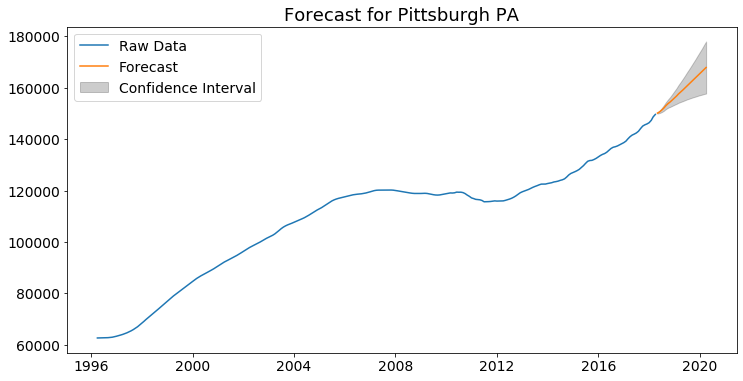

In [506]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [507]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--Pittsburgh PA:   Excellent investment potential

By the model prediction, I would expect to see a 12.204% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 5.435% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 18.973% change in price by April 1, 2020.


In [508]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0), (8, 2, 0)],
 [293773.15, 968850.81, 645882.95, 167911.06],
 [273372.08, 835905.83, 585569.59, 157781.43],
 [314174.21, 1101795.8, 706196.32, 178040.7],
 [253947.46543778802, 931603.1700288184, 604409.595959596, 149648.02259887007],
 [15.68, 4.0, 6.86, 12.2],
 [7.65, -10.27, -3.12, 5.44],
 [23.72, 18.27, 16.84, 18.97])

## Investment modeling:   Atlanta, GA


### Create ts dataframe for *single* geographic area

In [969]:
geog_area = 'Atlanta GA'

In [970]:
ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [971]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Atlanta GA')
ts.head()

MetroState State          value
time                                       
1996-04-01  Atlanta GA    GA  125410.769231
1996-05-01  Atlanta GA    GA  125930.000000
1996-06-01  Atlanta GA    GA  126465.384615
1996-07-01  Atlanta GA    GA  127020.000000
1996-08-01  Atlanta GA    GA  127585.384615

In [972]:
ts.tail()

MetroState State          value
time                                       
2017-12-01  Atlanta GA    GA  249787.500000
2018-01-01  Atlanta GA    GA  251638.815789
2018-02-01  Atlanta GA    GA  253501.973684
2018-03-01  Atlanta GA    GA  256005.263158
2018-04-01  Atlanta GA    GA  257841.447368

In [973]:
ts_values = ts['value']

In [974]:
ts_values.head()

time
1996-04-01    125410.769231
1996-05-01    125930.000000
1996-06-01    126465.384615
1996-07-01    127020.000000
1996-08-01    127585.384615
Name: value, dtype: float64

### Visualizations

#### Plot of Atlanta GA

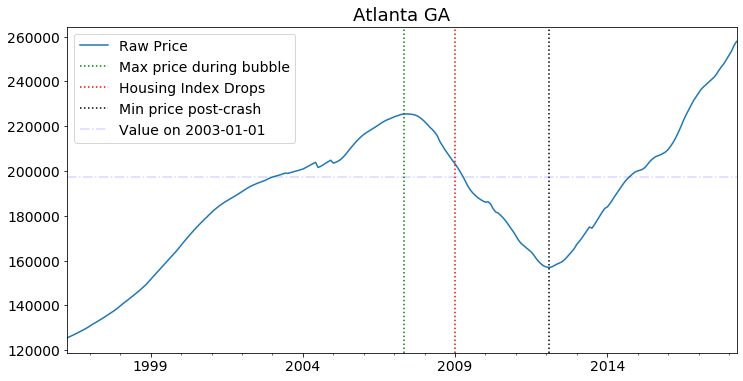

In [975]:
plot_single_geog(df_metro_values, 'Atlanta GA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

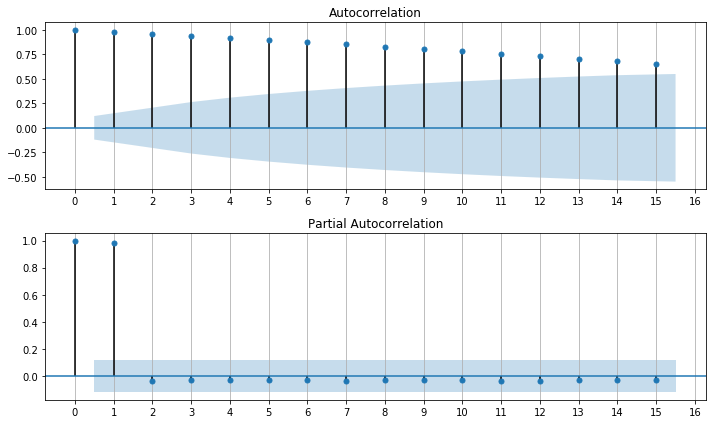

In [516]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

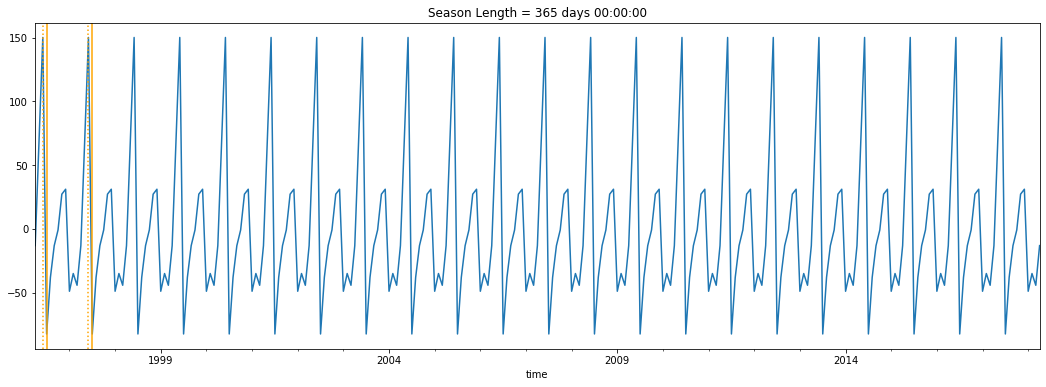

In [517]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [518]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [519]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Atlanta GA:
# ARIMA(0, 0, 0) MSE=1005279487.568
# ARIMA(0, 0, 1) MSE=266644771.131
# ARIMA(0, 1, 0) MSE=1593027.304
# ARIMA(0, 1, 1) MSE=664012.695
# ARIMA(0, 1, 2) MSE=418543.254
# ARIMA(0, 2, 0) MSE=191916.890
# ARIMA(0, 2, 1) MSE=202147.210
# ARIMA(0, 2, 2) MSE=203371.667
# ARIMA(1, 0, 0) MSE=2139007.107
# ARIMA(1, 1, 0) MSE=187404.641
# ARIMA(1, 1, 1) MSE=197760.750
# ARIMA(1, 1, 2) MSE=199525.354
# ARIMA(1, 2, 0) MSE=194404.809
# ARIMA(1, 2, 1) MSE=202740.071
# ARIMA(2, 0, 0) MSE=191231.194
# ARIMA(2, 0, 1) MSE=203551.054
# ARIMA(2, 0, 2) MSE=205630.278
# ARIMA(2, 1, 0) MSE=190983.689
# ARIMA(2, 1, 1) MSE=199013.503
# ARIMA(2, 2, 0) MSE=197094.691
# ARIMA(2, 2, 1) MSE=203810.037
# ARIMA(2, 2, 2) MSE=201965.017
# ARIMA(4, 0, 0) MSE=198662.645
# ARIMA(4, 1, 0) MSE=199197.087
# ARIMA(4, 1, 1) MSE=201312.681
# ARIMA(4, 1, 2) MSE=207429.802
# ARIMA(4, 2, 0) MSE=203635.521
# ARIMA(4, 2, 1) MSE=203440.434
# ARIMA(6, 0, 0) MSE=207442.875
# ARIMA(6, 0, 1) MSE=208480.632
# ARIMA(6, 1, 0) MSE=205430.986
# ARIMA(6, 1, 1) MSE=204249.741
# ARIMA(6, 1, 2) MSE=205106.649
# ARIMA(6, 2, 0) MSE=207878.853
# ARIMA(6, 2, 1) MSE=208921.447
# ARIMA(6, 2, 2) MSE=211659.274
# ARIMA(8, 0, 0) MSE=212041.502
# ARIMA(8, 0, 1) MSE=211493.147
# ARIMA(8, 1, 0) MSE=205416.031
# ARIMA(8, 2, 0) MSE=209539.602
# ARIMA(8, 2, 1) MSE=210274.629
# ARIMA(10, 0, 0) MSE=214614.621
# ARIMA(10, 0, 1) MSE=212437.591
# ARIMA(10, 1, 0) MSE=206918.852
# ARIMA(10, 2, 0) MSE=210790.884
# ARIMA(10, 2, 1) MSE=212235.572
# Best ARIMA(1, 1, 0) MSE=187404.641
# Best ARIMA order = (1, 1, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Atlanta GA:
ARIMA(0, 0, 0) MSE=1005279487.568
ARIMA(0, 0, 1) MSE=266644771.131
ARIMA(0, 1, 0) MSE=1593027.304
ARIMA(0, 1, 1) MSE=664012.695
ARIMA(0, 1, 2) MSE=418543.254
ARIMA(0, 2, 0) MSE=191916.890
ARIMA(0, 2, 1) MSE=202147.210
ARIMA(0, 2, 2) MSE=203371.667
ARIMA(1, 0, 0) MSE=2139007.107
ARIMA(1, 1, 0) MSE=187404.641
ARIMA(1, 1, 1) MSE=197760.750
ARIMA(1, 1, 2) MSE=199525.354
ARIMA(1, 2, 0) MSE=194404.809
ARIMA(1, 2, 1) MSE=202740.071
ARIMA(2, 0, 0) MSE=191231.194
ARIMA(2, 0, 1) MSE=203551.054
ARIMA(2, 0, 2) MSE=205630.278
ARIMA(2, 1, 0) MSE=190983.689
ARIMA(2, 1, 1) MSE=199013.503
ARIMA(2, 2, 0) MSE=197094.691
ARIMA(2, 2, 1) MSE=203810.037
ARIMA(2, 2, 2) MSE=201965.017
ARIMA(4, 0, 0) MSE=198662.645
ARIMA(4, 1, 0) MSE=199197.087
ARIMA(4, 1, 1) MSE=201312.681
ARIMA(4, 1, 2) MSE=207429.802
ARIMA(4, 2, 0) MSE=203635.521
ARIMA(4, 2, 1) MSE=203440.434
ARIMA(6, 0, 0) MSE=207442.875
ARIMA(6, 0, 1) MSE=208480.632
ARIMA(6, 1, 0) MSE=205430.986
ARIMA(6, 1, 1) MSE=204249.741
ARIMA(6, 1, 2) 

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 0),
  (4, 1, 0),
  (4, 1, 1),
  (4, 1, 2),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 0),
  (6, 0, 1),
  (6, 1, 0),
  (6, 1, 1),
  (6, 1, 2),
  (6, 2, 0),
  (6, 2, 1),
  (6, 2, 2),
  (8, 0, 0),
  (8, 0, 1),
  (8, 1, 0),
  (8, 2, 0),
  (8, 2, 1),
  (10, 0, 0),
  (10, 0, 1),
  (10, 1, 0),
  (10, 2, 0),
  (10, 2, 1)],
 [1005279487.5677395,
  266644771.13066876,
  1593027.3041647791,
  664012.6951850571,
  418543.2535598821,
  191916.89034700804,
  202147.2102898835,
  203371.66680810993,
  2139007.1074902723,
  187404.64054016676,
  197760.75044118744,
  199525.35418151328,
  194404.80880611116,
  202740.0712020848,
  191231.19365293032,
  203551.0542474196,
  205630.27827952895,
  190983.68876547637,
  199

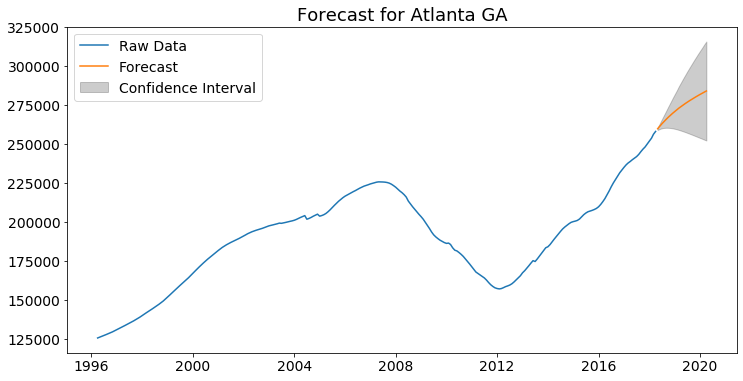

In [520]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [521]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--Atlanta GA:  Solid investment opportunity

By the model prediction, I would expect to see a 10.056% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -2.256% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 22.369% change in price by April 1, 2020.

In [522]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0), (8, 2, 0), (1, 1, 0)],
 [293773.15, 968850.81, 645882.95, 167911.06, 283770.73],
 [273372.08, 835905.83, 585569.59, 157781.43, 252023.98],
 [314174.21, 1101795.8, 706196.32, 178040.7, 315517.47],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104],
 [15.68, 4.0, 6.86, 12.2, 10.06],
 [7.65, -10.27, -3.12, 5.44, -2.26],
 [23.72, 18.27, 16.84, 18.97, 22.37])

## Investment modeling:   Seattle, WA


### Create ts dataframe for *single* geographic area

In [976]:
geog_area = 'Seattle WA'

In [524]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [977]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Seattle WA')
ts.head()

MetroState State          value
time                                       
1996-04-01  Seattle WA    WA  171929.787234
1996-05-01  Seattle WA    WA  172047.517730
1996-06-01  Seattle WA    WA  172219.148936
1996-07-01  Seattle WA    WA  172447.517730
1996-08-01  Seattle WA    WA  172763.120567

In [978]:
ts.tail()

MetroState State          value
time                                       
2017-12-01  Seattle WA    WA  561174.468085
2018-01-01  Seattle WA    WA  569081.560284
2018-02-01  Seattle WA    WA  575012.056738
2018-03-01  Seattle WA    WA  580377.304965
2018-04-01  Seattle WA    WA  583936.170213

In [979]:
ts_values = ts['value']

In [980]:
ts_values.head()

time
1996-04-01    171929.787234
1996-05-01    172047.517730
1996-06-01    172219.148936
1996-07-01    172447.517730
1996-08-01    172763.120567
Name: value, dtype: float64

### Visualizations

#### Plot of Seattle WA

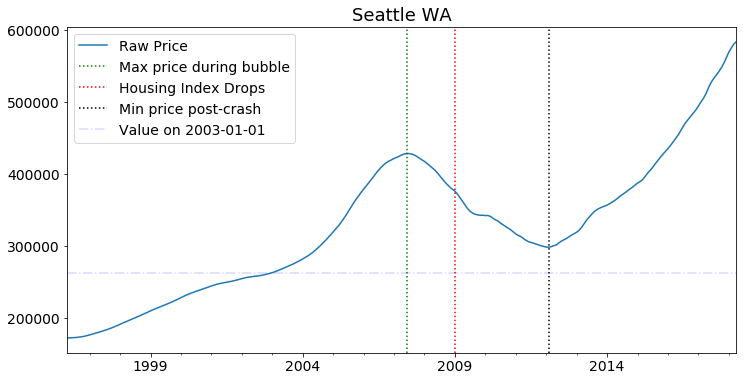

In [981]:
plot_single_geog(df_metro_values, 'Seattle WA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

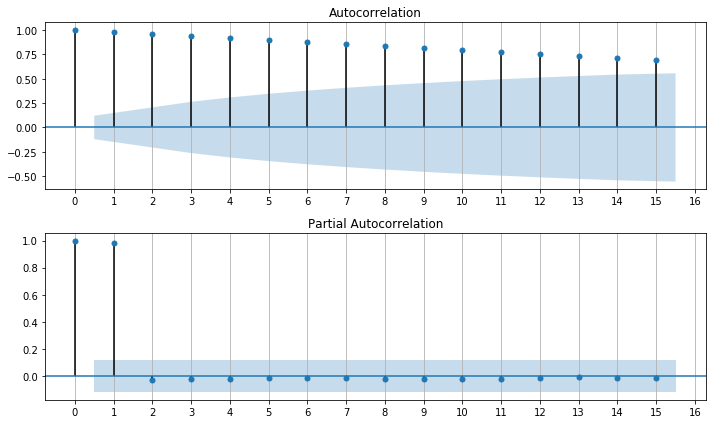

In [530]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

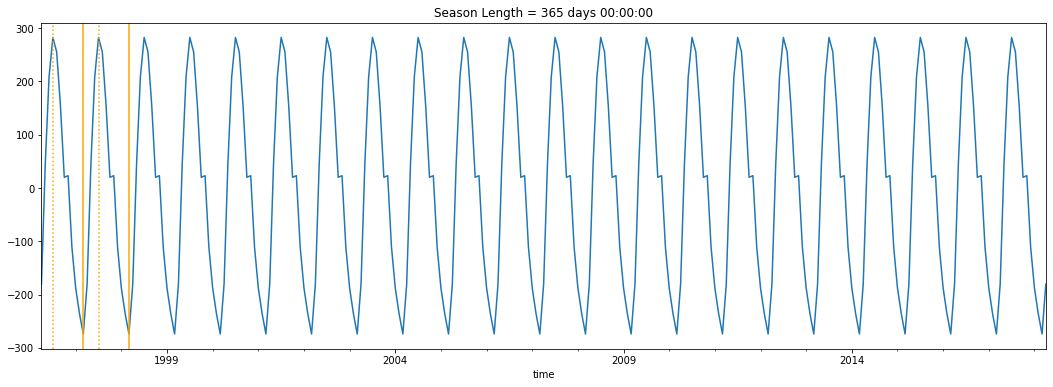

In [531]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [532]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [533]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time


# For Seattle WA:
# ARIMA(0, 0, 0) MSE=14433573020.155
# ARIMA(0, 0, 1) MSE=3700328816.318
# ARIMA(0, 1, 0) MSE=9632929.897
# ARIMA(0, 1, 1) MSE=2760108.694
# ARIMA(0, 2, 0) MSE=526808.450
# ARIMA(0, 2, 1) MSE=433231.309
# ARIMA(0, 2, 2) MSE=439159.727
# ARIMA(1, 0, 0) MSE=15187260.081
# ARIMA(1, 1, 0) MSE=522700.980
# ARIMA(1, 1, 1) MSE=425211.690
# ARIMA(1, 1, 2) MSE=432200.933
# ARIMA(1, 2, 0) MSE=492260.505
# ARIMA(1, 2, 1) MSE=438923.460
# ARIMA(2, 0, 1) MSE=759403421605.170
# ARIMA(2, 1, 0) MSE=483379.526
# ARIMA(2, 1, 1) MSE=431979.723
# ARIMA(2, 2, 0) MSE=460390.112
# ARIMA(2, 2, 1) MSE=441834.702
# ARIMA(2, 2, 2) MSE=412987.255
# ARIMA(4, 0, 0) MSE=468300.255
# ARIMA(4, 0, 1) MSE=448093.950
# ARIMA(4, 1, 1) MSE=442689.908
# ARIMA(4, 2, 0) MSE=450792.622
# ARIMA(4, 2, 1) MSE=443801.538
# ARIMA(4, 2, 2) MSE=440572.274
# ARIMA(6, 0, 0) MSE=457042.974
# ARIMA(6, 2, 0) MSE=467196.102
# ARIMA(8, 0, 0) MSE=476510.416
# ARIMA(8, 0, 1) MSE=480579.203
# ARIMA(8, 1, 1) MSE=479198.803
# ARIMA(8, 2, 0) MSE=494979.238
# Best ARIMA(2, 2, 2) MSE=412987.255
# Best ARIMA order = (2, 2, 2)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Seattle WA:
ARIMA(0, 0, 0) MSE=14433573020.155
ARIMA(0, 0, 1) MSE=3700328816.318
ARIMA(0, 1, 0) MSE=9632929.897
ARIMA(0, 1, 1) MSE=2760108.694
ARIMA(0, 2, 0) MSE=526808.450
ARIMA(0, 2, 1) MSE=433231.309
ARIMA(0, 2, 2) MSE=439159.727
ARIMA(1, 0, 0) MSE=15187260.081
ARIMA(1, 1, 0) MSE=522700.980
ARIMA(1, 1, 1) MSE=425211.690
ARIMA(1, 1, 2) MSE=432200.933
ARIMA(1, 2, 0) MSE=492260.505
ARIMA(1, 2, 1) MSE=438923.460
ARIMA(2, 0, 1) MSE=759403421605.170
ARIMA(2, 1, 0) MSE=483379.526
ARIMA(2, 1, 1) MSE=431979.723
ARIMA(2, 2, 0) MSE=460390.112
ARIMA(2, 2, 1) MSE=441834.702
ARIMA(2, 2, 2) MSE=412987.255
ARIMA(4, 0, 0) MSE=468300.255
ARIMA(4, 0, 1) MSE=448093.950
ARIMA(4, 1, 1) MSE=442689.908
ARIMA(4, 2, 0) MSE=450792.622
ARIMA(4, 2, 1) MSE=443801.538
ARIMA(4, 2, 2) MSE=440572.274
ARIMA(6, 0, 0) MSE=457042.974
ARIMA(6, 2, 0) MSE=467196.102
ARIMA(8, 0, 0) MSE=476510.416
ARIMA(8, 0, 1) MSE=480579.203
ARIMA(8, 1, 1) MSE=479198.803
ARIMA(8, 2, 0) MSE=494979.238
Best ARIMA(2, 2, 2) MSE=412987.255


([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 1),
  (2, 1, 0),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 0),
  (4, 0, 1),
  (4, 1, 1),
  (4, 2, 0),
  (4, 2, 1),
  (4, 2, 2),
  (6, 0, 0),
  (6, 2, 0),
  (8, 0, 0),
  (8, 0, 1),
  (8, 1, 1),
  (8, 2, 0)],
 [14433573020.155148,
  3700328816.3176994,
  9632929.896986712,
  2760108.6943378057,
  526808.4503737472,
  433231.3094130268,
  439159.726910774,
  15187260.080679711,
  522700.9804443949,
  425211.68955900805,
  432200.9325354095,
  492260.5046416006,
  438923.4601545567,
  759403421605.1696,
  483379.52634911233,
  431979.7228980253,
  460390.1115923101,
  441834.70199107984,
  412987.25498089014,
  468300.254638299,
  448093.9504089326,
  442689.907599594,
  450792.62208538223,
  443801.5379770573,
  440572.2741029862,
  457042.97434432205,
  467196.10240982287,
  476510.4156875748,


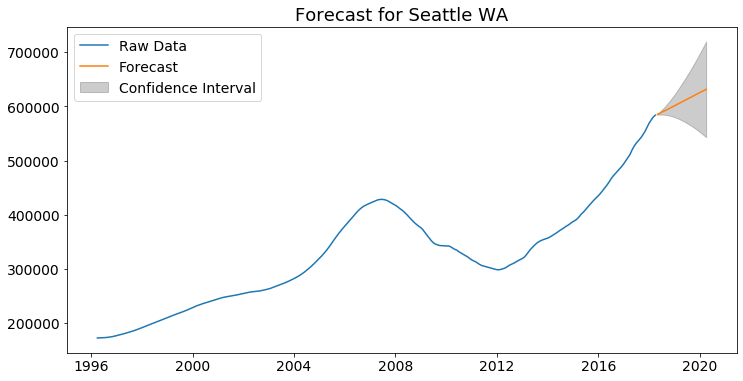

In [534]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [535]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--Seattle WA:   Good investment opportunity with limited downside and potentially large upside

By the model prediction, I would expect to see a 8.177% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -6.98% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.333% change in price by April 1, 2020.


In [536]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0), (8, 2, 0), (1, 1, 0), (2, 2, 2)],
 [293773.15, 968850.81, 645882.95, 167911.06, 283770.73, 631683.2],
 [273372.08, 835905.83, 585569.59, 157781.43, 252023.98, 543178.92],
 [314174.21, 1101795.8, 706196.32, 178040.7, 315517.47, 720187.47],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.1702127659],
 [15.68, 4.0, 6.86, 12.2, 10.06, 8.18],
 [7.65, -10.27, -3.12, 5.44, -2.26, -6.98],
 [23.72, 18.27, 16.84, 18.97, 22.37, 23.33])

## Investment modeling:   New York, NY


### Create ts dataframe for *single* geographic area

In [982]:
geog_area = 'New York NY'

In [983]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [984]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'New York NY')
ts.head()

MetroState State          value
time                                        
1996-04-01  New York NY    NY  209128.822055
1996-05-01  New York NY    NY  209288.471178
1996-06-01  New York NY    NY  209447.869674
1996-07-01  New York NY    NY  209589.223058
1996-08-01  New York NY    NY  209737.593985

In [985]:
ts.tail()

MetroState State          value
time                                        
2017-12-01  New York NY    NY  713390.291262
2018-01-01  New York NY    NY  716593.446602
2018-02-01  New York NY    NY  719873.543689
2018-03-01  New York NY    NY  723554.854369
2018-04-01  New York NY    NY  726948.300971

In [986]:
ts_values = ts['value']

In [987]:
ts_values.head()

time
1996-04-01    209128.822055
1996-05-01    209288.471178
1996-06-01    209447.869674
1996-07-01    209589.223058
1996-08-01    209737.593985
Name: value, dtype: float64

### Visualizations

#### Plot of New York NY

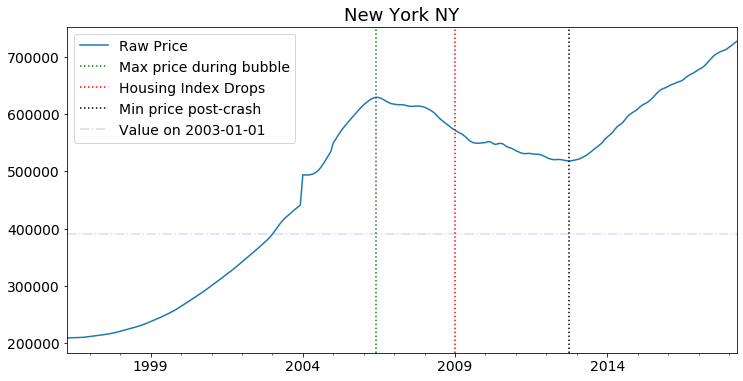

In [988]:
plot_single_geog(df_metro_values, 'New York NY', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

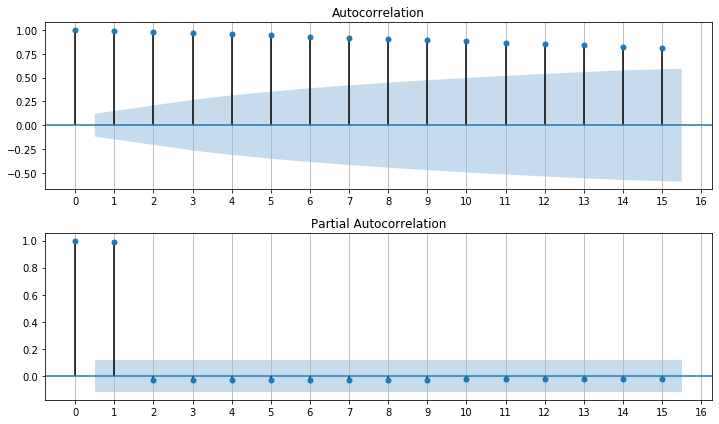

In [544]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

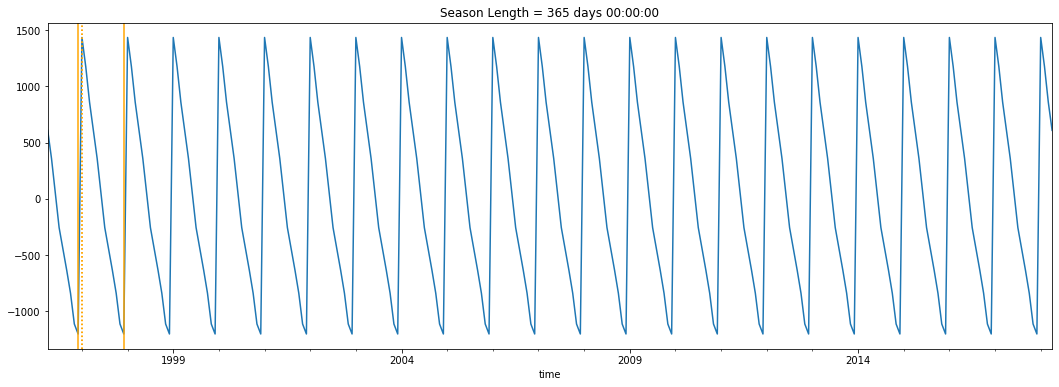

In [545]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [546]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [547]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For New York NY:
# ARIMA(0, 0, 0) MSE=25062357609.228
# ARIMA(0, 0, 1) MSE=6542958402.572
# ARIMA(0, 1, 0) MSE=4846815.944
# ARIMA(0, 1, 1) MSE=3129238.721
# ARIMA(0, 1, 2) MSE=2500998.862
# ARIMA(0, 2, 0) MSE=697394.200
# ARIMA(0, 2, 1) MSE=1502215.802
# ARIMA(0, 2, 2) MSE=1504355.709
# ARIMA(1, 0, 0) MSE=8869635.921
# ARIMA(1, 0, 1) MSE=5333358.688
# ARIMA(1, 0, 2) MSE=4074226.992
# ARIMA(1, 1, 0) MSE=2155593.081
# ARIMA(1, 1, 1) MSE=1437286.814
# ARIMA(1, 2, 0) MSE=975444.324
# ARIMA(1, 2, 1) MSE=1504205.409
# ARIMA(1, 2, 2) MSE=1506071.865
# ARIMA(2, 0, 0) MSE=2991366.575
# ARIMA(2, 0, 1) MSE=2249629.487
# ARIMA(2, 1, 0) MSE=1590141.717
# ARIMA(2, 1, 1) MSE=1442781.523
# ARIMA(2, 2, 0) MSE=1085537.761
# ARIMA(2, 2, 1) MSE=1513472.235
# ARIMA(2, 2, 2) MSE=1501674.726
# ARIMA(4, 0, 0) MSE=1781835.258
# ARIMA(4, 0, 1) MSE=2236176.420
# ARIMA(4, 0, 2) MSE=2530311.501
# ARIMA(4, 1, 0) MSE=1317992.333
# ARIMA(4, 1, 1) MSE=1461030.704
# ARIMA(4, 1, 2) MSE=1448439.776
# ARIMA(4, 2, 0) MSE=1136066.724
# ARIMA(4, 2, 1) MSE=1538442.499
# ARIMA(4, 2, 2) MSE=1532542.057
# ARIMA(6, 0, 0) MSE=1596299.094
# ARIMA(6, 0, 1) MSE=2299041.649
# ARIMA(6, 0, 2) MSE=2233825.668
# ARIMA(6, 1, 0) MSE=1268547.215
# ARIMA(6, 1, 1) MSE=1500913.236
# ARIMA(6, 1, 2) MSE=1465995.243
# ARIMA(6, 2, 0) MSE=1267463.381
# ARIMA(6, 2, 1) MSE=1583731.767
# ARIMA(6, 2, 2) MSE=1682390.843
# ARIMA(8, 0, 0) MSE=1650590.217
# ARIMA(8, 0, 1) MSE=2243462.220
# ARIMA(8, 0, 2) MSE=2241641.153
# ARIMA(8, 1, 0) MSE=1335465.944
# ARIMA(8, 1, 1) MSE=1538940.682
# ARIMA(8, 1, 2) MSE=1524747.292
# ARIMA(8, 2, 0) MSE=1380366.308
# ARIMA(8, 2, 1) MSE=1600324.829
# ARIMA(8, 2, 2) MSE=1833559.384
# ARIMA(10, 0, 0) MSE=1773592.038
# ARIMA(10, 0, 1) MSE=2236328.588
# ARIMA(10, 0, 2) MSE=2196622.717
# ARIMA(10, 1, 0) MSE=1408243.781
# ARIMA(10, 1, 1) MSE=1561447.204
# ARIMA(10, 1, 2) MSE=1546128.398
# ARIMA(10, 2, 0) MSE=1468521.240
# ARIMA(10, 2, 1) MSE=1631977.901
# Best ARIMA(0, 2, 0) MSE=697394.200
# Best ARIMA order = (0, 2, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For New York NY:
ARIMA(0, 0, 0) MSE=25062357609.228
ARIMA(0, 0, 1) MSE=6542958402.572
ARIMA(0, 1, 0) MSE=4846815.944
ARIMA(0, 1, 1) MSE=3129238.721
ARIMA(0, 1, 2) MSE=2500998.862
ARIMA(0, 2, 0) MSE=697394.200
ARIMA(0, 2, 1) MSE=1502215.802
ARIMA(0, 2, 2) MSE=1504355.709
ARIMA(1, 0, 0) MSE=8869635.921
ARIMA(1, 0, 1) MSE=5333358.688
ARIMA(1, 0, 2) MSE=4074226.992
ARIMA(1, 1, 0) MSE=2155593.081
ARIMA(1, 1, 1) MSE=1437286.814
ARIMA(1, 2, 0) MSE=975444.324
ARIMA(1, 2, 1) MSE=1504205.409
ARIMA(1, 2, 2) MSE=1506071.865
ARIMA(2, 0, 0) MSE=2991366.575
ARIMA(2, 0, 1) MSE=2249629.487
ARIMA(2, 1, 0) MSE=1590141.717
ARIMA(2, 1, 1) MSE=1442781.523
ARIMA(2, 2, 0) MSE=1085537.761
ARIMA(2, 2, 1) MSE=1513472.235
ARIMA(2, 2, 2) MSE=1501674.726
ARIMA(4, 0, 0) MSE=1781835.258
ARIMA(4, 0, 1) MSE=2236176.420
ARIMA(4, 0, 2) MSE=2530311.501
ARIMA(4, 1, 0) MSE=1317992.333
ARIMA(4, 1, 1) MSE=1461030.704
ARIMA(4, 1, 2) MSE=1448439.776
ARIMA(4, 2, 0) MSE=1136066.724
ARIMA(4, 2, 1) MSE=1538442.499
ARIMA(4, 2, 2) MS

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 0),
  (2, 0, 1),
  (2, 1, 0),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 0),
  (4, 0, 1),
  (4, 0, 2),
  (4, 1, 0),
  (4, 1, 1),
  (4, 1, 2),
  (4, 2, 0),
  (4, 2, 1),
  (4, 2, 2),
  (6, 0, 0),
  (6, 0, 1),
  (6, 0, 2),
  (6, 1, 0),
  (6, 1, 1),
  (6, 1, 2),
  (6, 2, 0),
  (6, 2, 1),
  (6, 2, 2),
  (8, 0, 0),
  (8, 0, 1),
  (8, 0, 2),
  (8, 1, 0),
  (8, 1, 1),
  (8, 1, 2),
  (8, 2, 0),
  (8, 2, 1),
  (8, 2, 2),
  (10, 0, 0),
  (10, 0, 1),
  (10, 0, 2),
  (10, 1, 0),
  (10, 1, 1),
  (10, 1, 2),
  (10, 2, 0),
  (10, 2, 1)],
 [25062357609.228226,
  6542958402.572352,
  4846815.944374435,
  3129238.720586294,
  2500998.8623190587,
  697394.2001825616,
  1502215.8024468976,
  1504355.7089967194,
  8869635.920746488,
  5333358.688041739,
  4074226.991876847,
  

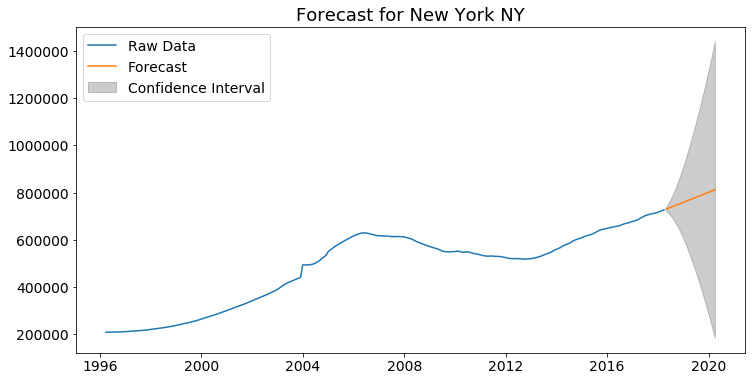

In [548]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [549]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--New York NY:  Extremely speculative; recommend against unless investors are willing to lose 75% of investment in worst case scenario

By the model prediction, I would expect to see a 11.711% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -74.58% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 98.002% change in price by April 1, 2020.

In [550]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY'],
 [(8, 2, 0), (1, 1, 2), (1, 1, 0), (8, 2, 0), (1, 1, 0), (2, 2, 2), (0, 2, 0)],
 [293773.15, 968850.81, 645882.95, 167911.06, 283770.73, 631683.2, 812079.76],
 [273372.08, 835905.83, 585569.59, 157781.43, 252023.98, 543178.92, 184788.17],
 [314174.21, 1101795.8, 706196.32, 178040.7, 315517.47, 720187.47, 1439371.36],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.1702127659,
  726948.3009708738],
 [15.68, 4.0, 6.86, 12.2, 10.06, 8.18, 11.71],
 [7.65, -10.27, -3.12, 5.44, -2.26, -6.98, -74.58],
 [23.72, 18.27, 16.84, 18.97, 22.37, 23.33, 98.0])

## Investment modeling:   San Francisco, CA


### Create ts dataframe for *single* geographic area

In [989]:
geog_area = 'San Francisco CA'

In [990]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [991]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'San Francisco CA')
ts.head()

MetroState State         value
time                                            
1996-04-01  San Francisco CA    CA  303238.28125
1996-05-01  San Francisco CA    CA  303475.78125
1996-06-01  San Francisco CA    CA  303821.87500
1996-07-01  San Francisco CA    CA  304275.78125
1996-08-01  San Francisco CA    CA  304871.87500

In [992]:
ts.tail()

MetroState State         value
time                                            
2017-12-01  San Francisco CA    CA  1.315490e+06
2018-01-01  San Francisco CA    CA  1.329636e+06
2018-02-01  San Francisco CA    CA  1.341684e+06
2018-03-01  San Francisco CA    CA  1.353951e+06
2018-04-01  San Francisco CA    CA  1.361623e+06

In [993]:
ts_values = ts['value']

In [994]:
ts_values.head()

time
1996-04-01    303238.28125
1996-05-01    303475.78125
1996-06-01    303821.87500
1996-07-01    304275.78125
1996-08-01    304871.87500
Name: value, dtype: float64

### Visualizations

#### Plot of San Francisco CA

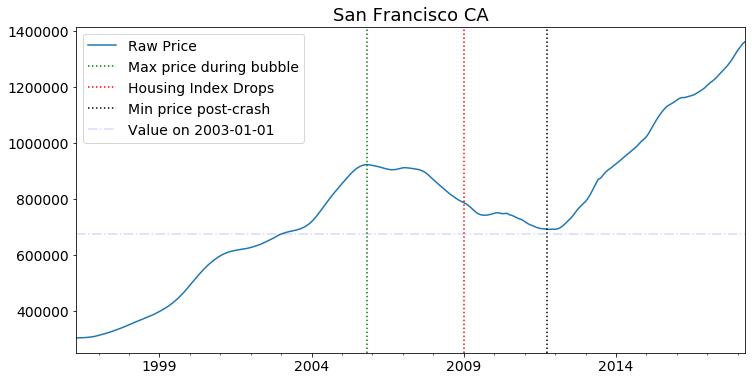

In [995]:
plot_single_geog(df_metro_values, 'San Francisco CA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

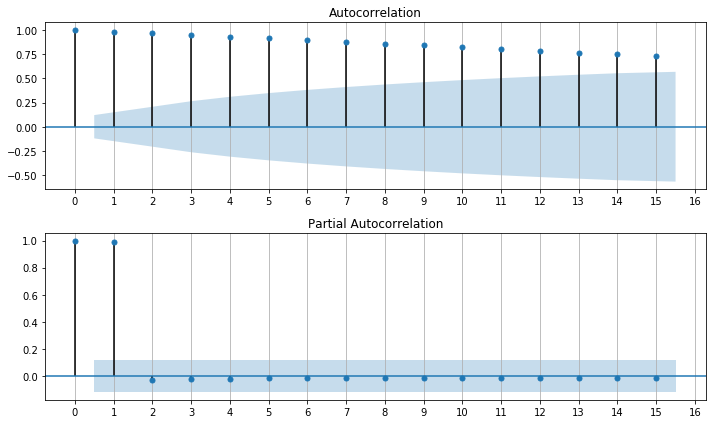

In [558]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

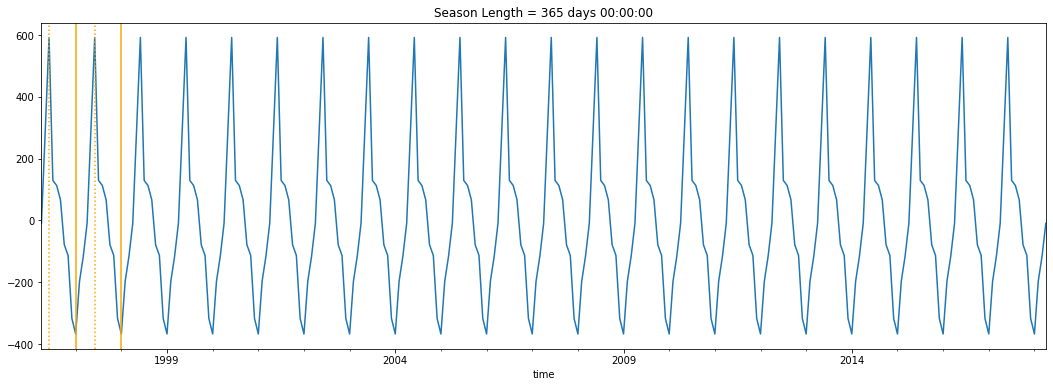

In [559]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [560]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [561]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# ARIMA(0, 0, 0) MSE=114625778442.393
# ARIMA(0, 0, 1) MSE=29287103460.815
# ARIMA(0, 1, 0) MSE=45599327.340
# ARIMA(0, 1, 1) MSE=20923963.830
# ARIMA(0, 2, 0) MSE=4655396.126
# ARIMA(0, 2, 1) MSE=5399016.767
# ARIMA(0, 2, 2) MSE=5610963.751
# ARIMA(1, 0, 0) MSE=80417491.194
# ARIMA(1, 1, 0) MSE=4598941.614
# ARIMA(1, 1, 1) MSE=5307238.818
# ARIMA(1, 1, 2) MSE=5541903.350
# ARIMA(1, 2, 0) MSE=5553002.305
# ARIMA(2, 0, 1) MSE=5444474.632
# ARIMA(2, 0, 2) MSE=5679295.869
# ARIMA(2, 1, 0) MSE=5559838.702
# ARIMA(2, 2, 0) MSE=5671653.452
# ARIMA(4, 0, 0) MSE=5863439.601
# ARIMA(4, 0, 1) MSE=5800732.673
# ARIMA(4, 1, 0) MSE=5821527.769
# ARIMA(4, 2, 0) MSE=6276793.700
# ARIMA(6, 0, 0) MSE=6279125.609
# ARIMA(6, 0, 1) MSE=6021493.908
# ARIMA(6, 1, 0) MSE=6156252.892
# ARIMA(6, 2, 0) MSE=6573029.667
# ARIMA(8, 0, 0) MSE=6781460.750
# ARIMA(8, 2, 0) MSE=6684112.058
# ARIMA(10, 0, 0) MSE=6979046.482
# Best ARIMA(1, 1, 0) MSE=4598941.614
# Best ARIMA order = (1, 1, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

In [867]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [563]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,0), confint=2)


For San Francisco CA:
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2300.275
Method:                       css-mle   S.D. of innovations           1464.249
Date:                Sat, 04 Apr 2020   AIC                           4606.550
Time:                        16:03:32   BIC                           4617.277
Sample:                    05-01-1996   HQIC                          4610.860
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3947.3379   2406.998      1.640      0.102    -770.292    8664.968
ar.L1.D.value     0.9660      0.015     65.586      0.000       0.937  

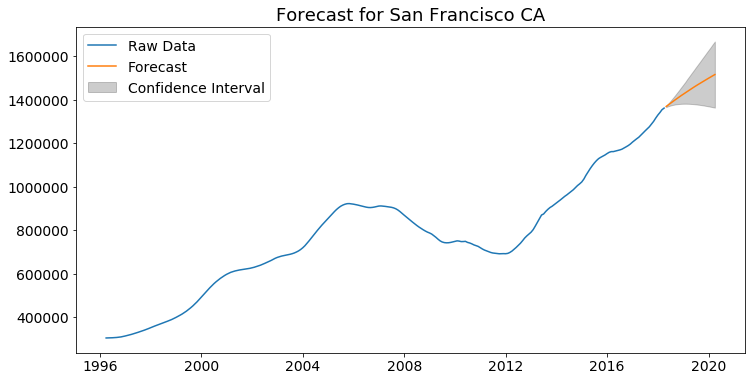

In [877]:
arima_forecast_enter_pdq_no_listappend(ts, geog_area, best_cfg = (1,1,0), confint=2)

### RESULTS--San Francisco CA:  Strong investment prospect--but do not expect sky-high returns

By the model prediction, I would expect to see a 11.342% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 0.153% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 22.532% change in price by April 1, 2020.

In [868]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32,
  199016.62,
  314439.02],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67,
  172775.48,
  277492.27],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  3155

## Investment modeling:   Denver CO

### Create ts dataframe for *single* geographic area

In [996]:
geog_area = 'Denver CO'

In [997]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [998]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Denver CO')
ts.head()

MetroState State          value
time                                      
1996-04-01  Denver CO    CO  146333.333333
1996-05-01  Denver CO    CO  146554.285714
1996-06-01  Denver CO    CO  146820.000000
1996-07-01  Denver CO    CO  147094.285714
1996-08-01  Denver CO    CO  147428.571429

In [999]:
ts.tail()

MetroState State          value
time                                      
2017-12-01  Denver CO    CO  423132.075472
2018-01-01  Denver CO    CO  426508.490566
2018-02-01  Denver CO    CO  430155.660377
2018-03-01  Denver CO    CO  434776.415094
2018-04-01  Denver CO    CO  438153.773585

In [1000]:
ts_values = ts['value']

In [1001]:
ts_values.head()

time
1996-04-01    146333.333333
1996-05-01    146554.285714
1996-06-01    146820.000000
1996-07-01    147094.285714
1996-08-01    147428.571429
Name: value, dtype: float64

### Visualizations

#### Plot of Denver CO

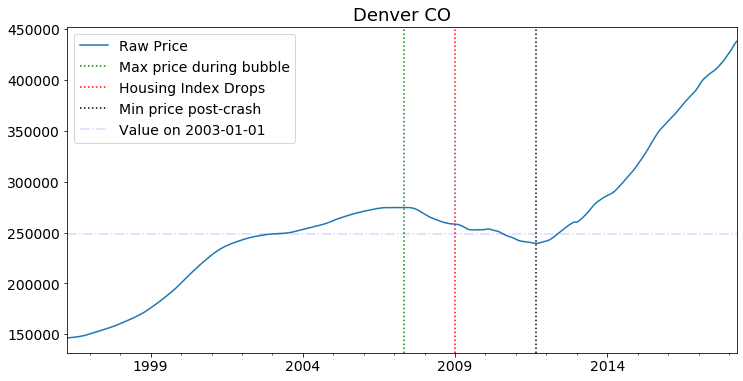

In [1002]:
plot_single_geog(df_metro_values, 'Denver CO', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

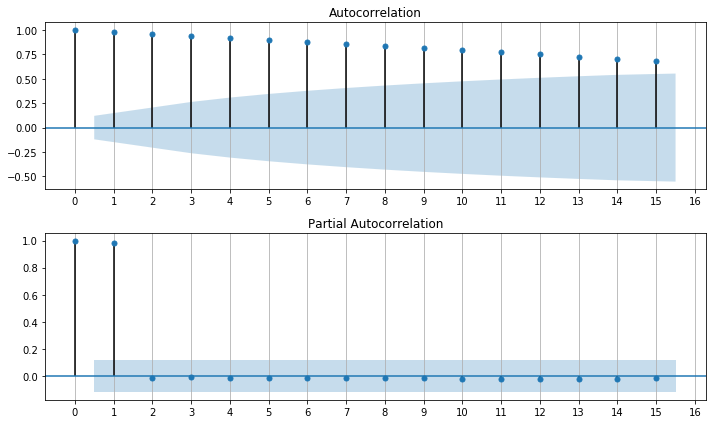

In [572]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

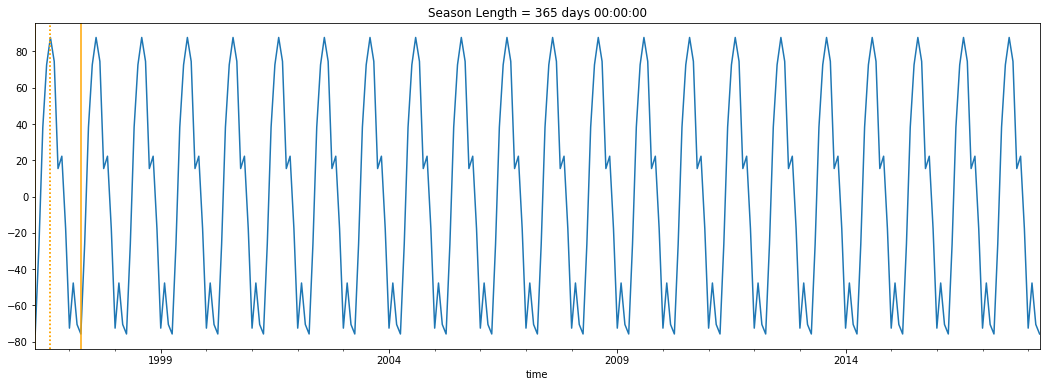

In [573]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [869]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [575]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Denver CO:
# ARIMA(0, 0, 0) MSE=8827359790.693
# ARIMA(0, 0, 1) MSE=2250889757.841
# ARIMA(0, 1, 0) MSE=3512074.528
# ARIMA(0, 1, 1) MSE=1187514.521
# ARIMA(0, 2, 0) MSE=197027.953
# ARIMA(0, 2, 1) MSE=249383.280
# ARIMA(1, 0, 0) MSE=6403567.023
# ARIMA(1, 1, 0) MSE=196931.221
# ARIMA(1, 2, 0) MSE=228325.042
# ARIMA(2, 1, 0) MSE=226433.065
# ARIMA(2, 2, 0) MSE=241798.720
# ARIMA(2, 2, 1) MSE=269474.136
# ARIMA(4, 0, 0) MSE=250206.600
# ARIMA(4, 1, 1) MSE=287843.696
# ARIMA(4, 2, 0) MSE=282616.282
# ARIMA(4, 2, 1) MSE=293874.060
# ARIMA(6, 0, 0) MSE=294179.241
# ARIMA(8, 2, 0) MSE=314391.429
# ARIMA(10, 2, 0) MSE=327460.842
# Best ARIMA(1, 1, 0) MSE=196931.221


### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Denver CO:
ARIMA(0, 0, 0) MSE=8827359790.693
ARIMA(0, 0, 1) MSE=2250889757.841
ARIMA(0, 1, 0) MSE=3512074.528
ARIMA(0, 1, 1) MSE=1187514.521
ARIMA(0, 2, 0) MSE=197027.953
ARIMA(0, 2, 1) MSE=249383.280
ARIMA(1, 0, 0) MSE=6403567.023
ARIMA(1, 1, 0) MSE=196931.221
ARIMA(1, 2, 0) MSE=228325.042
ARIMA(2, 1, 0) MSE=226433.065
ARIMA(2, 2, 0) MSE=241798.720
ARIMA(2, 2, 1) MSE=269474.136
ARIMA(4, 0, 0) MSE=250206.600
ARIMA(4, 1, 1) MSE=287843.696
ARIMA(4, 2, 0) MSE=282616.282
ARIMA(4, 2, 1) MSE=293874.060
ARIMA(6, 0, 0) MSE=294179.241
ARIMA(8, 2, 0) MSE=314391.429
ARIMA(10, 2, 0) MSE=327460.842
Best ARIMA(1, 1, 0) MSE=196931.221
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1870.508
Method:                       css-mle   S.D. of innovations            287.238
Date:                We

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (1, 0, 0),
  (1, 1, 0),
  (1, 2, 0),
  (2, 1, 0),
  (2, 2, 0),
  (2, 2, 1),
  (4, 0, 0),
  (4, 1, 1),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 0),
  (8, 2, 0),
  (10, 2, 0)],
 [8827359790.692698,
  2250889757.841373,
  3512074.5278568584,
  1187514.5209143634,
  197027.95297860284,
  249383.28015281635,
  6403567.023393467,
  196931.2209519582,
  228325.04215078647,
  226433.06534524928,
  241798.71956146898,
  269474.1357884362,
  250206.59966578707,
  287843.6963001053,
  282616.2817188592,
  293874.05991337186,
  294179.2410791519,
  314391.4285925226,
  327460.84191154473],
 (1, 1, 0),
 196931.2209519582,
 ['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0)],
 [293

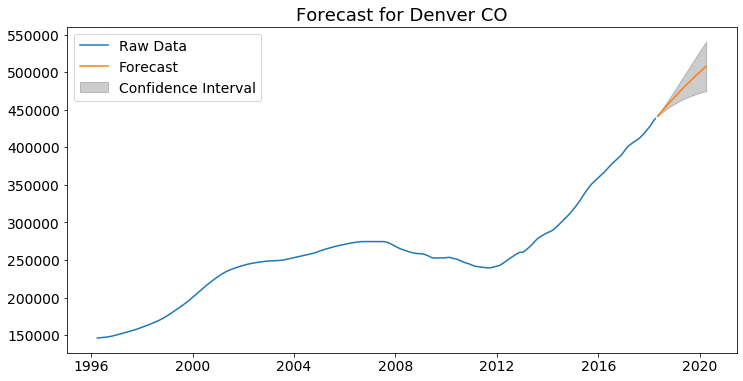

In [576]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [577]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--Denver CO:  Excellent investment, with even the worst-case scenario yielding over 8% returns

By the model prediction, I would expect to see a 15.902% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 8.362% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.441% change in price by April 1, 2020.

In [578]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.1702127659,
  726948.3009708738,
  1361623.134328358,
  438153.77358490566],
 [15.68, 4.0, 6.86, 12.2, 10.06, 8.18, 11.71, 11.34, 15.9],
 [7.65, -10.27, -3.12, 5.44, -2.26, -6.98, -74.58, 0.15, 8.36],
 [23.72, 18.27, 16.84, 1

## Investment modeling:   Nashville TN


### Create ts dataframe for *single* geographic area

In [1003]:
geog_area = 'Nashville TN'

In [1004]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [1005]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Nashville TN')
ts.head()

MetroState State         value
time                                        
1996-04-01  Nashville TN    TN  91936.144578
1996-05-01  Nashville TN    TN  92380.722892
1996-06-01  Nashville TN    TN  92812.048193
1996-07-01  Nashville TN    TN  93227.710843
1996-08-01  Nashville TN    TN  93620.481928

In [1006]:
ts.tail()

MetroState State          value
time                                         
2017-12-01  Nashville TN    TN  237377.647059
2018-01-01  Nashville TN    TN  239042.352941
2018-02-01  Nashville TN    TN  240696.470588
2018-03-01  Nashville TN    TN  243049.411765
2018-04-01  Nashville TN    TN  245022.352941

In [1007]:
ts_values = ts['value']

In [1008]:
ts_values.head()

time
1996-04-01    91936.144578
1996-05-01    92380.722892
1996-06-01    92812.048193
1996-07-01    93227.710843
1996-08-01    93620.481928
Name: value, dtype: float64

### Visualizations

#### Plot of Nashville TN

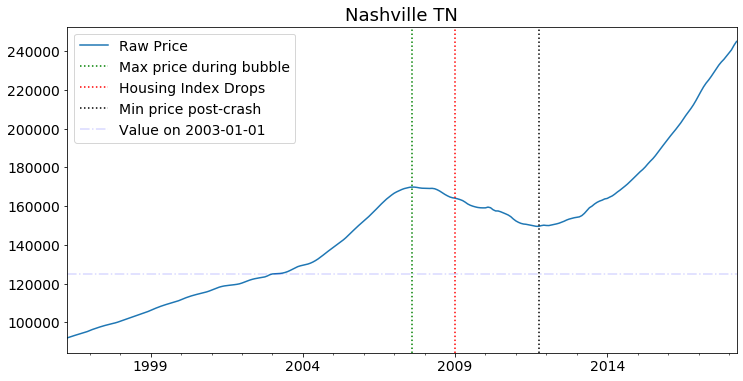

In [1009]:
plot_single_geog(df_metro_values, 'Nashville TN', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

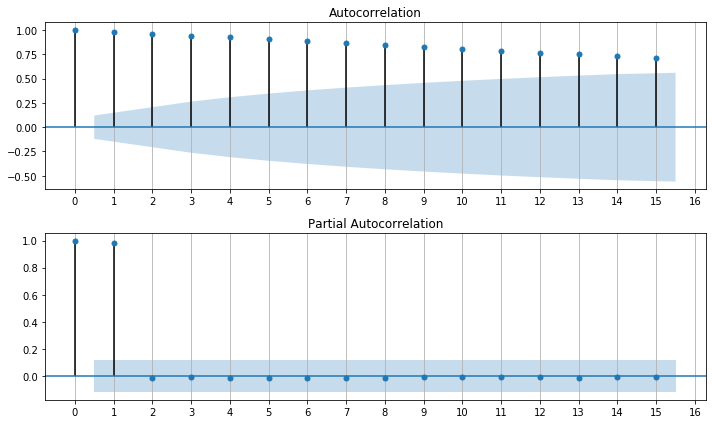

In [586]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

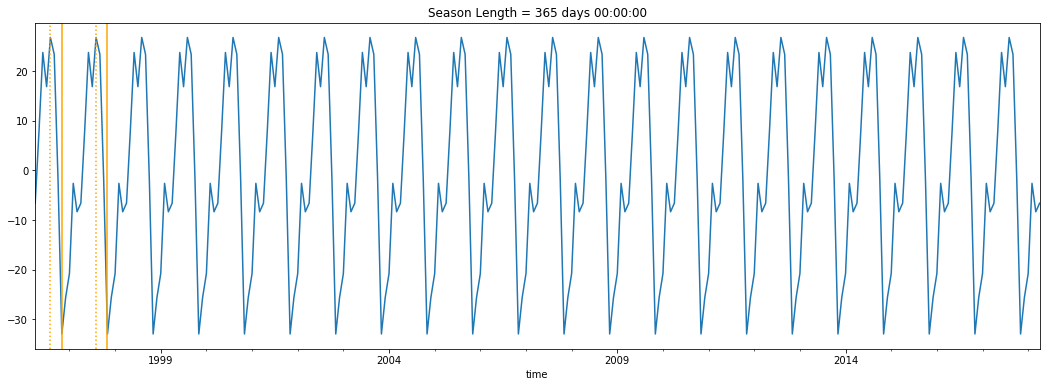

In [587]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [588]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [589]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Nashville TN:
# ARIMA(0, 0, 0) MSE=2410093644.433
# ARIMA(0, 0, 1) MSE=614839344.182
# ARIMA(0, 1, 0) MSE=981875.479
# ARIMA(0, 1, 1) MSE=339166.093
# ARIMA(0, 2, 0) MSE=48464.766
# ARIMA(0, 2, 1) MSE=56232.574
# ARIMA(0, 2, 2) MSE=55183.508
# ARIMA(1, 0, 0) MSE=1696026.220
# ARIMA(1, 1, 0) MSE=48678.095
# ARIMA(1, 1, 1) MSE=55821.549
# ARIMA(1, 1, 2) MSE=55570.967
# ARIMA(1, 2, 0) MSE=50312.101
# ARIMA(1, 2, 1) MSE=55929.681
# ARIMA(1, 2, 2) MSE=53784.650
# ARIMA(2, 0, 0) MSE=255911.952
# ARIMA(2, 1, 0) MSE=50573.650
# ARIMA(2, 1, 1) MSE=55767.874
# ARIMA(2, 1, 2) MSE=53984.056
# ARIMA(2, 2, 0) MSE=52914.305
# ARIMA(2, 2, 1) MSE=56611.313
# ARIMA(2, 2, 2) MSE=53919.380
# ARIMA(4, 0, 0) MSE=71028.719
# ARIMA(4, 1, 0) MSE=55929.780
# ARIMA(4, 1, 1) MSE=59488.173
# ARIMA(4, 2, 0) MSE=59172.025
# ARIMA(4, 2, 1) MSE=57548.000
# ARIMA(6, 1, 0) MSE=57332.289
# ARIMA(6, 1, 1) MSE=59152.306
# ARIMA(6, 1, 2) MSE=59934.044
# ARIMA(6, 2, 0) MSE=58907.611
# ARIMA(6, 2, 1) MSE=60050.631
# ARIMA(6, 2, 2) MSE=60337.839
# ARIMA(8, 2, 0) MSE=60221.707
# ARIMA(10, 2, 0) MSE=66676.283
# Best ARIMA(0, 2, 0) MSE=48464.766
# Best ARIMA order = (0, 2, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Nashville TN:
ARIMA(0, 0, 0) MSE=2410093644.433
ARIMA(0, 0, 1) MSE=614839344.182
ARIMA(0, 1, 0) MSE=981875.479
ARIMA(0, 1, 1) MSE=339166.093
ARIMA(0, 2, 0) MSE=48464.766
ARIMA(0, 2, 1) MSE=56232.574
ARIMA(0, 2, 2) MSE=55183.508
ARIMA(1, 0, 0) MSE=1696026.220
ARIMA(1, 1, 0) MSE=48678.095
ARIMA(1, 1, 1) MSE=55821.549
ARIMA(1, 1, 2) MSE=55570.967
ARIMA(1, 2, 0) MSE=50312.101
ARIMA(1, 2, 1) MSE=55929.681
ARIMA(1, 2, 2) MSE=53784.650
ARIMA(2, 0, 0) MSE=255911.952
ARIMA(2, 1, 0) MSE=50573.650
ARIMA(2, 1, 1) MSE=55767.874
ARIMA(2, 1, 2) MSE=53984.056
ARIMA(2, 2, 0) MSE=52914.305
ARIMA(2, 2, 1) MSE=56611.313
ARIMA(2, 2, 2) MSE=53919.380
ARIMA(4, 0, 0) MSE=71028.719
ARIMA(4, 1, 0) MSE=55929.780
ARIMA(4, 1, 1) MSE=59488.173
ARIMA(4, 2, 0) MSE=59172.025
ARIMA(4, 2, 1) MSE=57548.000
ARIMA(6, 1, 0) MSE=57332.289
ARIMA(6, 1, 1) MSE=59152.306
ARIMA(6, 1, 2) MSE=59934.044
ARIMA(6, 2, 0) MSE=58907.611
ARIMA(6, 2, 1) MSE=60050.631
ARIMA(6, 2, 2) MSE=60337.839
ARIMA(8, 2, 0) MSE=60221.707
ARIMA(10, 2

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 0),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 0),
  (4, 1, 0),
  (4, 1, 1),
  (4, 2, 0),
  (4, 2, 1),
  (6, 1, 0),
  (6, 1, 1),
  (6, 1, 2),
  (6, 2, 0),
  (6, 2, 1),
  (6, 2, 2),
  (8, 2, 0),
  (10, 2, 0)],
 [2410093644.432597,
  614839344.1815481,
  981875.4785507187,
  339166.09321405494,
  48464.765759915004,
  56232.57366239382,
  55183.50818119397,
  1696026.220034063,
  48678.09549635663,
  55821.54857649353,
  55570.96674213259,
  50312.101006976765,
  55929.681397453736,
  53784.649564283514,
  255911.95221945754,
  50573.649518679995,
  55767.873965731844,
  53984.055580180386,
  52914.304927976846,
  56611.31276193216,
  53919.379559577224,
  71028.71921788623,
  55929.78044393271,
  59488.17285021804,
  59172.02508817683,
  57547.99972284497,

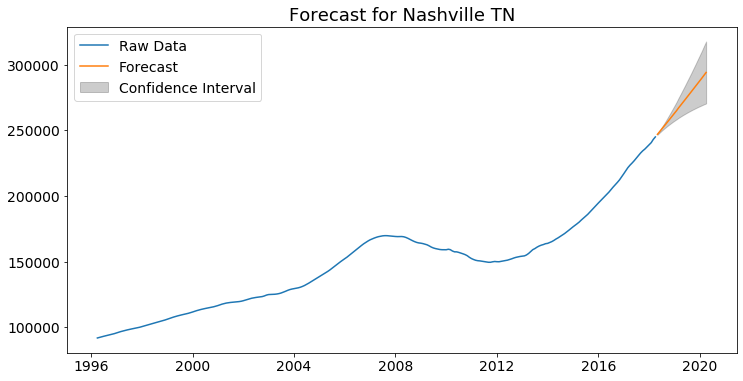

In [590]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [591]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)


### RESULTS--Nashville TN:  Extremely strong investment opportunity, with excellent positive returns even in the worst-case scenario

By the model prediction, I would expect to see a 20.037% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 10.406% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 29.667% change in price by April 1, 2020.

# Summary of findings

In [597]:
print_met_lengths()

met_geog_areas:  10
met_orders:  10
met_predicted_prices:  10
met_lower_bound_prices:  10
met_upper_bound_prices:  10
met_last_values:  10
met_pred_pct_changes:  10
met_lower_pct_changes:  10
met_upper_pct_changes:  10


In [595]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57,
  317713.82],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.1702127659,
  726948.3009708738,
  1361623.134328358,
  438153.77358490566,
  245022.35294117648],
 [15.68, 4.0, 6.86, 12.2, 10.06, 8.18, 11.71, 11.34, 15.

In [849]:
# print_metro_results_lists()

# (['Dallas-Fort Worth TX',
#   'Los Angeles-Long Beach-Anaheim CA',
#   'Boston MA',
#   'Pittsburgh PA',
#   'Atlanta GA',
#   'Seattle WA',
#   'New York NY',
#   'San Francisco CA',
#   'Denver CO',
#   'Nashville TN'],
#  [(8, 2, 0),
#   (1, 1, 2),
#   (1, 1, 0),
#   (8, 2, 0),
#   (1, 1, 0),
#   (2, 2, 2),
#   (0, 2, 0),
#   (1, 1, 0),
#   (1, 1, 0),
#   (0, 2, 0)],
#  [293773.15,
#   968850.81,
#   645882.95,
#   167911.06,
#   283770.73,
#   631683.2,
#   812079.76,
#   1516065.15,
#   507827.44,
#   294116.32],
#  [273372.08,
#   835905.83,
#   585569.59,
#   157781.43,
#   252023.98,
#   543178.92,
#   184788.17,
#   1363707.57,
#   474794.3,
#   270518.82],
#  [314174.21,
#   1101795.8,
#   706196.32,
#   178040.7,
#   315517.47,
#   720187.47,
#   1439371.36,
#   1668422.72,
#   540860.57,
#   317713.82],
#  [253947.46543778802,
#   931603.1700288184,
#   604409.595959596,
#   149648.02259887007,
#   257841.44736842104,
#   583936.1702127659,
#   726948.3009708738,
#   1361623.134328358,
#   438153.77358490566,
#   245022.35294117648],
#  [15.68, 4.0, 6.86, 12.2, 10.06, 8.18, 11.71, 11.34, 15.9, 20.04],
#  [7.65, -10.27, -3.12, 5.44, -2.26, -6.98, -74.58, 0.15, 8.36, 10.41],
#  [23.72, 18.27, 16.84, 18.97, 22.37, 23.33, 98.0, 22.53, 23.44, 29.67])



## Creating summary dataframe

In [601]:
# met_pred_pct_changes = 

met_invest_recs = []

for i in met_pred_pct_changes:
    if i <= 0.9:
        met_invest_recs.append("poor")
    elif i <= 4.9:
        met_invest_recs.append("mediocre")
    elif i <= 9.9:
        met_invest_recs.append("good")
    else:
        met_invest_recs.append("excellent")

met_invest_recs

['excellent',
 'mediocre',
 'good',
 'excellent',
 'excellent',
 'good',
 'excellent',
 'excellent',
 'excellent',
 'excellent']

In [602]:
len(met_invest_recs)

10

In [611]:
# met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, 
# met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes, met_invest_recs

df_metro_findings = pd.DataFrame({'Metro': met_geog_areas, '2018 value': met_last_values, 
                            'Investment rating, based on predicted return': met_invest_recs, 
                            'Predicted % Change': met_pred_pct_changes, 'Worst Case % Change': met_lower_pct_changes,
                            'Best Case % Change': met_upper_pct_changes, 'Predicted':met_predicted_prices, 
                            'Worst Case':met_lower_bound_prices, 'Best Case':met_upper_bound_prices})


In [612]:
df_metro_findings

Metro    2018 value  \
0               Dallas-Fort Worth TX  2.539475e+05   
1  Los Angeles-Long Beach-Anaheim CA  9.316032e+05   
2                          Boston MA  6.044096e+05   
3                      Pittsburgh PA  1.496480e+05   
4                         Atlanta GA  2.578414e+05   
5                         Seattle WA  5.839362e+05   
6                        New York NY  7.269483e+05   
7                   San Francisco CA  1.361623e+06   
8                          Denver CO  4.381538e+05   
9                       Nashville TN  2.450224e+05   

  Investment rating, based on predicted return  Predicted % Change  \
0                                    excellent               15.68   
1                                     mediocre                4.00   
2                                         good                6.86   
3                                    excellent               12.20   
4                                    excellent               10.06   
5                                         good                8.18   
6                                    excellent               11.71   
7                                    excellent               11.34   
8                                    excellent               15.90   
9                                    excellent               20.04   

   Worst Case % Change  Best Case % Change   Predicted  Worst Case   Best Case  
0                 7.65               23.72   293773.15   273372.08   314174.21  
1               -10.27               18.27   968850.81   835905.83  1101795.80  
2                -3.12               16.84   645882.95   585569.59   706196.32  
3                 5.44               18.97   167911.06   157781.43   178040.70  
4                -2.26               22.37   283770.73   252023.98   315517.47  
5                -6.98               23.33   631683.20   543178.92   720187.47  
6               -74.58               98.00   812079.76   184788.17  1439371.36  
7                 0.15               22.53  1516065.15  1363707.57  1668422.72  
8                 8.36               23.44   507827.44   474794.30   540860.57  
9                10.41               29.67   294116.32   270518.82   317713.82

## Summary dataframe, sorted by investment rating

In [613]:
df_metro_findings.sort_values('Predicted % Change', ascending = False, inplace=True)

In [614]:
df_metro_findings

Metro    2018 value  \
9                       Nashville TN  2.450224e+05   
8                          Denver CO  4.381538e+05   
0               Dallas-Fort Worth TX  2.539475e+05   
3                      Pittsburgh PA  1.496480e+05   
6                        New York NY  7.269483e+05   
7                   San Francisco CA  1.361623e+06   
4                         Atlanta GA  2.578414e+05   
5                         Seattle WA  5.839362e+05   
2                          Boston MA  6.044096e+05   
1  Los Angeles-Long Beach-Anaheim CA  9.316032e+05   

  Investment rating, based on predicted return  Predicted % Change  \
9                                    excellent               20.04   
8                                    excellent               15.90   
0                                    excellent               15.68   
3                                    excellent               12.20   
6                                    excellent               11.71   
7                                    excellent               11.34   
4                                    excellent               10.06   
5                                         good                8.18   
2                                         good                6.86   
1                                     mediocre                4.00   

   Worst Case % Change  Best Case % Change   Predicted  Worst Case   Best Case  
9                10.41               29.67   294116.32   270518.82   317713.82  
8                 8.36               23.44   507827.44   474794.30   540860.57  
0                 7.65               23.72   293773.15   273372.08   314174.21  
3                 5.44               18.97   167911.06   157781.43   178040.70  
6               -74.58               98.00   812079.76   184788.17  1439371.36  
7                 0.15               22.53  1516065.15  1363707.57  1668422.72  
4                -2.26               22.37   283770.73   252023.98   315517.47  
5                -6.98               23.33   631683.20   543178.92   720187.47  
2                -3.12               16.84   645882.95   585569.59   706196.32  
1               -10.27               18.27   968850.81   835905.83  1101795.80

The summary table is sorted by the investment rating, which was based primarily on the percentage increase (or decrease) in value at the end of the 24-month forecast period.  The top 7 metro areas all have returns of 10% or greater, with strong upside potential that is greater on a percentage basis than the downside risk of the worst-case scenario.  However, unless investors have a strong risk appetite, I would remove New York, NY from the list, since the worst-case scenario has a downside risk of ~75%!

Based on both the predicted returns and the best- and worst-case scenarios, I would recommend the following 6 metro areas for further exploration:

* Nashville, TN
* Denver, CO
* Dallas-Ft Worth, TX
* Pittsburgh, PA
* San Francisco, CA (see note below)
* Atlanta

Note:  because the San Francisco metro area is so large and diverse, further exploration at smaller geographic units will likely be required, prior to evaluating ZIP codes. Further, there are some additional metro areas near the SF Bay Area that should be explored--especially those to the furthest reaches to the South and East.  These areas have been attracting commuters, who work in Silicon Valley but want/need more affordable housing options, since the 1990s.  While some of these areas (e.g., Dublin, Tracy) were hard-hit during the housing market crash, it is likely with the subsequent spike of housing values subsequently that these areas are likely to increase in value over the next few years.

# Additional Modeling

## Investment modeling:   Minneapolis-St Paul MN


### Create ts dataframe for *single* geographic area

In [920]:
geog_area = 'Minneapolis-St Paul MN'

In [921]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [922]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Minneapolis-St Paul MN')
ts.head()

MetroState State          value
time                                                   
1996-04-01  Minneapolis-St Paul MN    MN  112583.152174
1996-05-01  Minneapolis-St Paul MN    MN  112759.782609
1996-06-01  Minneapolis-St Paul MN    MN  112951.086957
1996-07-01  Minneapolis-St Paul MN    MN  113143.478261
1996-08-01  Minneapolis-St Paul MN    MN  113355.434783

In [923]:
ts.tail()

MetroState State          value
time                                                   
2017-12-01  Minneapolis-St Paul MN    MN  273347.872340
2018-01-01  Minneapolis-St Paul MN    MN  274878.191489
2018-02-01  Minneapolis-St Paul MN    MN  276596.276596
2018-03-01  Minneapolis-St Paul MN    MN  279447.872340
2018-04-01  Minneapolis-St Paul MN    MN  281777.127660

In [924]:
ts_values = ts['value']

In [925]:
ts_values.head()

time
1996-04-01    112583.152174
1996-05-01    112759.782609
1996-06-01    112951.086957
1996-07-01    113143.478261
1996-08-01    113355.434783
Name: value, dtype: float64

### Visualizations

#### Plot of Minneapolis-St Paul MN

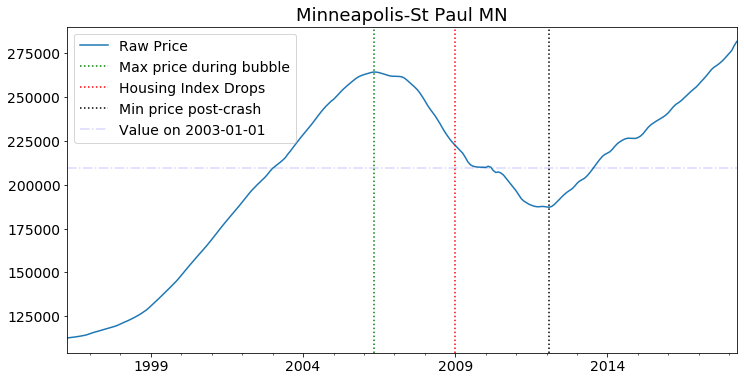

In [926]:
plot_single_geog(df_metro_values, 'Minneapolis-St Paul MN', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

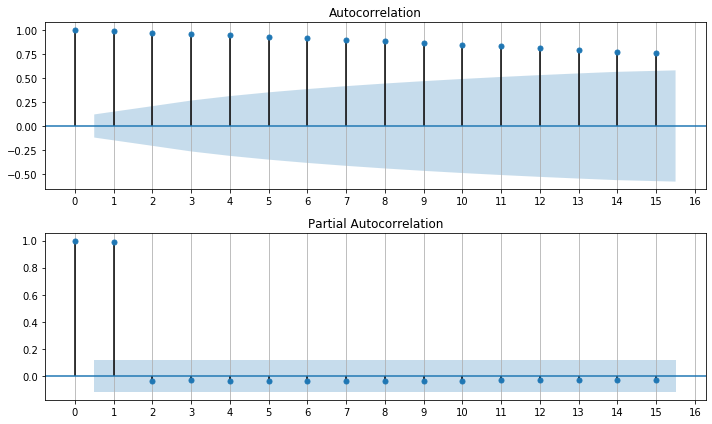

In [679]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

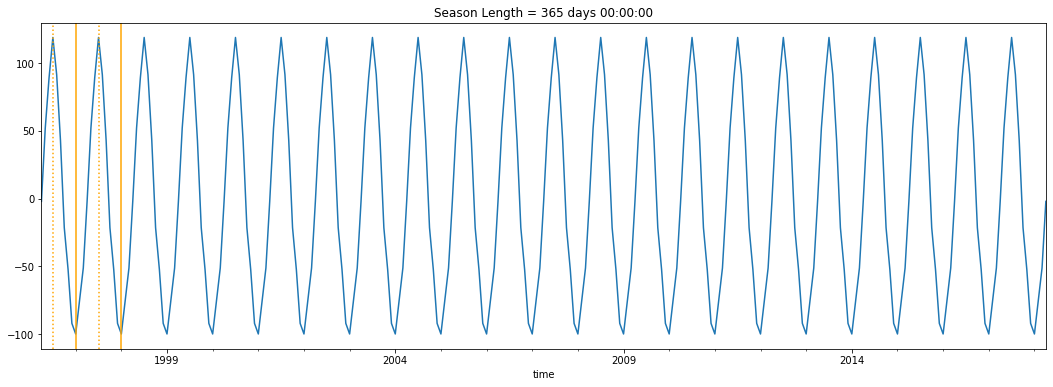

In [680]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [681]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [682]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time


### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Minneapolis-St Paul MN:
ARIMA(0, 0, 0) MSE=1361541732.167
ARIMA(0, 0, 1) MSE=349575348.242
ARIMA(0, 1, 0) MSE=1178088.351
ARIMA(0, 1, 1) MSE=374186.244
ARIMA(0, 2, 0) MSE=101842.211
ARIMA(0, 2, 1) MSE=78926.720
ARIMA(0, 2, 2) MSE=82127.464
ARIMA(1, 0, 0) MSE=1830795.702
ARIMA(1, 1, 0) MSE=99714.514
ARIMA(1, 1, 1) MSE=75155.590
ARIMA(1, 1, 2) MSE=78815.149
ARIMA(1, 2, 0) MSE=89703.386
ARIMA(1, 2, 1) MSE=79987.203
ARIMA(1, 2, 2) MSE=78174.133
ARIMA(2, 0, 1) MSE=77677.188
ARIMA(2, 0, 2) MSE=81894.805
ARIMA(2, 1, 0) MSE=85531.575
ARIMA(2, 1, 1) MSE=76414.718
ARIMA(2, 1, 2) MSE=76409.019
ARIMA(2, 2, 0) MSE=79305.053
ARIMA(2, 2, 1) MSE=78448.269
ARIMA(2, 2, 2) MSE=78849.349
ARIMA(4, 0, 0) MSE=81544.612
ARIMA(4, 0, 1) MSE=80707.287
ARIMA(4, 0, 2) MSE=81266.251
ARIMA(4, 1, 0) MSE=76592.601
ARIMA(4, 1, 1) MSE=76286.304
ARIMA(4, 1, 2) MSE=78674.305
ARIMA(4, 2, 0) MSE=78269.255
ARIMA(4, 2, 1) MSE=77964.624
ARIMA(6, 0, 0) MSE=80545.428
ARIMA(6, 0, 1) MSE=83266.973
ARIMA(6, 0, 2) MSE=88935.901


([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 0),
  (4, 0, 1),
  (4, 0, 2),
  (4, 1, 0),
  (4, 1, 1),
  (4, 1, 2),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 0),
  (6, 0, 1),
  (6, 0, 2),
  (6, 1, 0),
  (6, 1, 1),
  (6, 2, 0),
  (6, 2, 1),
  (8, 0, 0),
  (8, 0, 2),
  (8, 1, 0),
  (8, 2, 0),
  (8, 2, 1),
  (10, 0, 0),
  (10, 1, 0),
  (10, 2, 0)],
 [1361541732.166554,
  349575348.2416673,
  1178088.3507478312,
  374186.2438899013,
  101842.21073541555,
  78926.71972572782,
  82127.46427106894,
  1830795.7018876863,
  99714.5139264712,
  75155.59011788979,
  78815.14903734755,
  89703.38588866423,
  79987.20324499847,
  78174.13321140879,
  77677.18820351554,
  81894.80514020298,
  85531.57528794864,
  76414.71793797947,
  76409.01855684893,
  79305.05

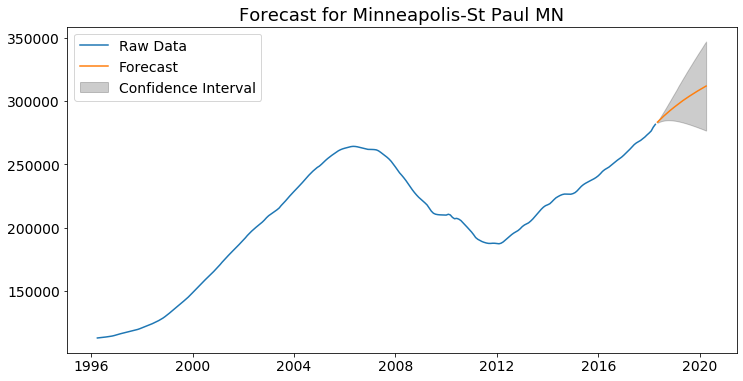

In [683]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [591]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (), confint=2)

# For Minneapolis-St Paul MN:
# ARIMA(0, 0, 0) MSE=1361541732.167
# ARIMA(0, 0, 1) MSE=349575348.242
# ARIMA(0, 1, 0) MSE=1178088.351
# ARIMA(0, 1, 1) MSE=374186.244
# ARIMA(0, 2, 0) MSE=101842.211
# ARIMA(0, 2, 1) MSE=78926.720
# ARIMA(0, 2, 2) MSE=82127.464
# ARIMA(1, 0, 0) MSE=1830795.702
# ARIMA(1, 1, 0) MSE=99714.514
# ARIMA(1, 1, 1) MSE=75155.590
# ARIMA(1, 1, 2) MSE=78815.149
# ARIMA(1, 2, 0) MSE=89703.386
# ARIMA(1, 2, 1) MSE=79987.203
# ARIMA(1, 2, 2) MSE=78174.133
# ARIMA(2, 0, 1) MSE=77677.188
# ARIMA(2, 0, 2) MSE=81894.805
# ARIMA(2, 1, 0) MSE=85531.575
# ARIMA(2, 1, 1) MSE=76414.718
# ARIMA(2, 1, 2) MSE=76409.019
# ARIMA(2, 2, 0) MSE=79305.053
# ARIMA(2, 2, 1) MSE=78448.269
# ARIMA(2, 2, 2) MSE=78849.349
# ARIMA(4, 0, 0) MSE=81544.612
# ARIMA(4, 0, 1) MSE=80707.287
# ARIMA(4, 0, 2) MSE=81266.251
# ARIMA(4, 1, 0) MSE=76592.601
# ARIMA(4, 1, 1) MSE=76286.304
# ARIMA(4, 1, 2) MSE=78674.305
# ARIMA(4, 2, 0) MSE=78269.255
# ARIMA(4, 2, 1) MSE=77964.624
# ARIMA(6, 0, 0) MSE=80545.428
# ARIMA(6, 0, 1) MSE=83266.973
# ARIMA(6, 0, 2) MSE=88935.901
# ARIMA(6, 1, 0) MSE=76597.743
# ARIMA(6, 1, 1) MSE=80607.270
# ARIMA(6, 2, 0) MSE=87089.043
# ARIMA(6, 2, 1) MSE=87711.787
# ARIMA(8, 0, 0) MSE=88719.072
# ARIMA(8, 0, 2) MSE=97427.344
# ARIMA(8, 1, 0) MSE=87944.503
# ARIMA(8, 2, 0) MSE=91556.567
# ARIMA(8, 2, 1) MSE=94383.787
# ARIMA(10, 0, 0) MSE=97542.573
# ARIMA(10, 1, 0) MSE=99082.806
# ARIMA(10, 2, 0) MSE=94356.503
# Best ARIMA(1, 1, 1) MSE=75155.590
# Best ARIMA order = (1, 1, 1)

### RESULTS--Minneapolis-St Paul MN:  Excellent investment potential, with low potential downside and high potential upside

By the model prediction, I would expect to see a 10.77% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -1.756% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.296% change in price by April 1, 2020.

In [684]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57,
  317713.82,
  347420.52],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.1702127659,
  726948.3009708738,
  1361623.134328358,
  438153.77358490566,


## Investment modeling:   San Diego CA


### Create ts dataframe for *single* geographic area

In [927]:
geog_area = 'San Diego CA'

In [928]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [929]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'San Diego CA')
ts.head()

MetroState State          value
time                                         
1996-04-01  San Diego CA    CA  214739.080460
1996-05-01  San Diego CA    CA  214580.459770
1996-06-01  San Diego CA    CA  214421.839080
1996-07-01  San Diego CA    CA  214277.011494
1996-08-01  San Diego CA    CA  214220.689655

In [930]:
ts.tail()

MetroState State          value
time                                         
2017-12-01  San Diego CA    CA  755378.160920
2018-01-01  San Diego CA    CA  761388.505747
2018-02-01  San Diego CA    CA  767027.586207
2018-03-01  San Diego CA    CA  772410.344828
2018-04-01  San Diego CA    CA  775151.724138

In [931]:
ts_values = ts['value']

In [932]:
ts_values.head()

time
1996-04-01    214739.080460
1996-05-01    214580.459770
1996-06-01    214421.839080
1996-07-01    214277.011494
1996-08-01    214220.689655
Name: value, dtype: float64

### Visualizations

#### Plot of San Diego CA

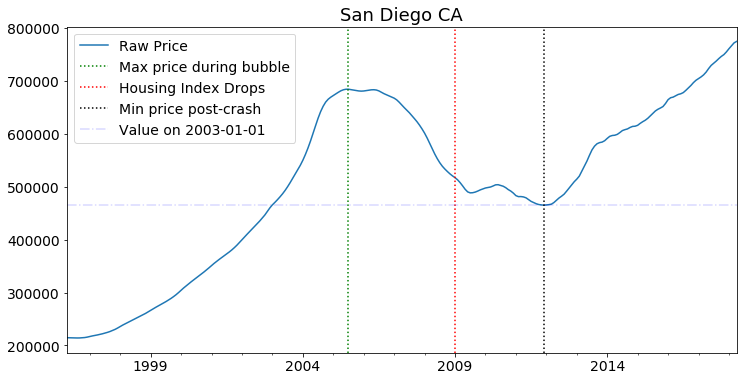

In [933]:
plot_single_geog(df_metro_values, 'San Diego CA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

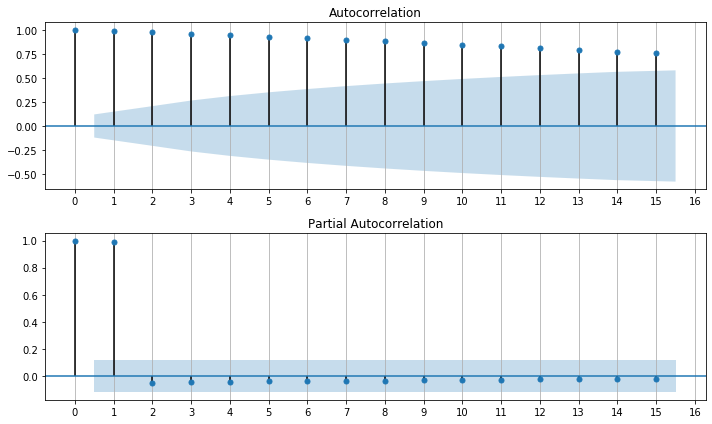

In [692]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

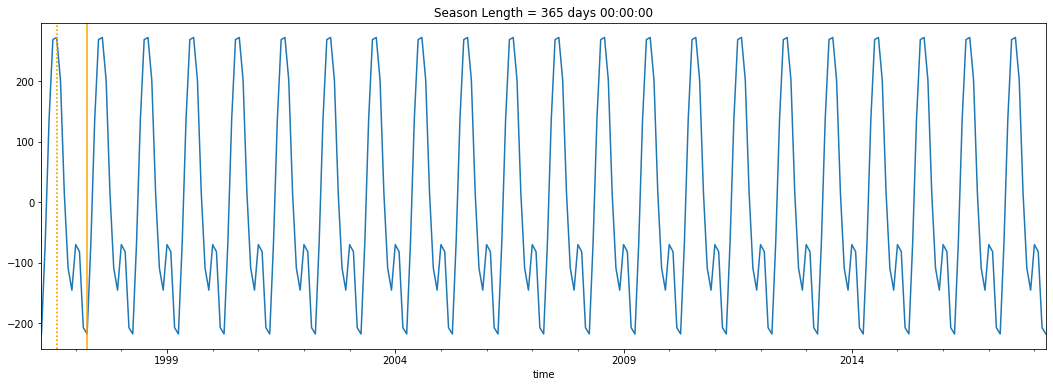

In [693]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [694]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [695]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For San Diego CA:
# ARIMA(0, 0, 0) MSE=23130708446.656
# ARIMA(0, 0, 1) MSE=5924771271.604
# ARIMA(0, 1, 0) MSE=11353076.842
# ARIMA(0, 1, 1) MSE=3045362.178
# ARIMA(0, 2, 0) MSE=1948832.467
# ARIMA(0, 2, 1) MSE=1095979.132
# ARIMA(1, 0, 0) MSE=19234392.624
# ARIMA(1, 1, 0) MSE=1908219.406
# ARIMA(1, 2, 0) MSE=1966667.951
# ARIMA(2, 0, 0) MSE=1948949.415
# ARIMA(2, 2, 0) MSE=1684405.232
# ARIMA(4, 0, 0) MSE=1686271.647
# ARIMA(4, 2, 0) MSE=1319697.470
# ARIMA(4, 2, 1) MSE=1143453.670
# ARIMA(6, 0, 0) MSE=35886782086.399
# ARIMA(6, 0, 1) MSE=1123728.095
# ARIMA(6, 1, 1) MSE=1131287.320
# ARIMA(6, 2, 0) MSE=1172553.789
# ARIMA(6, 2, 1) MSE=1172618.726
# ARIMA(8, 0, 0) MSE=1155883.765
# ARIMA(10, 0, 0) MSE=1196081.807
# Best ARIMA(0, 2, 1) MSE=1095979.132
# Best ARIMA order = (0, 2, 1)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For San Diego CA:
ARIMA(0, 0, 0) MSE=23130708446.656
ARIMA(0, 0, 1) MSE=5924771271.604
ARIMA(0, 1, 0) MSE=11353076.842
ARIMA(0, 1, 1) MSE=3045362.178
ARIMA(0, 2, 0) MSE=1948832.467
ARIMA(0, 2, 1) MSE=1095979.132
ARIMA(1, 0, 0) MSE=19234392.624
ARIMA(1, 1, 0) MSE=1908219.406
ARIMA(1, 2, 0) MSE=1966667.951
ARIMA(2, 0, 0) MSE=1948949.415
ARIMA(2, 2, 0) MSE=1684405.232
ARIMA(4, 0, 0) MSE=1686271.647
ARIMA(4, 2, 0) MSE=1319697.470
ARIMA(4, 2, 1) MSE=1143453.670
ARIMA(6, 0, 0) MSE=35886782086.399
ARIMA(6, 0, 1) MSE=1123728.095
ARIMA(6, 1, 1) MSE=1131287.320
ARIMA(6, 2, 0) MSE=1172553.789
ARIMA(6, 2, 1) MSE=1172618.726
ARIMA(8, 0, 0) MSE=1155883.765
ARIMA(10, 0, 0) MSE=1196081.807
Best ARIMA(0, 2, 1) MSE=1095979.132
Best ARIMA order = (0, 2, 1)
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -2102.917
Method:        

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (1, 0, 0),
  (1, 1, 0),
  (1, 2, 0),
  (2, 0, 0),
  (2, 2, 0),
  (4, 0, 0),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 0),
  (6, 0, 1),
  (6, 1, 1),
  (6, 2, 0),
  (6, 2, 1),
  (8, 0, 0),
  (10, 0, 0)],
 [23130708446.655598,
  5924771271.604158,
  11353076.842240157,
  3045362.177676508,
  1948832.4669271056,
  1095979.131819364,
  19234392.624190096,
  1908219.40636911,
  1966667.9506332949,
  1948949.4154000885,
  1684405.2320540114,
  1686271.6472204688,
  1319697.4703432221,
  1143453.6697057458,
  35886782086.39941,
  1123728.0945459649,
  1131287.31956713,
  1172553.7889707997,
  1172618.7257806838,
  1155883.7645135985,
  1196081.8066465468],
 (0, 2, 1),
 1095979.131819364,
 ['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San 

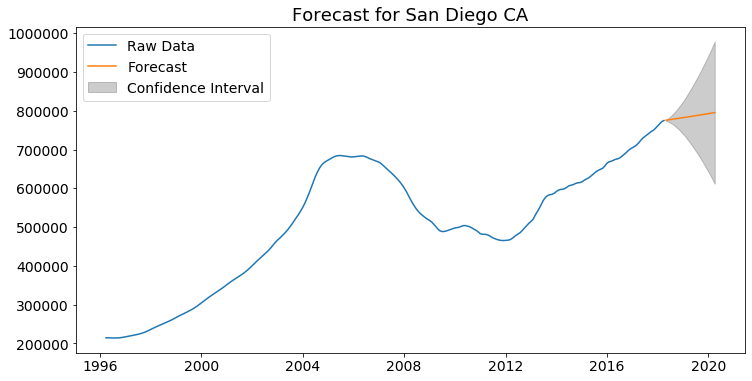

In [696]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [591]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (0,2,1), confint=2)

### RESULTS--San Diego CA:  Mediocre investment opportunity with signficant downside risk

By the model prediction, I would expect to see a 2.634% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -21.041% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 26.309% change in price by April 1, 2020.

In [697]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57,
  317713.82,
  347420.52,
  979082.82],
 [253947.46543778802,
  931603.1700288184,
  604409.595959596,
  149648.02259887007,
  257841.44736842104,
  583936.170212

## Investment modeling:   Detroit MI


### Create ts dataframe for *single* geographic area

In [934]:
geog_area = 'Detroit MI'

In [935]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [936]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Detroit MI')
ts.head()

MetroState State          value
time                                       
1996-04-01  Detroit MI    MI  133321.917808
1996-05-01  Detroit MI    MI  134178.767123
1996-06-01  Detroit MI    MI  135059.589041
1996-07-01  Detroit MI    MI  135954.794521
1996-08-01  Detroit MI    MI  136844.520548

In [937]:
ts.tail()

MetroState State          value
time                                       
2017-12-01  Detroit MI    MI  218973.202614
2018-01-01  Detroit MI    MI  219924.183007
2018-02-01  Detroit MI    MI  221439.869281
2018-03-01  Detroit MI    MI  223516.993464
2018-04-01  Detroit MI    MI  224952.287582

In [938]:
ts_values = ts['value']

In [939]:
ts_values.head()

time
1996-04-01    133321.917808
1996-05-01    134178.767123
1996-06-01    135059.589041
1996-07-01    135954.794521
1996-08-01    136844.520548
Name: value, dtype: float64

### Visualizations

#### Plot of Detroit MI


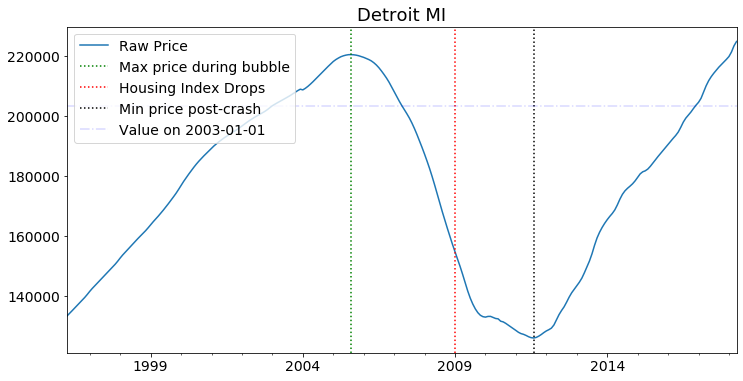

In [940]:
plot_single_geog(df_metro_values, 'Detroit MI', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

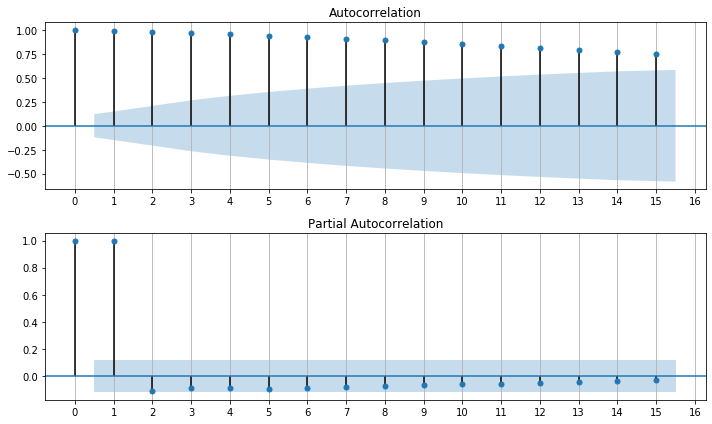

In [705]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

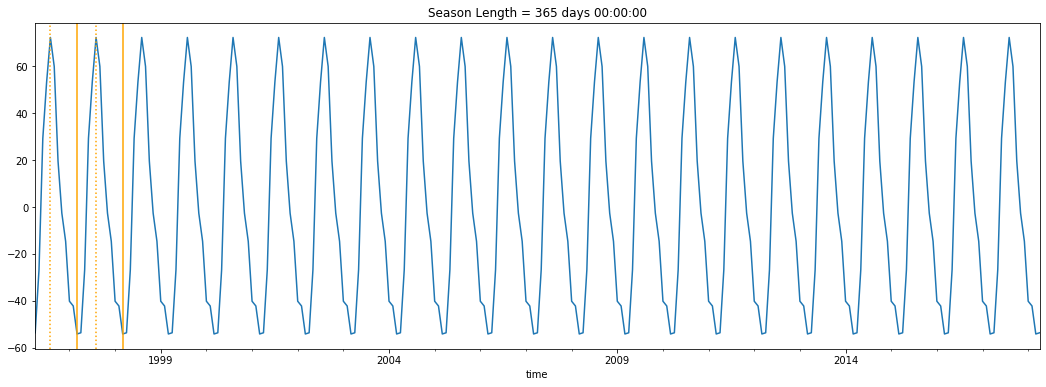

In [706]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [707]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [589]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Detroit MI:
# ARIMA(0, 0, 0) MSE=1087151432.799
# ARIMA(0, 1, 0) MSE=1247521.965
# ARIMA(0, 1, 1) MSE=376693.973
# ARIMA(0, 2, 0) MSE=75319.998
# ARIMA(0, 2, 1) MSE=61793.012
# ARIMA(0, 2, 2) MSE=65503.054
# ARIMA(1, 1, 0) MSE=74456.694
# ARIMA(1, 1, 1) MSE=60579.055
# ARIMA(1, 1, 2) MSE=64219.091
# ARIMA(1, 2, 0) MSE=65294.383
# ARIMA(2, 0, 1) MSE=61620.725
# ARIMA(2, 0, 2) MSE=64837.296
# ARIMA(2, 1, 0) MSE=63821.877
# ARIMA(2, 2, 0) MSE=64696.950
# ARIMA(2, 2, 1) MSE=65654.395
# ARIMA(2, 2, 2) MSE=65897.632
# ARIMA(4, 0, 1) MSE=63657.129
# ARIMA(4, 0, 2) MSE=63721.751
# ARIMA(4, 1, 0) MSE=64723.153
# ARIMA(4, 2, 0) MSE=65698.094
# ARIMA(4, 2, 1) MSE=65976.371
# ARIMA(6, 0, 1) MSE=63303.527
# ARIMA(6, 1, 0) MSE=65331.109
# ARIMA(6, 2, 0) MSE=66812.025
# ARIMA(6, 2, 1) MSE=67015.142
# ARIMA(8, 0, 1) MSE=64631.569
# ARIMA(8, 1, 0) MSE=66556.598
# ARIMA(8, 1, 1) MSE=66798.712
# ARIMA(8, 2, 0) MSE=67715.422
# ARIMA(8, 2, 1) MSE=67925.505
# ARIMA(10, 0, 1) MSE=65519.149
# ARIMA(10, 0, 2) MSE=73753.265
# ARIMA(10, 1, 1) MSE=69062.697
# ARIMA(10, 2, 0) MSE=68560.571
# ARIMA(10, 2, 1) MSE=69053.832
# Best ARIMA(1, 1, 1) MSE=60579.055
# Best ARIMA order = (1, 1, 1)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Detroit MI:
ARIMA(0, 0, 0) MSE=1087151432.799
ARIMA(0, 1, 0) MSE=1247521.965
ARIMA(0, 1, 1) MSE=376693.973
ARIMA(0, 2, 0) MSE=75319.998
ARIMA(0, 2, 1) MSE=61793.012
ARIMA(0, 2, 2) MSE=65503.054
ARIMA(1, 1, 0) MSE=74456.694
ARIMA(1, 1, 1) MSE=60579.055
ARIMA(1, 1, 2) MSE=64219.091
ARIMA(1, 2, 0) MSE=65294.383
ARIMA(2, 0, 1) MSE=61620.725
ARIMA(2, 0, 2) MSE=64837.296
ARIMA(2, 1, 0) MSE=63821.877
ARIMA(2, 2, 0) MSE=64696.950
ARIMA(2, 2, 1) MSE=65654.395
ARIMA(2, 2, 2) MSE=65897.632
ARIMA(4, 0, 1) MSE=63657.129
ARIMA(4, 0, 2) MSE=63721.751
ARIMA(4, 1, 0) MSE=64723.153
ARIMA(4, 2, 0) MSE=65698.094
ARIMA(4, 2, 1) MSE=65976.371
ARIMA(6, 0, 1) MSE=63303.527
ARIMA(6, 1, 0) MSE=65331.109
ARIMA(6, 2, 0) MSE=66812.025
ARIMA(6, 2, 1) MSE=67015.142
ARIMA(8, 0, 1) MSE=64631.569
ARIMA(8, 1, 0) MSE=66556.598
ARIMA(8, 1, 1) MSE=66798.712
ARIMA(8, 2, 0) MSE=67715.422
ARIMA(8, 2, 1) MSE=67925.505
ARIMA(10, 0, 1) MSE=65519.149
ARIMA(10, 0, 2) MSE=73753.265
ARIMA(10, 1, 1) MSE=69062.697
ARIMA(10, 2, 0) 

([(0, 0, 0),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 0, 1),
  (4, 0, 2),
  (4, 1, 0),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 1),
  (6, 1, 0),
  (6, 2, 0),
  (6, 2, 1),
  (8, 0, 1),
  (8, 1, 0),
  (8, 1, 1),
  (8, 2, 0),
  (8, 2, 1),
  (10, 0, 1),
  (10, 0, 2),
  (10, 1, 1),
  (10, 2, 0),
  (10, 2, 1)],
 [1087151432.7994387,
  1247521.9645350778,
  376693.97329730255,
  75319.99827555417,
  61793.01235158358,
  65503.05394553697,
  74456.69376833343,
  60579.05511409493,
  64219.09130580354,
  65294.3826353344,
  61620.72541928629,
  64837.29589287199,
  63821.87709229604,
  64696.95041520037,
  65654.39472987078,
  65897.63157387504,
  63657.12881028903,
  63721.75143787009,
  64723.15289044655,
  65698.09445548496,
  65976.37108375964,
  63303.52692906405,
  65331.109477290614,
  66812.02481339553,
  67015.14229092226,
  64631.568

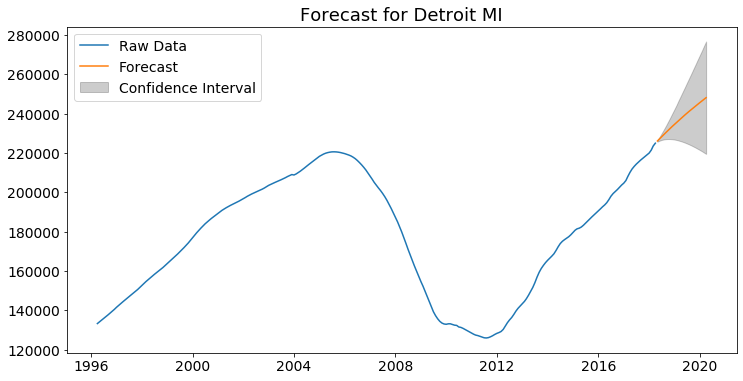

In [708]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [667]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,1), confint=2)

### RESULTS--Detroit MI:  Good-to-excellent investment opportunity

By the model prediction, I would expect to see a 10.276% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -2.418% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 22.971% change in price by April 1, 2020.

In [709]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57,
  317713.82,
  347420.52,
  979082.82,
  276625.5],
 [253947.46543778802,
  931603.1700288184,
  604409.595

## Investment modeling:   Phoenix AZ


### Create ts dataframe for *single* geographic area

In [941]:
geog_area = 'Phoenix AZ'

In [942]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [943]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Phoenix AZ')
ts.head()

MetroState State          value
time                                       
1996-04-01  Phoenix AZ    AZ  130341.803279
1996-05-01  Phoenix AZ    AZ  130920.491803
1996-06-01  Phoenix AZ    AZ  131516.393443
1996-07-01  Phoenix AZ    AZ  132111.475410
1996-08-01  Phoenix AZ    AZ  132722.131148

In [944]:
ts.tail()

MetroState State          value
time                                       
2017-12-01  Phoenix AZ    AZ  307970.634921
2018-01-01  Phoenix AZ    AZ  309583.333333
2018-02-01  Phoenix AZ    AZ  311136.507937
2018-03-01  Phoenix AZ    AZ  313058.730159
2018-04-01  Phoenix AZ    AZ  314711.904762

In [945]:
ts_values = ts['value']

In [946]:
ts_values.head()

time
1996-04-01    130341.803279
1996-05-01    130920.491803
1996-06-01    131516.393443
1996-07-01    132111.475410
1996-08-01    132722.131148
Name: value, dtype: float64

### Visualizations

#### Plot of Phoenix AZ

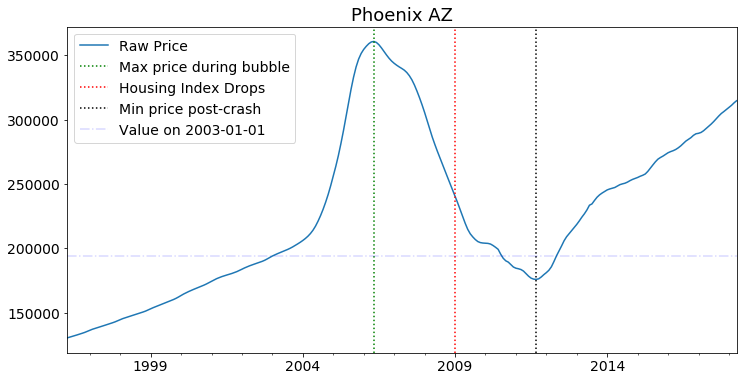

In [947]:
plot_single_geog(df_metro_values, 'Phoenix AZ', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

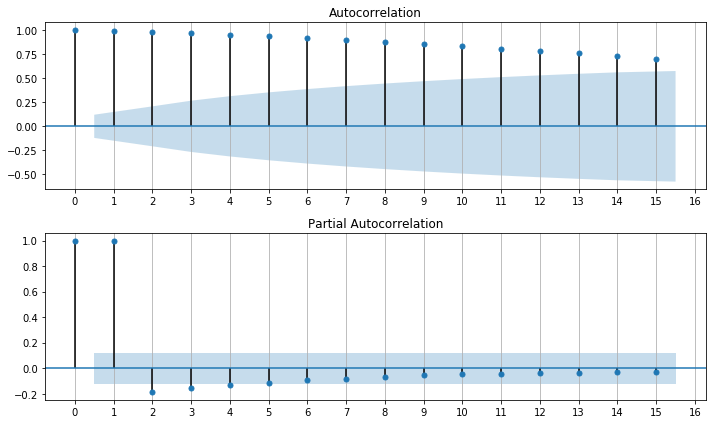

In [717]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

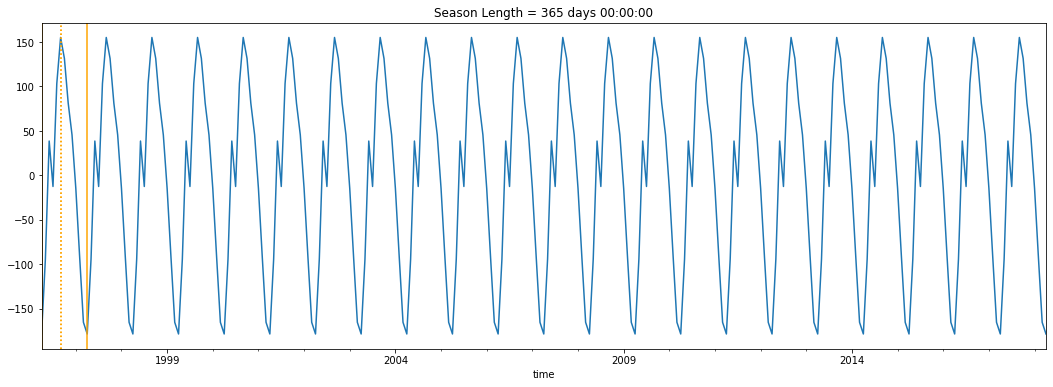

In [718]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [719]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [720]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Phoenix AZ:
# ARIMA(0, 0, 0) MSE=2338513675.307
# ARIMA(0, 0, 1) MSE=598072697.797
# ARIMA(0, 1, 0) MSE=2490002.502
# ARIMA(0, 1, 1) MSE=1528511.344
# ARIMA(0, 2, 0) MSE=322658.605
# ARIMA(0, 2, 1) MSE=425807.188
# ARIMA(0, 2, 2) MSE=495619.175
# ARIMA(1, 0, 0) MSE=3668676.503
# ARIMA(1, 1, 0) MSE=316999.836
# ARIMA(1, 1, 1) MSE=416855.798
# ARIMA(1, 1, 2) MSE=489102.301
# ARIMA(1, 2, 0) MSE=436468.157
# ARIMA(1, 2, 1) MSE=471376.358
# ARIMA(2, 0, 1) MSE=411564.106
# ARIMA(2, 0, 2) MSE=475617.870
# ARIMA(2, 1, 1) MSE=465583.362
# ARIMA(2, 2, 0) MSE=462205.457
# ARIMA(2, 2, 1) MSE=479068.331
# ARIMA(4, 0, 2) MSE=442782.741
# ARIMA(4, 2, 0) MSE=514063.099
# Best ARIMA(1, 1, 0) MSE=316999.836
# Best ARIMA order = (1, 1, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Phoenix AZ:
ARIMA(0, 0, 0) MSE=2338513675.307
ARIMA(0, 0, 1) MSE=598072697.797
ARIMA(0, 1, 0) MSE=2490002.502
ARIMA(0, 1, 1) MSE=1528511.344
ARIMA(0, 2, 0) MSE=322658.605
ARIMA(0, 2, 1) MSE=425807.188
ARIMA(0, 2, 2) MSE=495619.175
ARIMA(1, 0, 0) MSE=3668676.503
ARIMA(1, 1, 0) MSE=316999.836
ARIMA(1, 1, 1) MSE=416855.798
ARIMA(1, 1, 2) MSE=489102.301
ARIMA(1, 2, 0) MSE=436468.157
ARIMA(1, 2, 1) MSE=471376.358
ARIMA(2, 0, 1) MSE=411564.106
ARIMA(2, 0, 2) MSE=475617.870
ARIMA(2, 1, 1) MSE=465583.362
ARIMA(2, 2, 0) MSE=462205.457
ARIMA(2, 2, 1) MSE=479068.331
ARIMA(4, 0, 2) MSE=442782.741
ARIMA(4, 2, 0) MSE=514063.099
Best ARIMA(1, 1, 0) MSE=316999.836
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2019.946
Method:                       css-mle   S.D. of innovations            50

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (4, 0, 2),
  (4, 2, 0)],
 [2338513675.3070383,
  598072697.7972655,
  2490002.5024332562,
  1528511.3444465473,
  322658.60465805396,
  425807.1875251526,
  495619.17521779664,
  3668676.50303754,
  316999.8358891455,
  416855.79760697705,
  489102.30069015763,
  436468.156996578,
  471376.35801753524,
  411564.1064871987,
  475617.86989598756,
  465583.3624732494,
  462205.45659262466,
  479068.33107903466,
  442782.74053968146,
  514063.0994503024],
 (1, 1, 0),
 316999.8358891455,
 ['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix 

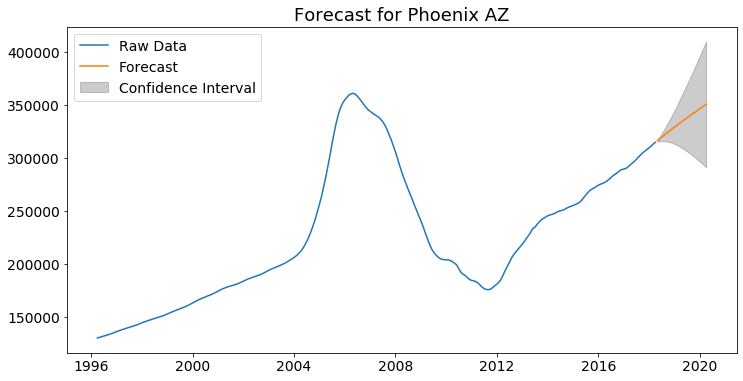

In [721]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [667]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,0), confint=2)


### RESULTS--Phoenix AZ:  A good-to-excellent investment with some downside potential but more upside potential

By the model prediction, I would expect to see a 11.334% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -7.514% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 30.182% change in price by April 1, 2020.

In [722]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540860.57,
  317713.82,
  347420.52,
  979082.82,
  276625.5,
 

## Investment modeling:   Indianapolis IN


### Create ts dataframe for *single* geographic area

In [723]:
geog_area = 'Indianapolis IN'

In [724]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [725]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Indianapolis IN')
ts.head()

MetroState State          value
time                                            
1996-04-01  Indianapolis IN    IN  119259.090909
1996-05-01  Indianapolis IN    IN  118836.363636
1996-06-01  Indianapolis IN    IN  118413.636364
1996-07-01  Indianapolis IN    IN  118005.681818
1996-08-01  Indianapolis IN    IN  117664.772727

In [726]:
ts.tail()

MetroState State          value
time                                            
2017-12-01  Indianapolis IN    IN  159182.608696
2018-01-01  Indianapolis IN    IN  159827.173913
2018-02-01  Indianapolis IN    IN  160792.391304
2018-03-01  Indianapolis IN    IN  162448.913043
2018-04-01  Indianapolis IN    IN  163829.347826

In [727]:
ts_values = ts['value']

In [728]:
ts_values.head()

time
1996-04-01    119259.090909
1996-05-01    118836.363636
1996-06-01    118413.636364
1996-07-01    118005.681818
1996-08-01    117664.772727
Name: value, dtype: float64

### Visualizations

#### Plot of Indianapolis IN

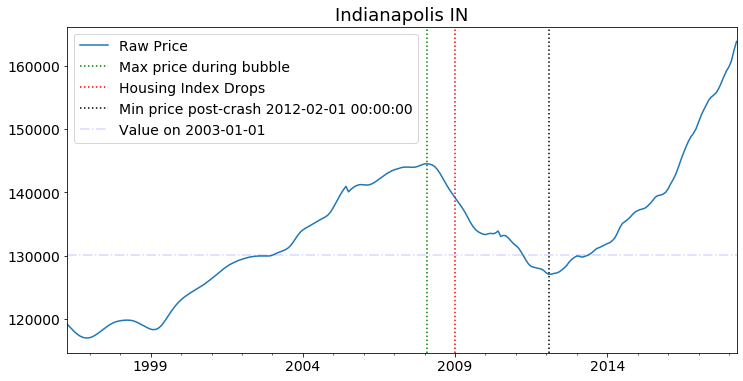

In [729]:
plot_single_geog(df_metro_values, 'Indianapolis IN', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

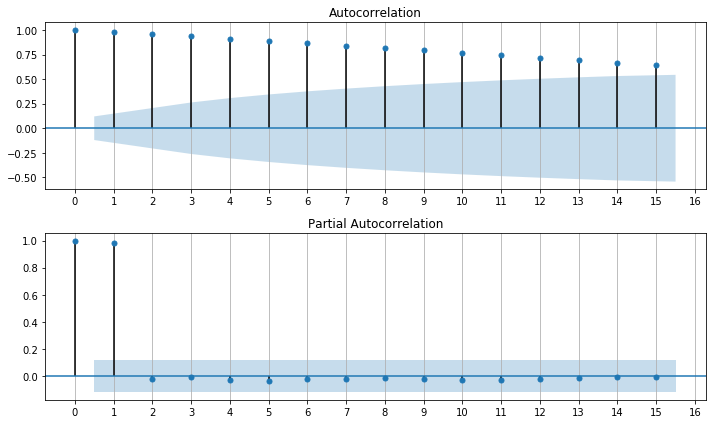

In [730]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

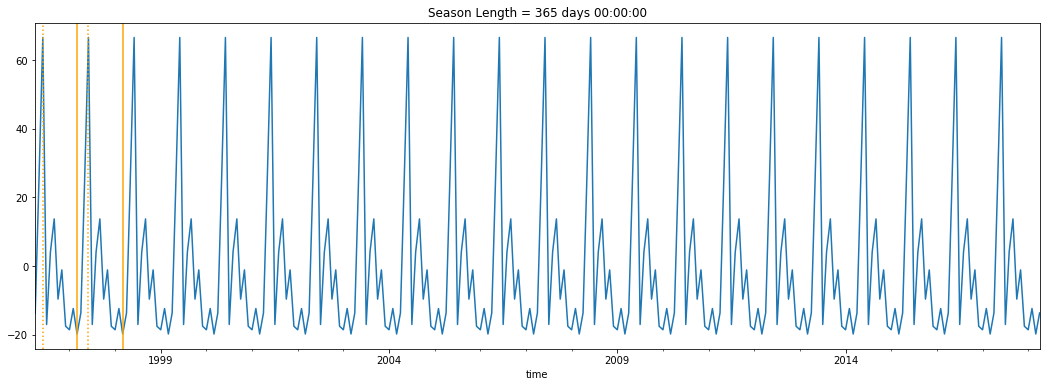

In [731]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [732]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [589]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Indianapolis IN:
# ARIMA(0, 0, 0) MSE=141577329.079
# ARIMA(0, 0, 1) MSE=37945002.961
# ARIMA(0, 1, 0) MSE=267278.901
# ARIMA(0, 1, 1) MSE=105683.525
# ARIMA(0, 1, 2) MSE=72105.836
# ARIMA(0, 2, 0) MSE=30187.849
# ARIMA(0, 2, 1) MSE=37453.271
# ARIMA(0, 2, 2) MSE=39017.338
# ARIMA(1, 0, 0) MSE=339262.654
# ARIMA(1, 1, 0) MSE=33158.180
# ARIMA(1, 1, 1) MSE=38227.884
# ARIMA(1, 1, 2) MSE=40726.621
# ARIMA(1, 2, 0) MSE=38686.821
# ARIMA(1, 2, 1) MSE=38211.116
# ARIMA(1, 2, 2) MSE=38954.909
# ARIMA(2, 1, 0) MSE=39498.941
# ARIMA(2, 1, 1) MSE=39600.641
# ARIMA(2, 2, 0) MSE=38828.063
# ARIMA(2, 2, 1) MSE=39144.228
# ARIMA(2, 2, 2) MSE=40374.284
# ARIMA(4, 1, 0) MSE=41330.867
# ARIMA(4, 1, 1) MSE=41680.264
# ARIMA(4, 2, 0) MSE=40083.335
# ARIMA(4, 2, 1) MSE=40135.080
# ARIMA(6, 1, 0) MSE=42172.158
# ARIMA(6, 2, 0) MSE=40470.608
# ARIMA(6, 2, 1) MSE=40539.796
# ARIMA(8, 1, 0) MSE=42760.704
# ARIMA(8, 1, 1) MSE=44744.813
# ARIMA(8, 2, 0) MSE=41067.961
# ARIMA(8, 2, 1) MSE=40798.075
# ARIMA(10, 1, 0) MSE=43628.462
# ARIMA(10, 1, 1) MSE=42826.914
# ARIMA(10, 2, 0) MSE=41424.184
# ARIMA(10, 2, 1) MSE=40562.509
# ARIMA(10, 2, 2) MSE=40705.968
# Best ARIMA(0, 2, 0) MSE=30187.849
# Best ARIMA order = (0, 2, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Indianapolis IN:
ARIMA(0, 0, 0) MSE=141577329.079
ARIMA(0, 0, 1) MSE=37945002.961
ARIMA(0, 1, 0) MSE=267278.901
ARIMA(0, 1, 1) MSE=105683.525
ARIMA(0, 1, 2) MSE=72105.836
ARIMA(0, 2, 0) MSE=30187.849
ARIMA(0, 2, 1) MSE=37453.271
ARIMA(0, 2, 2) MSE=39017.338
ARIMA(1, 0, 0) MSE=339262.654
ARIMA(1, 1, 0) MSE=33158.180
ARIMA(1, 1, 1) MSE=38227.884
ARIMA(1, 1, 2) MSE=40726.621
ARIMA(1, 2, 0) MSE=38686.821
ARIMA(1, 2, 1) MSE=38211.116
ARIMA(1, 2, 2) MSE=38954.909
ARIMA(2, 1, 0) MSE=39498.941
ARIMA(2, 1, 1) MSE=39600.641
ARIMA(2, 2, 0) MSE=38828.063
ARIMA(2, 2, 1) MSE=39144.228
ARIMA(2, 2, 2) MSE=40374.284
ARIMA(4, 1, 0) MSE=41330.867
ARIMA(4, 1, 1) MSE=41680.264
ARIMA(4, 2, 0) MSE=40083.335
ARIMA(4, 2, 1) MSE=40135.080
ARIMA(6, 1, 0) MSE=42172.158
ARIMA(6, 2, 0) MSE=40470.608
ARIMA(6, 2, 1) MSE=40539.796
ARIMA(8, 1, 0) MSE=42760.704
ARIMA(8, 1, 1) MSE=44744.813
ARIMA(8, 2, 0) MSE=41067.961
ARIMA(8, 2, 1) MSE=40798.075
ARIMA(10, 1, 0) MSE=43628.462
ARIMA(10, 1, 1) MSE=42826.914
ARIMA(10, 

([(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2),
  (4, 1, 0),
  (4, 1, 1),
  (4, 2, 0),
  (4, 2, 1),
  (6, 1, 0),
  (6, 2, 0),
  (6, 2, 1),
  (8, 1, 0),
  (8, 1, 1),
  (8, 2, 0),
  (8, 2, 1),
  (10, 1, 0),
  (10, 1, 1),
  (10, 2, 0),
  (10, 2, 1),
  (10, 2, 2)],
 [141577329.07867038,
  37945002.96084187,
  267278.9011815856,
  105683.52452330335,
  72105.83601248787,
  30187.849265620058,
  37453.27109824722,
  39017.337575478756,
  339262.65372748603,
  33158.18001146269,
  38227.883811977415,
  40726.62068222523,
  38686.82057932671,
  38211.11582255072,
  38954.90889264228,
  39498.94101320575,
  39600.6408604785,
  38828.06290141311,
  39144.22759501377,
  40374.28370447003,
  41330.867319027966,
  41680.26440322153,
  40083.33518171446,
  40135.0798973481,
  42172.157907039

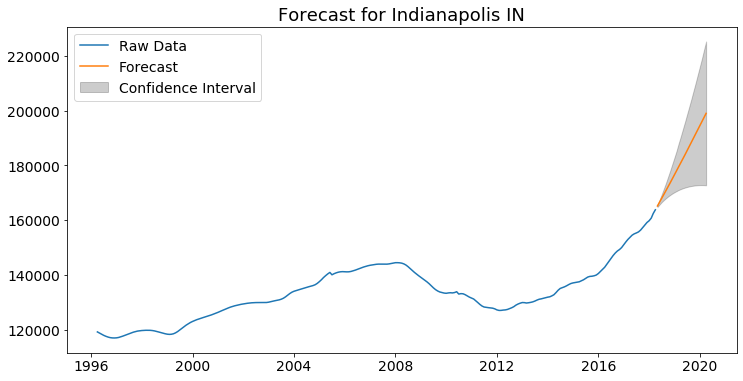

In [733]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [667]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (0,2,0), confint=2)


### RESULTS--Indianapolis IN:  Excellent investment opportunity with predicted values of over 21%

By the model prediction, I would expect to see a 21.478% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 5.461% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 37.495% change in price by April 1, 2020.

In [734]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0),
  (0, 2, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32,
  199016.62],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67,
  172775.48],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  315517.47,
  720187.47,
  1439371.36,
  1668422.72,
  540

## Investment modeling:   Tampa FL

### Create ts dataframe for *single* geographic area

In [948]:
geog_area = 'Tampa FL'

In [949]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [950]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Tampa FL')
ts.head()

MetroState State         value
time                                     
1996-04-01   Tampa FL    FL  93950.427350
1996-05-01   Tampa FL    FL  93997.435897
1996-06-01   Tampa FL    FL  94052.991453
1996-07-01   Tampa FL    FL  94102.564103
1996-08-01   Tampa FL    FL  94173.504274

In [951]:
ts.tail()

MetroState State          value
time                                      
2017-12-01   Tampa FL    FL  247627.118644
2018-01-01   Tampa FL    FL  249176.271186
2018-02-01   Tampa FL    FL  251643.220339
2018-03-01   Tampa FL    FL  255146.610169
2018-04-01   Tampa FL    FL  257784.745763

In [952]:
ts_values = ts['value']

In [953]:
ts_values.head()

time
1996-04-01    93950.427350
1996-05-01    93997.435897
1996-06-01    94052.991453
1996-07-01    94102.564103
1996-08-01    94173.504274
Name: value, dtype: float64

### Visualizations

#### Plot of Tampa FL

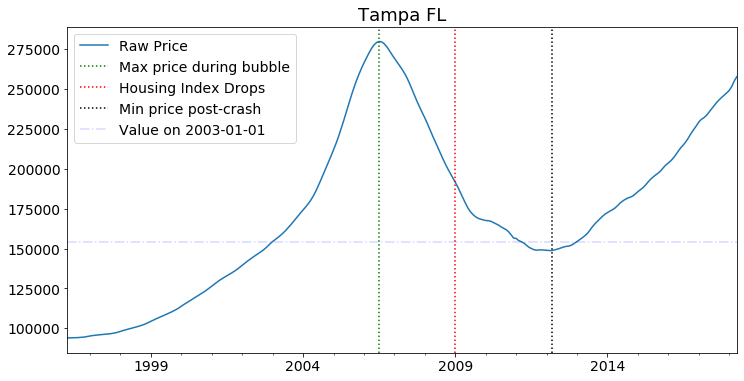

In [954]:
plot_single_geog(df_metro_values, 'Tampa FL', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

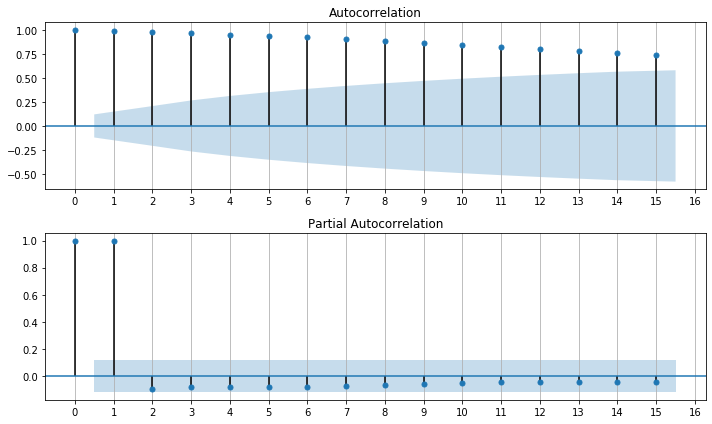

In [742]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

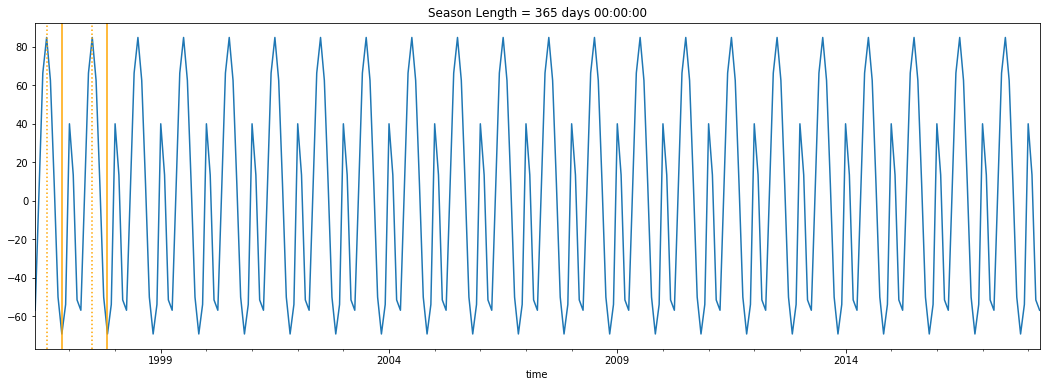

In [743]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [744]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [745]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Tampa FL:
# ARIMA(0, 0, 0) MSE=1413788298.031
# ARIMA(0, 1, 0) MSE=1483208.419
# ARIMA(0, 1, 1) MSE=762951.181
# ARIMA(0, 2, 0) MSE=165110.701
# ARIMA(0, 2, 1) MSE=222256.119
# ARIMA(1, 1, 0) MSE=163958.975
# ARIMA(1, 1, 2) MSE=310707.250
# ARIMA(1, 2, 0) MSE=228553.676
# ARIMA(1, 2, 1) MSE=286994.003
# ARIMA(2, 0, 2) MSE=310891.309
# ARIMA(2, 1, 1) MSE=286134.034
# ARIMA(2, 2, 0) MSE=284705.974
# ARIMA(2, 2, 1) MSE=300525.017
# ARIMA(4, 0, 1) MSE=94817354.311
# ARIMA(4, 2, 0) MSE=307366.209
# ARIMA(4, 2, 1) MSE=324566.094
# ARIMA(6, 0, 1) MSE=301818.888
# ARIMA(10, 2, 0) MSE=393275.461
# Best ARIMA(1, 1, 0) MSE=163958.975
# Best ARIMA order = (1, 1, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Tampa FL:
ARIMA(0, 0, 0) MSE=1413788298.031
ARIMA(0, 1, 0) MSE=1483208.419
ARIMA(0, 1, 1) MSE=762951.181
ARIMA(0, 2, 0) MSE=165110.701
ARIMA(0, 2, 1) MSE=222256.119
ARIMA(1, 1, 0) MSE=163958.975
ARIMA(1, 1, 2) MSE=310707.250
ARIMA(1, 2, 0) MSE=228553.676
ARIMA(1, 2, 1) MSE=286994.003
ARIMA(2, 0, 2) MSE=310891.309
ARIMA(2, 1, 1) MSE=286134.034
ARIMA(2, 2, 0) MSE=284705.974
ARIMA(2, 2, 1) MSE=300525.017
ARIMA(4, 0, 1) MSE=94817354.311
ARIMA(4, 2, 0) MSE=307366.209
ARIMA(4, 2, 1) MSE=324566.094
ARIMA(6, 0, 1) MSE=301818.888
ARIMA(10, 2, 0) MSE=393275.461
Best ARIMA(1, 1, 0) MSE=163958.975
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1884.733
Method:                       css-mle   S.D. of innovations            302.900
Date:                Thu, 02 Apr 2020   AIC               

([(0, 0, 0),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (1, 1, 0),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 2),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (4, 0, 1),
  (4, 2, 0),
  (4, 2, 1),
  (6, 0, 1),
  (10, 2, 0)],
 [1413788298.03076,
  1483208.4187998723,
  762951.1812370016,
  165110.70130507482,
  222256.1185033457,
  163958.9750672281,
  310707.2498049719,
  228553.67613465007,
  286994.00269489404,
  310891.3094622388,
  286134.0343956794,
  284705.97397576016,
  300525.01728564745,
  94817354.31139058,
  307366.2093817849,
  324566.0936851352,
  301818.8878819897,
  393275.46058075177],
 (1, 1, 0),
 163958.9750672281,
 ['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL'],
 [(8, 2, 0),
  (1, 1, 2),
  (1

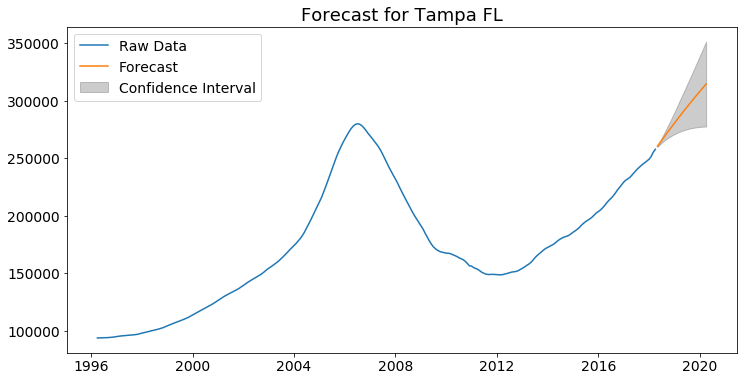

In [746]:
# arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [667]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,0), confint=2)


### RESULTS--Tampa FL:  Very strong investment opportunity, with ~22% predicted returns; even the worst-case scenario returns are positive

By the model prediction, I would expect to see a 21.977% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 7.645% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 36.31% change in price by April 1, 2020.

In [747]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32,
  199016.62,
  314439.02],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67,
  172775.48,
  277492.27],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  3155

# Summary of findings

In [905]:
print_met_lengths()

met_geog_areas:  16
met_orders:  16
met_predicted_prices:  16
met_lower_bound_prices:  16
met_upper_bound_prices:  16
met_last_values:  16
met_pred_pct_changes:  16
met_lower_pct_changes:  16
met_upper_pct_changes:  16


In [763]:
print_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32,
  199016.62,
  314439.02],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67,
  172775.48,
  277492.27],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  3155

In [764]:
# print_metro_results_lists()

# (['Dallas-Fort Worth TX',
#   'Los Angeles-Long Beach-Anaheim CA',
#   'Boston MA',
#   'Pittsburgh PA',
#   'Atlanta GA',
#   'Seattle WA',
#   'New York NY',
#   'San Francisco CA',
#   'Denver CO',
#   'Nashville TN',
#   'Minneapolis-St Paul MN',
#   'San Diego CA',
#   'Detroit MI',
#   'Phoenix AZ',
#   'Indianapolis IN',
#   'Tampa FL'],
#  [(8, 2, 0),
#   (1, 1, 2),
#   (1, 1, 0),
#   (8, 2, 0),
#   (1, 1, 0),
#   (2, 2, 2),
#   (0, 2, 0),
#   (1, 1, 0),
#   (1, 1, 0),
#   (0, 2, 0),
#   (1, 1, 1),
#   (0, 2, 1),
#   (1, 1, 1),
#   (1, 1, 0),
#   (0, 2, 0),
#   (1, 1, 0)],
#  [293773.15,
#   968850.81,
#   645882.95,
#   167911.06,
#   283770.73,
#   631683.2,
#   812079.76,
#   1516065.15,
#   507827.44,
#   294116.32,
#   312125.2,
#   795568.13,
#   248068.85,
#   350380.32,
#   199016.62,
#   314439.02],
#  [273372.08,
#   835905.83,
#   585569.59,
#   157781.43,
#   252023.98,
#   543178.92,
#   184788.17,
#   1363707.57,
#   474794.3,
#   270518.82,
#   276829.88,
#   612053.44,
#   219512.21,
#   291063.67,
#   172775.48,
#   277492.27],
#  [314174.21,
#   1101795.8,
#   706196.32,
#   178040.7,
#   315517.47,
#   720187.47,
#   1439371.36,
#   1668422.72,
#   540860.57,
#   317713.82,
#   347420.52,
#   979082.82,
#   276625.5,
#   409696.98,
#   225257.76,
#   351385.78],
#  [253947.46543778802,
#   931603.1700288184,
#   604409.595959596,
#   149648.02259887007,
#   257841.44736842104,
#   583936.1702127659,
#   726948.3009708738,
#   1361623.134328358,
#   438153.77358490566,
#   245022.35294117648,
#   281777.12765957444,
#   775151.724137931,
#   224952.28758169935,
#   314711.90476190473,
#   163829.34782608695,
#   257784.74576271186],
#  [15.68,
#   4.0,
#   6.86,
#   12.2,
#   10.06,
#   8.18,
#   11.71,
#   11.34,
#   15.9,
#   20.04,
#   10.77,
#   2.63,
#   10.28,
#   11.33,
#   21.48,
#   21.98],
#  [7.65,
#   -10.27,
#   -3.12,
#   5.44,
#   -2.26,
#   -6.98,
#   -74.58,
#   0.15,
#   8.36,
#   10.41,
#   -1.76,
#   -21.04,
#   -2.42,
#   -7.51,
#   5.46,
#   7.64],
#  [23.72,
#   18.27,
#   16.84,
#   18.97,
#   22.37,
#   23.33,
#   98.0,
#   22.53,
#   23.44,
#   29.67,
#   23.3,
#   26.31,
#   22.97,
#   30.18,
#   37.5,
#   36.31])

## Creating summary dataframe

In [906]:
met_invest_recs = []

for i in range(len(met_pred_pct_changes)):
    if met_pred_pct_changes[i] <= 0:
        met_invest_recs.append("no stars")
    elif met_pred_pct_changes[i] <= 4.9:
        met_invest_recs.append("1 star")
    elif met_pred_pct_changes[i] <= 9.9 and met_lower_pct_changes[i] < 0:
        met_invest_recs.append("2 stars")
    elif met_pred_pct_changes[i] <= 9.9 and met_lower_pct_changes[i] >= 0:
        met_invest_recs.append("3 stars")
    elif met_pred_pct_changes[i] > 9.9 and met_lower_pct_changes[i] < 0:
        met_invest_recs.append("4 stars")
    else:
        met_invest_recs.append("5 stars")

met_invest_recs


['5 stars',
 '1 star',
 '2 stars',
 '5 stars',
 '4 stars',
 '2 stars',
 '4 stars',
 '5 stars',
 '5 stars',
 '5 stars',
 '4 stars',
 '1 star',
 '4 stars',
 '4 stars',
 '5 stars',
 '5 stars']

In [907]:
len(met_invest_recs)

16

In [908]:
# met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, 
# met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes, met_invest_recs

df_metro_findings = pd.DataFrame({'Metro': met_geog_areas, '2018 value': met_last_values, 
                            'Investment rating': met_invest_recs, 
                            'Predicted % Change': met_pred_pct_changes, 'Worst Case % Change': met_lower_pct_changes,
                            'Best Case % Change': met_upper_pct_changes, 'Predicted':met_predicted_prices, 
                            'Worst Case':met_lower_bound_prices, 'Best Case':met_upper_bound_prices})


In [909]:
df_metro_findings

Metro    2018 value Investment rating  \
0                Dallas-Fort Worth TX  2.539475e+05           5 stars   
1   Los Angeles-Long Beach-Anaheim CA  9.316032e+05            1 star   
2                           Boston MA  6.044096e+05           2 stars   
3                       Pittsburgh PA  1.496480e+05           5 stars   
4                          Atlanta GA  2.578414e+05           4 stars   
5                          Seattle WA  5.839362e+05           2 stars   
6                         New York NY  7.269483e+05           4 stars   
7                    San Francisco CA  1.361623e+06           5 stars   
8                           Denver CO  4.381538e+05           5 stars   
9                        Nashville TN  2.450224e+05           5 stars   
10             Minneapolis-St Paul MN  2.817771e+05           4 stars   
11                       San Diego CA  7.751517e+05            1 star   
12                         Detroit MI  2.249523e+05           4 stars   
13                         Phoenix AZ  3.147119e+05           4 stars   
14                    Indianapolis IN  1.638293e+05           5 stars   
15                           Tampa FL  2.577847e+05           5 stars   

    Predicted % Change  Worst Case % Change  Best Case % Change   Predicted  \
0                15.68                 7.65               23.72   293773.15   
1                 4.00               -10.27               18.27   968850.81   
2                 6.86                -3.12               16.84   645882.95   
3                12.20                 5.44               18.97   167911.06   
4                10.06                -2.26               22.37   283770.73   
5                 8.18                -6.98               23.33   631683.20   
6                11.71               -74.58               98.00   812079.76   
7                11.34                 0.15               22.53  1516065.15   
8                15.90                 8.36               23.44   507827.44   
9                20.04                10.41               29.67   294116.32   
10               10.77                -1.76               23.30   312125.20   
11                2.63               -21.04               26.31   795568.13   
12               10.28                -2.42               22.97   248068.85   
13               11.33                -7.51               30.18   350380.32   
14               21.48                 5.46               37.50   199016.62   
15               21.98                 7.64               36.31   314439.02   

    Worst Case   Best Case  
0    273372.08   314174.21  
1    835905.83  1101795.80  
2    585569.59   706196.32  
3    157781.43   178040.70  
4    252023.98   315517.47  
5    543178.92   720187.47  
6    184788.17  1439371.36  
7   1363707.57  1668422.72  
8    474794.30   540860.57  
9    270518.82   317713.82  
10   276829.88   347420.52  
11   612053.44   979082.82  
12   219512.21   276625.50  
13   291063.67   409696.98  
14   172775.48   225257.76  
15   277492.27   351385.78

## Summary dataframe, sorted by investment rating

In [910]:
df_metro_findings.sort_values(by=['Investment rating', 'Predicted % Change'], ascending = False, inplace=True)


In [911]:
df_metro_findings

Metro    2018 value Investment rating  \
15                           Tampa FL  2.577847e+05           5 stars   
14                    Indianapolis IN  1.638293e+05           5 stars   
9                        Nashville TN  2.450224e+05           5 stars   
8                           Denver CO  4.381538e+05           5 stars   
0                Dallas-Fort Worth TX  2.539475e+05           5 stars   
3                       Pittsburgh PA  1.496480e+05           5 stars   
7                    San Francisco CA  1.361623e+06           5 stars   
6                         New York NY  7.269483e+05           4 stars   
13                         Phoenix AZ  3.147119e+05           4 stars   
10             Minneapolis-St Paul MN  2.817771e+05           4 stars   
12                         Detroit MI  2.249523e+05           4 stars   
4                          Atlanta GA  2.578414e+05           4 stars   
5                          Seattle WA  5.839362e+05           2 stars   
2                           Boston MA  6.044096e+05           2 stars   
1   Los Angeles-Long Beach-Anaheim CA  9.316032e+05            1 star   
11                       San Diego CA  7.751517e+05            1 star   

    Predicted % Change  Worst Case % Change  Best Case % Change   Predicted  \
15               21.98                 7.64               36.31   314439.02   
14               21.48                 5.46               37.50   199016.62   
9                20.04                10.41               29.67   294116.32   
8                15.90                 8.36               23.44   507827.44   
0                15.68                 7.65               23.72   293773.15   
3                12.20                 5.44               18.97   167911.06   
7                11.34                 0.15               22.53  1516065.15   
6                11.71               -74.58               98.00   812079.76   
13               11.33                -7.51               30.18   350380.32   
10               10.77                -1.76               23.30   312125.20   
12               10.28                -2.42               22.97   248068.85   
4                10.06                -2.26               22.37   283770.73   
5                 8.18                -6.98               23.33   631683.20   
2                 6.86                -3.12               16.84   645882.95   
1                 4.00               -10.27               18.27   968850.81   
11                2.63               -21.04               26.31   795568.13   

    Worst Case   Best Case  
15   277492.27   351385.78  
14   172775.48   225257.76  
9    270518.82   317713.82  
8    474794.30   540860.57  
0    273372.08   314174.21  
3    157781.43   178040.70  
7   1363707.57  1668422.72  
6    184788.17  1439371.36  
13   291063.67   409696.98  
10   276829.88   347420.52  
12   219512.21   276625.50  
4    252023.98   315517.47  
5    543178.92   720187.47  
2    585569.59   706196.32  
1    835905.83  1101795.80  
11   612053.44   979082.82

The summary table is sorted by the investment rating, which was based primarily on the percentage increase (or decrease) in value at the end of the 24-month forecast period.  The top 7 metro areas all have returns of 11% or greater, with strong upside potential and no loss of principal investment even in the worst-case scenario.  

Based on both the predicted returns and the best- and worst-case scenarios, I would recommend the following 7 metro areas for further exploration:

* Tampa, FL
* Indianapolis, IN
* Nashville, TN
* Denver, CO
* Dallas-Ft Worth, TX
* Pittsburgh, PA
* San Francisco, CA (see note below)

Note:  because the San Francisco metro area is so large and diverse, further exploration at smaller geographic units will likely be required, prior to evaluating ZIP codes. Further, there are some additional metro areas near the SF Bay Area that should be explored--especially those to the furthest reaches to the South and East.  These areas have been attracting commuters, who work in Silicon Valley but want/need more affordable housing options, since the 1990s.  While some of these areas (e.g., Dublin, Tracy) were hard-hit during the housing market crash, it is likely with the subsequent spike of housing values subsequently that these areas are likely to increase in value over the next few years.

## Investment modeling:   Sacramento CA

### Create ts dataframe for *single* geographic area

In [913]:
geog_area = 'Sacramento CA'

In [914]:
# ts = df_metro_values.loc[df_metro_values['MetroState'] == geog_area]

In [915]:
ts = df_geog(df=df_metro_values, col = 'MetroState', geog_area = 'Sacramento CA')
ts.head()

MetroState State          value
time                                          
1996-04-01  Sacramento CA    CA  147985.555556
1996-05-01  Sacramento CA    CA  147713.333333
1996-06-01  Sacramento CA    CA  147456.666667
1996-07-01  Sacramento CA    CA  147211.111111
1996-08-01  Sacramento CA    CA  147023.333333

In [916]:
ts.tail()

MetroState State          value
time                                          
2017-12-01  Sacramento CA    CA  425683.695652
2018-01-01  Sacramento CA    CA  429176.086957
2018-02-01  Sacramento CA    CA  432461.956522
2018-03-01  Sacramento CA    CA  435318.478261
2018-04-01  Sacramento CA    CA  436730.434783

In [917]:
ts_values = ts['value']

In [918]:
ts_values.head()

time
1996-04-01    147985.555556
1996-05-01    147713.333333
1996-06-01    147456.666667
1996-07-01    147211.111111
1996-08-01    147023.333333
Name: value, dtype: float64

### Visualizations

#### Plot of Sacramento CA

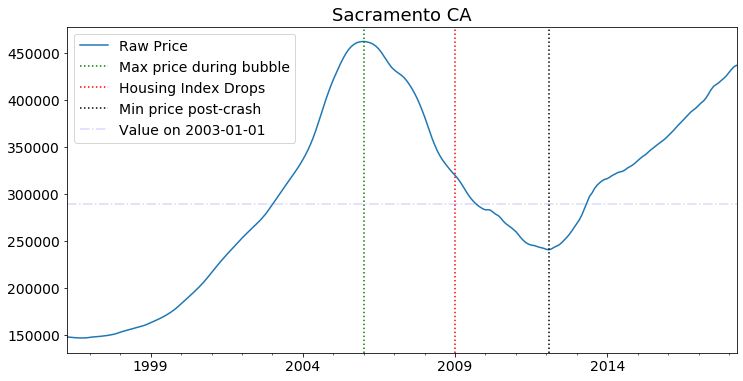

In [919]:
plot_single_geog(df_metro_values, 'Sacramento CA', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

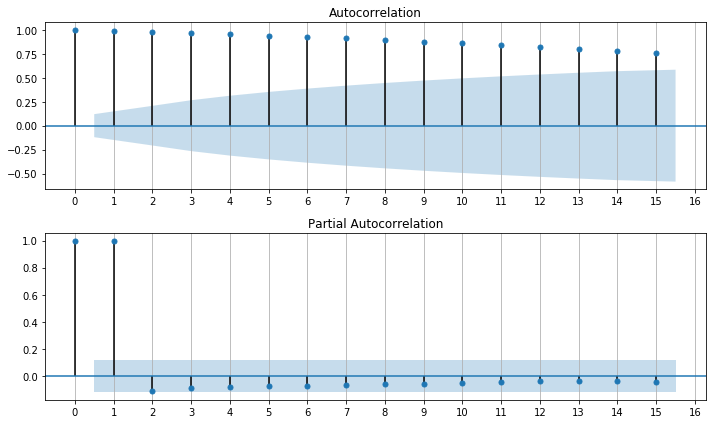

In [890]:
plot_acf_pacf(ts_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

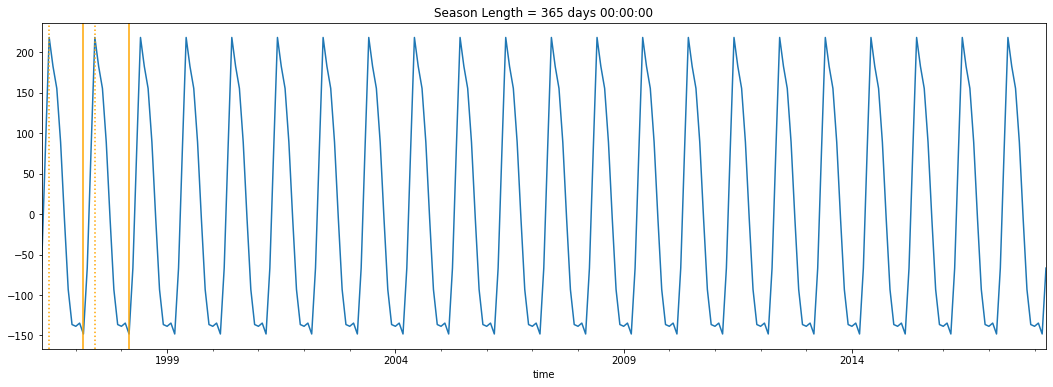

In [891]:
plot_seasonal_decomp(ts_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [892]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#### ARIMA parameter tuning 

In [893]:
# evaluate_models(ts_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

# For Sacramento CA:
# ARIMA(0, 0, 0) MSE=4791823362.463
# ARIMA(0, 1, 0) MSE=5079304.285
# ARIMA(0, 1, 1) MSE=2342867.192
# ARIMA(0, 2, 0) MSE=442797.599
# ARIMA(0, 2, 1) MSE=560974.257
# ARIMA(1, 1, 0) MSE=436878.303
# ARIMA(1, 1, 2) MSE=623919.830
# ARIMA(1, 2, 0) MSE=492956.152
# ARIMA(1, 2, 1) MSE=609161.484
# ARIMA(2, 0, 2) MSE=616567.063
# ARIMA(2, 1, 1) MSE=604588.439
# ARIMA(2, 2, 0) MSE=531985.889
# ARIMA(4, 0, 1) MSE=610924.238
# ARIMA(4, 0, 2) MSE=610551.869
# ARIMA(4, 1, 1) MSE=628045.368
# ARIMA(4, 2, 0) MSE=679736.705
# Best ARIMA(1, 1, 0) MSE=436878.303
# Best ARIMA order = (1, 1, 0)

### ARIMA modeling results:  predictions and visualization

#### Run ARIMA function WITH parameter-tuning, model fit, and forecasting operations

For Sacramento CA:
ARIMA(0, 0, 0) MSE=4791823362.463
ARIMA(0, 1, 0) MSE=5079304.285
ARIMA(0, 1, 1) MSE=2342867.192
ARIMA(0, 2, 0) MSE=442797.599
ARIMA(0, 2, 1) MSE=560974.257
ARIMA(1, 1, 0) MSE=436878.303
ARIMA(1, 1, 2) MSE=623919.830
ARIMA(1, 2, 0) MSE=492956.152
ARIMA(1, 2, 1) MSE=609161.484
ARIMA(2, 0, 2) MSE=616567.063
ARIMA(2, 1, 1) MSE=604588.439
ARIMA(2, 2, 0) MSE=531985.889
ARIMA(4, 0, 1) MSE=610924.238
ARIMA(4, 0, 2) MSE=610551.869
ARIMA(4, 1, 1) MSE=628045.368
ARIMA(4, 2, 0) MSE=679736.705
Best ARIMA(1, 1, 0) MSE=436878.303
Best ARIMA order = (1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2023.005
Method:                       css-mle   S.D. of innovations            511.543
Date:                Sat, 04 Apr 2020   AIC                           4052.010
Time:                        17:05:5

([(0, 0, 0),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (1, 1, 0),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 2),
  (2, 1, 1),
  (2, 2, 0),
  (4, 0, 1),
  (4, 0, 2),
  (4, 1, 1),
  (4, 2, 0)],
 [4791823362.462797,
  5079304.285190537,
  2342867.192283695,
  442797.59924870514,
  560974.2574377013,
  436878.30277183733,
  623919.8303683853,
  492956.15168297314,
  609161.4842130386,
  616567.0626206405,
  604588.4389672157,
  531985.8891284533,
  610924.2382448767,
  610551.8689640756,
  628045.3678601402,
  679736.7045448637],
 (1, 1, 0),
 436878.30277183733,
 ['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL',
  'Sacramento CA'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0

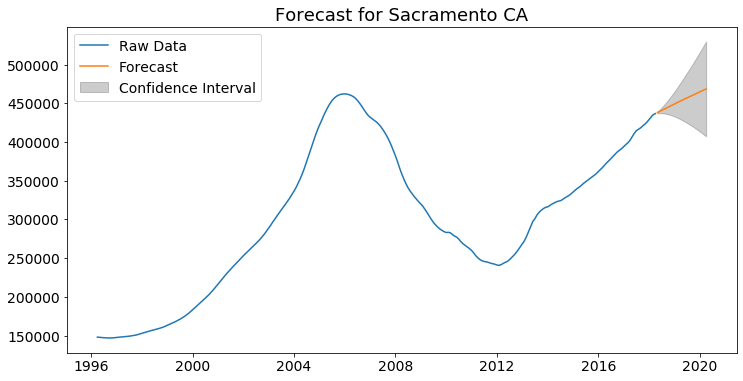

In [894]:
arima_metro_forecast_run(ts, geog_area, p_values, d_values, q_values, confint=2)

#### Run ARIMA function *without* parameter-tuning, model fit, and forecasting operations

In [667]:
# arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg = (1,1,0), confint=2)


### RESULTS--Sacramento CA:  Good investment with limited downside and solid potential best-case scenario upside

By the model prediction, I would expect to see a 7.291% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a -6.745% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 21.328% change in price by April 1, 2020.

In [904]:
pop_metro_results_lists()

(['Dallas-Fort Worth TX',
  'Los Angeles-Long Beach-Anaheim CA',
  'Boston MA',
  'Pittsburgh PA',
  'Atlanta GA',
  'Seattle WA',
  'New York NY',
  'San Francisco CA',
  'Denver CO',
  'Nashville TN',
  'Minneapolis-St Paul MN',
  'San Diego CA',
  'Detroit MI',
  'Phoenix AZ',
  'Indianapolis IN',
  'Tampa FL'],
 [(8, 2, 0),
  (1, 1, 2),
  (1, 1, 0),
  (8, 2, 0),
  (1, 1, 0),
  (2, 2, 2),
  (0, 2, 0),
  (1, 1, 0),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 1),
  (0, 2, 1),
  (1, 1, 1),
  (1, 1, 0),
  (0, 2, 0),
  (1, 1, 0)],
 [293773.15,
  968850.81,
  645882.95,
  167911.06,
  283770.73,
  631683.2,
  812079.76,
  1516065.15,
  507827.44,
  294116.32,
  312125.2,
  795568.13,
  248068.85,
  350380.32,
  199016.62,
  314439.02],
 [273372.08,
  835905.83,
  585569.59,
  157781.43,
  252023.98,
  543178.92,
  184788.17,
  1363707.57,
  474794.3,
  270518.82,
  276829.88,
  612053.44,
  219512.21,
  291063.67,
  172775.48,
  277492.27],
 [314174.21,
  1101795.8,
  706196.32,
  178040.7,
  3155

# Summary results including Sacramento

In [896]:
met_invest_recs_plus = []

for i in range(len(met_pred_pct_changes)):
    if met_pred_pct_changes[i] <= 0:
        met_invest_recs_plus.append("no stars")
    elif met_pred_pct_changes[i] <= 4.9:
        met_invest_recs_plus.append("1 star")
    elif met_pred_pct_changes[i] <= 9.9 and met_lower_pct_changes[i] < 0:
        met_invest_recs_plus.append("2 stars")
    elif met_pred_pct_changes[i] <= 9.9 and met_lower_pct_changes[i] >= 0:
        met_invest_recs_plus.append("3 stars")
    elif met_pred_pct_changes[i] > 9.9 and met_lower_pct_changes[i] < 0:
        met_invest_recs_plus.append("4 stars")
    else:
        met_invest_recs_plus.append("5 stars")

met_invest_recs_plus


['5 stars',
 '1 star',
 '2 stars',
 '5 stars',
 '4 stars',
 '2 stars',
 '4 stars',
 '5 stars',
 '5 stars',
 '5 stars',
 '4 stars',
 '1 star',
 '4 stars',
 '4 stars',
 '5 stars',
 '5 stars',
 '2 stars']

In [899]:
# met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, 
# met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes, met_invest_recs

df_metro_findings_plus = pd.DataFrame({'Metro': met_geog_areas, '2018 value': met_last_values, 
                            'Investment rating': met_invest_recs_plus, 
                            'Predicted % Change': met_pred_pct_changes, 'Worst Case % Change': met_lower_pct_changes,
                            'Best Case % Change': met_upper_pct_changes, 'Predicted':met_predicted_prices, 
                            'Worst Case':met_lower_bound_prices, 'Best Case':met_upper_bound_prices})


In [900]:
df_metro_findings_plus

Metro    2018 value Investment rating  \
0                Dallas-Fort Worth TX  2.539475e+05           5 stars   
1   Los Angeles-Long Beach-Anaheim CA  9.316032e+05            1 star   
2                           Boston MA  6.044096e+05           2 stars   
3                       Pittsburgh PA  1.496480e+05           5 stars   
4                          Atlanta GA  2.578414e+05           4 stars   
5                          Seattle WA  5.839362e+05           2 stars   
6                         New York NY  7.269483e+05           4 stars   
7                    San Francisco CA  1.361623e+06           5 stars   
8                           Denver CO  4.381538e+05           5 stars   
9                        Nashville TN  2.450224e+05           5 stars   
10             Minneapolis-St Paul MN  2.817771e+05           4 stars   
11                       San Diego CA  7.751517e+05            1 star   
12                         Detroit MI  2.249523e+05           4 stars   
13                         Phoenix AZ  3.147119e+05           4 stars   
14                    Indianapolis IN  1.638293e+05           5 stars   
15                           Tampa FL  2.577847e+05           5 stars   
16                      Sacramento CA  4.367304e+05           2 stars   

    Predicted % Change  Worst Case % Change  Best Case % Change   Predicted  \
0                15.68                 7.65               23.72   293773.15   
1                 4.00               -10.27               18.27   968850.81   
2                 6.86                -3.12               16.84   645882.95   
3                12.20                 5.44               18.97   167911.06   
4                10.06                -2.26               22.37   283770.73   
5                 8.18                -6.98               23.33   631683.20   
6                11.71               -74.58               98.00   812079.76   
7                11.34                 0.15               22.53  1516065.15   
8                15.90                 8.36               23.44   507827.44   
9                20.04                10.41               29.67   294116.32   
10               10.77                -1.76               23.30   312125.20   
11                2.63               -21.04               26.31   795568.13   
12               10.28                -2.42               22.97   248068.85   
13               11.33                -7.51               30.18   350380.32   
14               21.48                 5.46               37.50   199016.62   
15               21.98                 7.64               36.31   314439.02   
16                7.29                -6.75               21.33   468574.35   

    Worst Case   Best Case  
0    273372.08   314174.21  
1    835905.83  1101795.80  
2    585569.59   706196.32  
3    157781.43   178040.70  
4    252023.98   315517.47  
5    543178.92   720187.47  
6    184788.17  1439371.36  
7   1363707.57  1668422.72  
8    474794.30   540860.57  
9    270518.82   317713.82  
10   276829.88   347420.52  
11   612053.44   979082.82  
12   219512.21   276625.50  
13   291063.67   409696.98  
14   172775.48   225257.76  
15   277492.27   351385.78  
16   407272.27   529876.43

In [901]:
df_metro_findings_plus.sort_values(by=['Investment rating', 'Predicted % Change'], ascending = False, inplace=True)


In [902]:
df_metro_findings_plus

Metro    2018 value Investment rating  \
15                           Tampa FL  2.577847e+05           5 stars   
14                    Indianapolis IN  1.638293e+05           5 stars   
9                        Nashville TN  2.450224e+05           5 stars   
8                           Denver CO  4.381538e+05           5 stars   
0                Dallas-Fort Worth TX  2.539475e+05           5 stars   
3                       Pittsburgh PA  1.496480e+05           5 stars   
7                    San Francisco CA  1.361623e+06           5 stars   
6                         New York NY  7.269483e+05           4 stars   
13                         Phoenix AZ  3.147119e+05           4 stars   
10             Minneapolis-St Paul MN  2.817771e+05           4 stars   
12                         Detroit MI  2.249523e+05           4 stars   
4                          Atlanta GA  2.578414e+05           4 stars   
5                          Seattle WA  5.839362e+05           2 stars   
16                      Sacramento CA  4.367304e+05           2 stars   
2                           Boston MA  6.044096e+05           2 stars   
1   Los Angeles-Long Beach-Anaheim CA  9.316032e+05            1 star   
11                       San Diego CA  7.751517e+05            1 star   

    Predicted % Change  Worst Case % Change  Best Case % Change   Predicted  \
15               21.98                 7.64               36.31   314439.02   
14               21.48                 5.46               37.50   199016.62   
9                20.04                10.41               29.67   294116.32   
8                15.90                 8.36               23.44   507827.44   
0                15.68                 7.65               23.72   293773.15   
3                12.20                 5.44               18.97   167911.06   
7                11.34                 0.15               22.53  1516065.15   
6                11.71               -74.58               98.00   812079.76   
13               11.33                -7.51               30.18   350380.32   
10               10.77                -1.76               23.30   312125.20   
12               10.28                -2.42               22.97   248068.85   
4                10.06                -2.26               22.37   283770.73   
5                 8.18                -6.98               23.33   631683.20   
16                7.29                -6.75               21.33   468574.35   
2                 6.86                -3.12               16.84   645882.95   
1                 4.00               -10.27               18.27   968850.81   
11                2.63               -21.04               26.31   795568.13   

    Worst Case   Best Case  
15   277492.27   351385.78  
14   172775.48   225257.76  
9    270518.82   317713.82  
8    474794.30   540860.57  
0    273372.08   314174.21  
3    157781.43   178040.70  
7   1363707.57  1668422.72  
6    184788.17  1439371.36  
13   291063.67   409696.98  
10   276829.88   347420.52  
12   219512.21   276625.50  
4    252023.98   315517.47  
5    543178.92   720187.47  
16   407272.27   529876.43  
2    585569.59   706196.32  
1    835905.83  1101795.80  
11   612053.44   979082.82

# Notebook spacer


# Notebook spacer


# Notebook spacer
